## Solving the problem as a classification


The "income" (revenue) column acts as an objective function.
The classifier must determine whether a certain user who clicks on an ad will generate income (revenue=1) or not (revenue=0).

Let's try the following classifiers: 
- XGBoost
- Random Forest
- CatBoost

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn import metrics
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_confusion_matrix
from imblearn.over_sampling import SMOTE
from category_encoders.binary import BinaryEncoder
import matplotlib.pyplot as plt

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 6, 4

c:\users\owl\appdata\local\programs\python\python39\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Loading data

In [2]:
dataset = pd.read_csv('dataset_class.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387834 entries, 0 to 387833
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   bannerSize      387834 non-null  object 
 1   language        387834 non-null  object 
 2   country         387834 non-null  object 
 3   city            387834 non-null  object 
 4   browser         387834 non-null  object 
 5   browserVersion  387834 non-null  float64
 6   os              387834 non-null  object 
 7   osVersion       387834 non-null  object 
 8   deviceType      387834 non-null  object 
 9   deviceModel     387834 non-null  object 
 10  deviceBrand     387834 non-null  object 
 11  trafficSource   387834 non-null  int64  
 12  offer           387834 non-null  int64  
 13  connType        387834 non-null  object 
 14  proxyType       387834 non-null  object 
 15  revenue         387834 non-null  int64  
 16  weekday         387834 non-null  int64  
 17  hour      

In [3]:
columns = ['bannerSize', 'language', 'country', 'city', 'browser',
       'browserVersion', 'os', 'osVersion', 'deviceType', 'deviceModel',
       'deviceBrand', 'trafficSource', 'offer', 'connType', 'proxyType',
       'weekday', 'hour']
dataset[columns] = dataset[columns].astype(object, errors = 'raise')


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387834 entries, 0 to 387833
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   bannerSize      387834 non-null  object
 1   language        387834 non-null  object
 2   country         387834 non-null  object
 3   city            387834 non-null  object
 4   browser         387834 non-null  object
 5   browserVersion  387834 non-null  object
 6   os              387834 non-null  object
 7   osVersion       387834 non-null  object
 8   deviceType      387834 non-null  object
 9   deviceModel     387834 non-null  object
 10  deviceBrand     387834 non-null  object
 11  trafficSource   387834 non-null  object
 12  offer           387834 non-null  object
 13  connType        387834 non-null  object
 14  proxyType       387834 non-null  object
 15  revenue         387834 non-null  int64 
 16  weekday         387834 non-null  object
 17  hour            387834 non-nu

In [5]:
dataset.loc[dataset['revenue'] == 0].count()

bannerSize        380000
language          380000
country           380000
city              380000
browser           380000
browserVersion    380000
os                380000
osVersion         380000
deviceType        380000
deviceModel       380000
deviceBrand       380000
trafficSource     380000
offer             380000
connType          380000
proxyType         380000
revenue           380000
weekday           380000
hour              380000
dtype: int64

Choosing the right columns for the array of features (features) and encoding them using BinaryEncoder

In [6]:
X = dataset.drop(['revenue'], axis=1)
ce_bin = BinaryEncoder(cols = X.columns)
X = ce_bin.fit_transform(X)

c:\users\owl\appdata\local\programs\python\python39\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


In [7]:
ce_bin

BinaryEncoder(cols=Index(['bannerSize', 'language', 'country', 'city', 'browser',
       'browserVersion', 'os', 'osVersion', 'deviceType', 'deviceModel',
       'deviceBrand', 'trafficSource', 'offer', 'connType', 'proxyType',
       'weekday', 'hour'],
      dtype='object'))

Target

In [8]:
y = dataset.revenue

Separation of data into training and test parts

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In the data set with users who clicked on the banner, there is a huge imbalance between those who generated revenue and those who did not.
In the collected data, the real ratio is not displayed, since then there will be too much data to be submitted for training.

The ratio in dataset:

In [10]:
y_train.sum()/y_train.count() # (1/44)

0.01993120768163699

### Random forest

Defining the Model and Hyperparameters

In [129]:
rf = RandomForestClassifier()
parametrs = {'n_estimators': range(20, 80, 10), 'max_depth': range(6,13, 2),
            'min_samples_leaf': range(2,7), 'min_samples_split': range(2,10, 2)}

RandomizedSearch (/GridSearch)

In [140]:
search = RandomizedSearchCV(rf, parametrs, n_iter=50, cv = 3, error_score='raise')
# search = GridSearchCV(rf, parametrs, cv = 3, n_jobs=-1)

In [141]:
search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'max_depth': range(6, 13, 2),
                                        'min_samples_leaf': range(2, 7),
                                        'min_samples_split': range(2, 10, 2),
                                        'n_estimators': range(20, 80, 10)})

In [142]:
best_clf_rf = search.best_estimator_
best_clf_rf

RandomForestClassifier(max_depth=12, min_samples_leaf=6, n_estimators=70)

In [143]:
# Make a prediction on the test set
predictions = best_clf_rf.predict(X_test)

Precision and recall

In [144]:
precision_score(y_test, predictions, average='weighted')

0.9774490517425285

In [145]:
recall_score(y_test, predictions, average='weighted')

0.9803266345910879

Confusion matrix

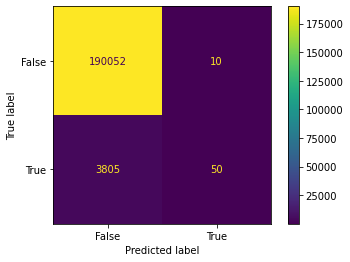

In [146]:
plot_confusion_matrix(best_clf_rf, X_test, y_test)
plt.show()

In [147]:
# Class Probability Prediction
y_predict_prob = best_clf_rf.predict_proba(X_test)

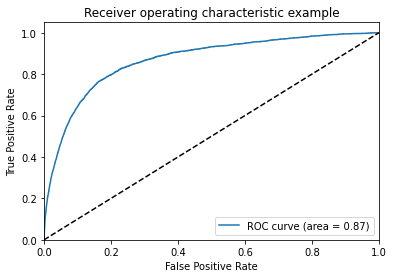

In [148]:
# ROC curve drawing
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predict_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],  'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Let's try to change the probability boundary at which the data belongs to a certain class and evaluate the result by confusion matrix.

In [149]:
y_pred = np.where(y_predict_prob[:, 1] > 0.1, 1, 0)

In [150]:
confusion_matrix(y_test, y_pred)

array([[185219,   4843],
       [  2592,   1263]], dtype=int64)

In [151]:
precision_score(y_test, y_pred, average='weighted')

0.9707056316696955

In [152]:
recall_score(y_test, y_pred, average='weighted')

0.9616588540458031

By shifting the probability limit quite a bit, we got a result that, from a business point of view, can satisfy us: we get about 1.2 thousand real conversions and 4.8 thousand false positive results for class 1.
It may not look like a success, but in reality we do not have much data about the user and the conversion in the system under study is not that high, so the model used can seriously improve performance.

### Modifying the Training Sample with SMOTE

Since we have a huge imbalance in the data, it makes sense to try to get rid of the imbalance using SMOTE. 

In [63]:
# transform the dataset
oversample = SMOTE()
X_trainSM, y_trainSM = oversample.fit_resample(X_train, y_train)

In [64]:
import collections
counter = collections.Counter(y_trainSM)
print(counter)

Counter({0: 190018, 1: 190018})


In [29]:
rf = RandomForestClassifier()
parametrs = {'n_estimators': range(20, 80, 10), 
             'max_depth': range(6,13, 2),
            'min_samples_leaf': range(2,7), 
             'min_samples_split': range(2,10, 2)}

In [30]:
search = RandomizedSearchCV(rf, parametrs, n_iter=50, cv = 3, error_score='raise')
# search = GridSearchCV(rf, parametrs, cv = 3, n_jobs=-1)

In [32]:
search.fit(X_trainSM, y_trainSM)

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'max_depth': range(6, 13, 2),
                                        'min_samples_leaf': range(2, 7),
                                        'min_samples_split': range(2, 10, 2),
                                        'n_estimators': range(20, 80, 10)})

In [33]:
best_clf_rf = search.best_estimator_
best_clf_rf

RandomForestClassifier(max_depth=12, min_samples_leaf=4, n_estimators=60)

In [34]:
predictions = best_clf_rf.predict(X_test)i

In [36]:
y_predict_prob = best_clf_rf.predict_proba(X_test)

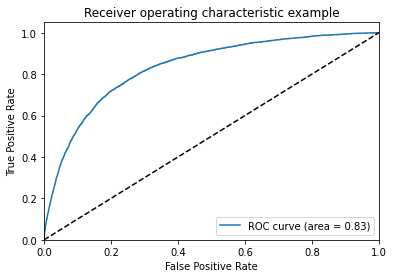

In [37]:
# Отрисовка ROC-кривой
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predict_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],  'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [50]:
y_pred = np.where(y_predict_prob[:, 1] > 0.4, 1, 0)

In [51]:
confusion_matrix(y_test, y_pred)

array([[153558,  36439],
       [  1146,   2774]], dtype=int64)

In [44]:
precision_score(y_test, y_pred, average='weighted')

0.9756959173197262

In [45]:
recall_score(y_test, y_pred, average='weighted')

0.6938690264391466

If we compare the learning outcomes with and without SMOTE, we can conclude that there is not much difference, the indicators have even become worse. 
Thus SMOTE makes no sense to use.

### XGBoost

In [55]:
xgb_class = xgb.XGBClassifier(use_label_encoder=False)
parameters = {'n_estimators': [100, 200, 300], # 100 200
             'max_depth': [5, 8],
             'learning_rate':[0.03],
             'reg_alpha': [2],
             'reg_lambda': [1]
             }

In [56]:
# search = RandomizedSearchCV(xgb_class, parameters, n_iter=20, cv = 2)
search = GridSearchCV(xgb_class, parametrs, cv = 2)

In [57]:
search.fit(X_train, y_train)

[16:14:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:14:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:14:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[16:16:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:16:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[16:18:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:18:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[16:21:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:21:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:21:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[16:23:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:23:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[16:25:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:25:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[16:27:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:27:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[16:28:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:28:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[16:30:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:30:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:30:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[16:31:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:31:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[16:32:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:32:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:32:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[16:34:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:34:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:34:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[16:35:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:35:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:35:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[16:36:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:36:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[16:38:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:38:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[16:39:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:39:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[16:40:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[16:42:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:42:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:42:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[16:43:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:43:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:43:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[16:45:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:45:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:45:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[16:46:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:46:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:46:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[16:47:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:47:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[16:49:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:49:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[16:50:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:50:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:50:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[16:51:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:51:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[16:53:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:53:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[16:54:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:54:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:54:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[16:55:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:56:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:56:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[16:57:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:57:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:57:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[16:58:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:58:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[16:59:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:59:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:00:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[17:01:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:01:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:01:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[17:02:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:02:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:02:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[17:04:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:04:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:04:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[17:06:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[17:08:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:08:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[17:10:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:10:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[17:11:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:11:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[17:13:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:13:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:13:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[17:15:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:15:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:15:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[17:17:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[17:18:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:19:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:19:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[17:20:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:20:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:21:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[17:22:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[17:24:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:24:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:24:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[17:25:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:26:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:26:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[17:27:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:27:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:27:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[17:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:29:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[17:31:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:31:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:31:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[17:32:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:32:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:32:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[17:34:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:34:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:34:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[17:36:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:36:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:36:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[17:37:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:37:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:37:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[17:39:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:39:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:39:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[17:41:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:41:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:41:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[17:42:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:43:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[17:44:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:44:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:44:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[17:46:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:46:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[17:48:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:48:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[17:49:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:50:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[17:51:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:51:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:52:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[17:53:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:54:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:54:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[17:55:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:55:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:55:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[17:57:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:57:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:57:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[18:00:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:00:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:00:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[18:02:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:02:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:02:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[18:04:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:04:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:05:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[18:07:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:07:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:07:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[18:09:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:09:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:09:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[18:12:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:12:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[18:14:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:15:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[18:17:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:17:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:17:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[18:20:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:20:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:20:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[18:22:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[18:25:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:25:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:25:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[18:27:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:28:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[18:30:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[18:32:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:32:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:32:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[18:34:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:34:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[18:36:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:37:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:37:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[18:39:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:39:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:39:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[18:41:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:41:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:41:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[18:44:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:44:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:44:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

[18:48:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:48:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:48:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

[18:52:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

KeyboardInterrupt: 

In [24]:
best_clf_xgb = search.best_estimator_
best_clf_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=2, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [25]:
predictions = best_clf_xgb.predict(X_test)

In [26]:
precision_score(y_test, predictions, average='weighted')

0.9747736948824073

In [27]:
recall_score(y_test, predictions, average='weighted')

0.9796820289092756

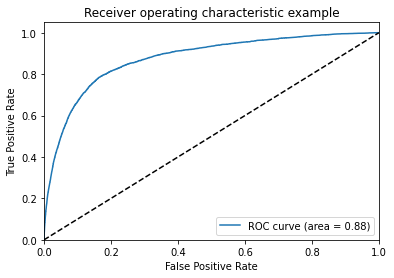

In [29]:
y_predict_prob = best_clf_xgb.predict_proba(X_test)
# Отрисовка ROC-кривой
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predict_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],  'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [44]:
y_pred = np.where(y_predict_prob[:, 1] > 0.1, 1, 0)

In [45]:
confusion_matrix(y_test, y_pred)

array([[182765,   7159],
       [  2267,   1726]], dtype=int64)

In [39]:
recall_score(y_test, y_pred, average='weighted')

0.9788105220274653

### catBoost

In [176]:
clf = CatBoostClassifier()
params = {'iterations': [500],
          'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 5, 7]
         }
scorer = make_scorer(accuracy_score)
clf_grid = GridSearchCV(estimator=clf, param_grid=params, scoring=scorer, cv=3)

In [177]:
clf_grid.fit(X_train, y_train)
best_param = clf_grid.best_params_
best_param

0:	learn: 0.6386639	total: 27.8ms	remaining: 13.9s
1:	learn: 0.5882272	total: 43.3ms	remaining: 10.8s
2:	learn: 0.5430033	total: 74.6ms	remaining: 12.4s
3:	learn: 0.5016273	total: 109ms	remaining: 13.5s
4:	learn: 0.4648886	total: 137ms	remaining: 13.5s
5:	learn: 0.4304719	total: 152ms	remaining: 12.5s
6:	learn: 0.3995269	total: 188ms	remaining: 13.2s
7:	learn: 0.3721498	total: 232ms	remaining: 14.3s
8:	learn: 0.3476439	total: 297ms	remaining: 16.2s
9:	learn: 0.3248991	total: 334ms	remaining: 16.4s
10:	learn: 0.3023586	total: 353ms	remaining: 15.7s
11:	learn: 0.2841699	total: 402ms	remaining: 16.3s
12:	learn: 0.2679664	total: 470ms	remaining: 17.6s
13:	learn: 0.2531385	total: 491ms	remaining: 17s
14:	learn: 0.2397739	total: 573ms	remaining: 18.5s
15:	learn: 0.2262618	total: 612ms	remaining: 18.5s
16:	learn: 0.2153866	total: 664ms	remaining: 18.9s
17:	learn: 0.2051135	total: 688ms	remaining: 18.4s
18:	learn: 0.1959171	total: 705ms	remaining: 17.8s
19:	learn: 0.1876640	total: 720ms	remain

165:	learn: 0.0814215	total: 6.23s	remaining: 12.5s
166:	learn: 0.0813867	total: 6.25s	remaining: 12.5s
167:	learn: 0.0813569	total: 6.27s	remaining: 12.4s
168:	learn: 0.0813198	total: 6.29s	remaining: 12.3s
169:	learn: 0.0813021	total: 6.34s	remaining: 12.3s
170:	learn: 0.0812696	total: 6.37s	remaining: 12.3s
171:	learn: 0.0812372	total: 6.4s	remaining: 12.2s
172:	learn: 0.0811947	total: 6.43s	remaining: 12.2s
173:	learn: 0.0811562	total: 6.45s	remaining: 12.1s
174:	learn: 0.0810960	total: 6.5s	remaining: 12.1s
175:	learn: 0.0810364	total: 6.55s	remaining: 12.1s
176:	learn: 0.0810000	total: 6.59s	remaining: 12s
177:	learn: 0.0809718	total: 6.66s	remaining: 12.1s
178:	learn: 0.0809366	total: 6.72s	remaining: 12.1s
179:	learn: 0.0809169	total: 6.78s	remaining: 12.1s
180:	learn: 0.0808771	total: 6.81s	remaining: 12s
181:	learn: 0.0808385	total: 6.84s	remaining: 12s
182:	learn: 0.0808205	total: 6.87s	remaining: 11.9s
183:	learn: 0.0807833	total: 6.88s	remaining: 11.8s
184:	learn: 0.080719

329:	learn: 0.0773216	total: 12.2s	remaining: 6.28s
330:	learn: 0.0772990	total: 12.2s	remaining: 6.25s
331:	learn: 0.0772882	total: 12.3s	remaining: 6.23s
332:	learn: 0.0772807	total: 12.3s	remaining: 6.19s
333:	learn: 0.0772224	total: 12.4s	remaining: 6.17s
334:	learn: 0.0772128	total: 12.4s	remaining: 6.12s
335:	learn: 0.0771715	total: 12.4s	remaining: 6.07s
336:	learn: 0.0771446	total: 12.5s	remaining: 6.03s
337:	learn: 0.0771275	total: 12.5s	remaining: 5.99s
338:	learn: 0.0770972	total: 12.5s	remaining: 5.95s
339:	learn: 0.0770849	total: 12.6s	remaining: 5.91s
340:	learn: 0.0770628	total: 12.6s	remaining: 5.86s
341:	learn: 0.0770237	total: 12.6s	remaining: 5.82s
342:	learn: 0.0769829	total: 12.6s	remaining: 5.77s
343:	learn: 0.0769701	total: 12.7s	remaining: 5.74s
344:	learn: 0.0769647	total: 12.7s	remaining: 5.69s
345:	learn: 0.0769354	total: 12.7s	remaining: 5.66s
346:	learn: 0.0769260	total: 12.8s	remaining: 5.63s
347:	learn: 0.0769033	total: 12.8s	remaining: 5.6s
348:	learn: 0

489:	learn: 0.0747669	total: 17.9s	remaining: 365ms
490:	learn: 0.0747557	total: 18s	remaining: 329ms
491:	learn: 0.0747511	total: 18s	remaining: 292ms
492:	learn: 0.0747397	total: 18s	remaining: 256ms
493:	learn: 0.0747297	total: 18.1s	remaining: 219ms
494:	learn: 0.0747145	total: 18.1s	remaining: 182ms
495:	learn: 0.0747084	total: 18.1s	remaining: 146ms
496:	learn: 0.0747022	total: 18.2s	remaining: 110ms
497:	learn: 0.0746957	total: 18.2s	remaining: 73.1ms
498:	learn: 0.0746872	total: 18.2s	remaining: 36.5ms
499:	learn: 0.0746786	total: 18.3s	remaining: 0us
0:	learn: 0.6386958	total: 35.9ms	remaining: 17.9s
1:	learn: 0.5874617	total: 60.9ms	remaining: 15.2s
2:	learn: 0.5405674	total: 89.9ms	remaining: 14.9s
3:	learn: 0.5000314	total: 105ms	remaining: 13.1s
4:	learn: 0.4634052	total: 119ms	remaining: 11.8s
5:	learn: 0.4291678	total: 135ms	remaining: 11.1s
6:	learn: 0.3984189	total: 150ms	remaining: 10.6s
7:	learn: 0.3709631	total: 174ms	remaining: 10.7s
8:	learn: 0.3464757	total: 207m

152:	learn: 0.0820815	total: 5s	remaining: 11.3s
153:	learn: 0.0820494	total: 5.04s	remaining: 11.3s
154:	learn: 0.0820058	total: 5.09s	remaining: 11.3s
155:	learn: 0.0819361	total: 5.14s	remaining: 11.3s
156:	learn: 0.0818917	total: 5.18s	remaining: 11.3s
157:	learn: 0.0818349	total: 5.22s	remaining: 11.3s
158:	learn: 0.0817969	total: 5.24s	remaining: 11.2s
159:	learn: 0.0817792	total: 5.25s	remaining: 11.2s
160:	learn: 0.0817592	total: 5.3s	remaining: 11.2s
161:	learn: 0.0817185	total: 5.35s	remaining: 11.2s
162:	learn: 0.0816992	total: 5.39s	remaining: 11.2s
163:	learn: 0.0816757	total: 5.45s	remaining: 11.2s
164:	learn: 0.0816586	total: 5.47s	remaining: 11.1s
165:	learn: 0.0816067	total: 5.54s	remaining: 11.1s
166:	learn: 0.0815778	total: 5.57s	remaining: 11.1s
167:	learn: 0.0815160	total: 5.6s	remaining: 11.1s
168:	learn: 0.0814819	total: 5.62s	remaining: 11s
169:	learn: 0.0814034	total: 5.65s	remaining: 11s
170:	learn: 0.0813709	total: 5.67s	remaining: 10.9s
171:	learn: 0.0813232

316:	learn: 0.0776319	total: 10.6s	remaining: 6.15s
317:	learn: 0.0775971	total: 10.7s	remaining: 6.11s
318:	learn: 0.0775795	total: 10.7s	remaining: 6.08s
319:	learn: 0.0775650	total: 10.8s	remaining: 6.07s
320:	learn: 0.0775410	total: 10.8s	remaining: 6.03s
321:	learn: 0.0775171	total: 10.8s	remaining: 5.99s
322:	learn: 0.0774862	total: 10.9s	remaining: 5.95s
323:	learn: 0.0774719	total: 10.9s	remaining: 5.91s
324:	learn: 0.0774511	total: 10.9s	remaining: 5.89s
325:	learn: 0.0774445	total: 11s	remaining: 5.86s
326:	learn: 0.0774281	total: 11s	remaining: 5.83s
327:	learn: 0.0773891	total: 11.1s	remaining: 5.81s
328:	learn: 0.0773803	total: 11.1s	remaining: 5.78s
329:	learn: 0.0773666	total: 11.2s	remaining: 5.75s
330:	learn: 0.0773411	total: 11.2s	remaining: 5.71s
331:	learn: 0.0773268	total: 11.2s	remaining: 5.67s
332:	learn: 0.0772868	total: 11.2s	remaining: 5.63s
333:	learn: 0.0772748	total: 11.2s	remaining: 5.59s
334:	learn: 0.0772541	total: 11.3s	remaining: 5.55s
335:	learn: 0.07

482:	learn: 0.0750435	total: 16.3s	remaining: 574ms
483:	learn: 0.0750267	total: 16.3s	remaining: 540ms
484:	learn: 0.0750096	total: 16.4s	remaining: 506ms
485:	learn: 0.0750026	total: 16.4s	remaining: 472ms
486:	learn: 0.0749934	total: 16.4s	remaining: 438ms
487:	learn: 0.0749880	total: 16.4s	remaining: 403ms
488:	learn: 0.0749801	total: 16.4s	remaining: 369ms
489:	learn: 0.0749731	total: 16.4s	remaining: 336ms
490:	learn: 0.0749681	total: 16.5s	remaining: 302ms
491:	learn: 0.0749512	total: 16.5s	remaining: 268ms
492:	learn: 0.0749402	total: 16.5s	remaining: 234ms
493:	learn: 0.0749316	total: 16.5s	remaining: 201ms
494:	learn: 0.0749191	total: 16.5s	remaining: 167ms
495:	learn: 0.0749061	total: 16.6s	remaining: 134ms
496:	learn: 0.0748959	total: 16.6s	remaining: 100ms
497:	learn: 0.0748800	total: 16.7s	remaining: 66.9ms
498:	learn: 0.0748714	total: 16.7s	remaining: 33.5ms
499:	learn: 0.0748626	total: 16.7s	remaining: 0us
0:	learn: 0.6385979	total: 36.2ms	remaining: 18.1s
1:	learn: 0.5

147:	learn: 0.0820585	total: 5s	remaining: 11.9s
148:	learn: 0.0820283	total: 5.02s	remaining: 11.8s
149:	learn: 0.0819859	total: 5.05s	remaining: 11.8s
150:	learn: 0.0819519	total: 5.1s	remaining: 11.8s
151:	learn: 0.0819074	total: 5.15s	remaining: 11.8s
152:	learn: 0.0818867	total: 5.17s	remaining: 11.7s
153:	learn: 0.0818578	total: 5.19s	remaining: 11.7s
154:	learn: 0.0817948	total: 5.21s	remaining: 11.6s
155:	learn: 0.0817106	total: 5.22s	remaining: 11.5s
156:	learn: 0.0816787	total: 5.24s	remaining: 11.4s
157:	learn: 0.0816022	total: 5.3s	remaining: 11.5s
158:	learn: 0.0815656	total: 5.34s	remaining: 11.4s
159:	learn: 0.0815371	total: 5.36s	remaining: 11.4s
160:	learn: 0.0814988	total: 5.39s	remaining: 11.4s
161:	learn: 0.0814275	total: 5.46s	remaining: 11.4s
162:	learn: 0.0813818	total: 5.48s	remaining: 11.3s
163:	learn: 0.0813011	total: 5.52s	remaining: 11.3s
164:	learn: 0.0812505	total: 5.53s	remaining: 11.2s
165:	learn: 0.0812254	total: 5.55s	remaining: 11.2s
166:	learn: 0.081

311:	learn: 0.0773533	total: 10.4s	remaining: 6.29s
312:	learn: 0.0773469	total: 10.4s	remaining: 6.24s
313:	learn: 0.0773364	total: 10.5s	remaining: 6.23s
314:	learn: 0.0773287	total: 10.5s	remaining: 6.19s
315:	learn: 0.0773177	total: 10.6s	remaining: 6.16s
316:	learn: 0.0772995	total: 10.6s	remaining: 6.12s
317:	learn: 0.0772814	total: 10.6s	remaining: 6.08s
318:	learn: 0.0772462	total: 10.7s	remaining: 6.04s
319:	learn: 0.0772334	total: 10.7s	remaining: 6.02s
320:	learn: 0.0771903	total: 10.7s	remaining: 5.98s
321:	learn: 0.0771721	total: 10.7s	remaining: 5.93s
322:	learn: 0.0771595	total: 10.8s	remaining: 5.9s
323:	learn: 0.0771524	total: 10.8s	remaining: 5.85s
324:	learn: 0.0771408	total: 10.8s	remaining: 5.82s
325:	learn: 0.0771348	total: 10.8s	remaining: 5.78s
326:	learn: 0.0771020	total: 10.9s	remaining: 5.74s
327:	learn: 0.0770891	total: 10.9s	remaining: 5.7s
328:	learn: 0.0770824	total: 10.9s	remaining: 5.66s
329:	learn: 0.0770761	total: 10.9s	remaining: 5.62s
330:	learn: 0.

476:	learn: 0.0748419	total: 15.9s	remaining: 767ms
477:	learn: 0.0748279	total: 15.9s	remaining: 733ms
478:	learn: 0.0748216	total: 15.9s	remaining: 699ms
479:	learn: 0.0748064	total: 16s	remaining: 665ms
480:	learn: 0.0748012	total: 16s	remaining: 631ms
481:	learn: 0.0747884	total: 16s	remaining: 597ms
482:	learn: 0.0747706	total: 16s	remaining: 564ms
483:	learn: 0.0747398	total: 16.1s	remaining: 531ms
484:	learn: 0.0747315	total: 16.1s	remaining: 498ms
485:	learn: 0.0747262	total: 16.1s	remaining: 465ms
486:	learn: 0.0747069	total: 16.1s	remaining: 431ms
487:	learn: 0.0746948	total: 16.2s	remaining: 397ms
488:	learn: 0.0746858	total: 16.2s	remaining: 365ms
489:	learn: 0.0746794	total: 16.3s	remaining: 332ms
490:	learn: 0.0746674	total: 16.3s	remaining: 299ms
491:	learn: 0.0746610	total: 16.3s	remaining: 266ms
492:	learn: 0.0746321	total: 16.4s	remaining: 233ms
493:	learn: 0.0746207	total: 16.5s	remaining: 200ms
494:	learn: 0.0746144	total: 16.5s	remaining: 167ms
495:	learn: 0.074609

140:	learn: 0.0749988	total: 4.47s	remaining: 11.4s
141:	learn: 0.0749553	total: 4.49s	remaining: 11.3s
142:	learn: 0.0749215	total: 4.52s	remaining: 11.3s
143:	learn: 0.0748668	total: 4.55s	remaining: 11.2s
144:	learn: 0.0748394	total: 4.58s	remaining: 11.2s
145:	learn: 0.0748128	total: 4.61s	remaining: 11.2s
146:	learn: 0.0747772	total: 4.65s	remaining: 11.2s
147:	learn: 0.0747474	total: 4.72s	remaining: 11.2s
148:	learn: 0.0747182	total: 4.74s	remaining: 11.2s
149:	learn: 0.0746847	total: 4.79s	remaining: 11.2s
150:	learn: 0.0746503	total: 4.83s	remaining: 11.2s
151:	learn: 0.0745447	total: 4.88s	remaining: 11.2s
152:	learn: 0.0745001	total: 4.95s	remaining: 11.2s
153:	learn: 0.0744731	total: 4.97s	remaining: 11.2s
154:	learn: 0.0744591	total: 4.99s	remaining: 11.1s
155:	learn: 0.0744221	total: 5s	remaining: 11s
156:	learn: 0.0743980	total: 5.07s	remaining: 11.1s
157:	learn: 0.0743675	total: 5.11s	remaining: 11.1s
158:	learn: 0.0743539	total: 5.13s	remaining: 11s
159:	learn: 0.07433

303:	learn: 0.0710993	total: 9.63s	remaining: 6.21s
304:	learn: 0.0710901	total: 9.64s	remaining: 6.16s
305:	learn: 0.0710757	total: 9.67s	remaining: 6.13s
306:	learn: 0.0710611	total: 9.72s	remaining: 6.11s
307:	learn: 0.0710442	total: 9.77s	remaining: 6.09s
308:	learn: 0.0710239	total: 9.78s	remaining: 6.05s
309:	learn: 0.0709950	total: 9.83s	remaining: 6.03s
310:	learn: 0.0709829	total: 9.86s	remaining: 5.99s
311:	learn: 0.0709713	total: 9.87s	remaining: 5.95s
312:	learn: 0.0709569	total: 9.89s	remaining: 5.91s
313:	learn: 0.0709460	total: 9.94s	remaining: 5.89s
314:	learn: 0.0709326	total: 9.96s	remaining: 5.85s
315:	learn: 0.0709102	total: 9.98s	remaining: 5.81s
316:	learn: 0.0708911	total: 10s	remaining: 5.79s
317:	learn: 0.0708740	total: 10s	remaining: 5.75s
318:	learn: 0.0708591	total: 10.1s	remaining: 5.71s
319:	learn: 0.0708344	total: 10.1s	remaining: 5.69s
320:	learn: 0.0708136	total: 10.1s	remaining: 5.65s
321:	learn: 0.0707906	total: 10.2s	remaining: 5.63s
322:	learn: 0.07

463:	learn: 0.0686116	total: 15.2s	remaining: 1.18s
464:	learn: 0.0686004	total: 15.2s	remaining: 1.15s
465:	learn: 0.0685778	total: 15.3s	remaining: 1.11s
466:	learn: 0.0685615	total: 15.3s	remaining: 1.08s
467:	learn: 0.0685401	total: 15.3s	remaining: 1.04s
468:	learn: 0.0685269	total: 15.3s	remaining: 1.01s
469:	learn: 0.0685078	total: 15.4s	remaining: 983ms
470:	learn: 0.0684955	total: 15.4s	remaining: 949ms
471:	learn: 0.0684797	total: 15.5s	remaining: 917ms
472:	learn: 0.0684659	total: 15.5s	remaining: 886ms
473:	learn: 0.0684560	total: 15.6s	remaining: 855ms
474:	learn: 0.0684474	total: 15.6s	remaining: 822ms
475:	learn: 0.0684380	total: 15.7s	remaining: 790ms
476:	learn: 0.0684248	total: 15.7s	remaining: 756ms
477:	learn: 0.0684161	total: 15.7s	remaining: 723ms
478:	learn: 0.0684048	total: 15.7s	remaining: 689ms
479:	learn: 0.0683918	total: 15.8s	remaining: 657ms
480:	learn: 0.0683788	total: 15.8s	remaining: 624ms
481:	learn: 0.0683649	total: 15.8s	remaining: 590ms
482:	learn: 

124:	learn: 0.0759584	total: 4.32s	remaining: 13s
125:	learn: 0.0758796	total: 4.34s	remaining: 12.9s
126:	learn: 0.0758581	total: 4.36s	remaining: 12.8s
127:	learn: 0.0757943	total: 4.4s	remaining: 12.8s
128:	learn: 0.0757565	total: 4.42s	remaining: 12.7s
129:	learn: 0.0757054	total: 4.47s	remaining: 12.7s
130:	learn: 0.0756762	total: 4.49s	remaining: 12.6s
131:	learn: 0.0755741	total: 4.5s	remaining: 12.5s
132:	learn: 0.0755346	total: 4.53s	remaining: 12.5s
133:	learn: 0.0755086	total: 4.59s	remaining: 12.6s
134:	learn: 0.0754938	total: 4.62s	remaining: 12.5s
135:	learn: 0.0754256	total: 4.64s	remaining: 12.4s
136:	learn: 0.0753962	total: 4.7s	remaining: 12.5s
137:	learn: 0.0753596	total: 4.72s	remaining: 12.4s
138:	learn: 0.0752597	total: 4.75s	remaining: 12.3s
139:	learn: 0.0752125	total: 4.77s	remaining: 12.3s
140:	learn: 0.0751805	total: 4.79s	remaining: 12.2s
141:	learn: 0.0751602	total: 4.85s	remaining: 12.2s
142:	learn: 0.0751114	total: 4.88s	remaining: 12.2s
143:	learn: 0.075

284:	learn: 0.0713808	total: 9.91s	remaining: 7.48s
285:	learn: 0.0713541	total: 9.93s	remaining: 7.43s
286:	learn: 0.0713355	total: 9.95s	remaining: 7.38s
287:	learn: 0.0713137	total: 9.96s	remaining: 7.33s
288:	learn: 0.0712870	total: 10s	remaining: 7.33s
289:	learn: 0.0712545	total: 10.1s	remaining: 7.29s
290:	learn: 0.0712251	total: 10.1s	remaining: 7.24s
291:	learn: 0.0711928	total: 10.1s	remaining: 7.21s
292:	learn: 0.0711805	total: 10.1s	remaining: 7.16s
293:	learn: 0.0711645	total: 10.2s	remaining: 7.13s
294:	learn: 0.0711476	total: 10.2s	remaining: 7.11s
295:	learn: 0.0711317	total: 10.3s	remaining: 7.08s
296:	learn: 0.0711169	total: 10.3s	remaining: 7.05s
297:	learn: 0.0710986	total: 10.3s	remaining: 7.01s
298:	learn: 0.0710848	total: 10.4s	remaining: 6.97s
299:	learn: 0.0710710	total: 10.4s	remaining: 6.92s
300:	learn: 0.0710508	total: 10.4s	remaining: 6.87s
301:	learn: 0.0710378	total: 10.4s	remaining: 6.84s
302:	learn: 0.0710244	total: 10.5s	remaining: 6.8s
303:	learn: 0.0

443:	learn: 0.0688318	total: 15.3s	remaining: 1.93s
444:	learn: 0.0688116	total: 15.4s	remaining: 1.9s
445:	learn: 0.0687959	total: 15.4s	remaining: 1.86s
446:	learn: 0.0687904	total: 15.4s	remaining: 1.82s
447:	learn: 0.0687705	total: 15.5s	remaining: 1.79s
448:	learn: 0.0687574	total: 15.5s	remaining: 1.76s
449:	learn: 0.0687483	total: 15.5s	remaining: 1.72s
450:	learn: 0.0687372	total: 15.5s	remaining: 1.69s
451:	learn: 0.0687221	total: 15.6s	remaining: 1.65s
452:	learn: 0.0687159	total: 15.6s	remaining: 1.62s
453:	learn: 0.0687045	total: 15.6s	remaining: 1.58s
454:	learn: 0.0686856	total: 15.7s	remaining: 1.55s
455:	learn: 0.0686416	total: 15.7s	remaining: 1.51s
456:	learn: 0.0686273	total: 15.7s	remaining: 1.48s
457:	learn: 0.0686206	total: 15.7s	remaining: 1.44s
458:	learn: 0.0686129	total: 15.8s	remaining: 1.41s
459:	learn: 0.0686036	total: 15.8s	remaining: 1.37s
460:	learn: 0.0685980	total: 15.8s	remaining: 1.34s
461:	learn: 0.0685811	total: 15.9s	remaining: 1.3s
462:	learn: 0.

110:	learn: 0.0761217	total: 3.49s	remaining: 12.2s
111:	learn: 0.0761026	total: 3.52s	remaining: 12.2s
112:	learn: 0.0760588	total: 3.53s	remaining: 12.1s
113:	learn: 0.0759784	total: 3.58s	remaining: 12.1s
114:	learn: 0.0758315	total: 3.61s	remaining: 12.1s
115:	learn: 0.0758089	total: 3.66s	remaining: 12.1s
116:	learn: 0.0757665	total: 3.69s	remaining: 12.1s
117:	learn: 0.0757369	total: 3.71s	remaining: 12s
118:	learn: 0.0756576	total: 3.73s	remaining: 11.9s
119:	learn: 0.0755984	total: 3.75s	remaining: 11.9s
120:	learn: 0.0755792	total: 3.78s	remaining: 11.8s
121:	learn: 0.0755524	total: 3.82s	remaining: 11.8s
122:	learn: 0.0754797	total: 3.84s	remaining: 11.8s
123:	learn: 0.0754067	total: 3.88s	remaining: 11.8s
124:	learn: 0.0753618	total: 3.94s	remaining: 11.8s
125:	learn: 0.0753306	total: 3.99s	remaining: 11.8s
126:	learn: 0.0752626	total: 4.04s	remaining: 11.9s
127:	learn: 0.0752380	total: 4.09s	remaining: 11.9s
128:	learn: 0.0752010	total: 4.11s	remaining: 11.8s
129:	learn: 0.

270:	learn: 0.0713702	total: 8.71s	remaining: 7.36s
271:	learn: 0.0713590	total: 8.73s	remaining: 7.32s
272:	learn: 0.0713448	total: 8.78s	remaining: 7.3s
273:	learn: 0.0713315	total: 8.82s	remaining: 7.28s
274:	learn: 0.0713227	total: 8.87s	remaining: 7.26s
275:	learn: 0.0713012	total: 8.91s	remaining: 7.23s
276:	learn: 0.0712840	total: 8.93s	remaining: 7.19s
277:	learn: 0.0712700	total: 8.97s	remaining: 7.17s
278:	learn: 0.0712443	total: 9.02s	remaining: 7.15s
279:	learn: 0.0712204	total: 9.04s	remaining: 7.11s
280:	learn: 0.0711976	total: 9.06s	remaining: 7.06s
281:	learn: 0.0711767	total: 9.09s	remaining: 7.02s
282:	learn: 0.0711430	total: 9.11s	remaining: 6.98s
283:	learn: 0.0711054	total: 9.12s	remaining: 6.94s
284:	learn: 0.0710895	total: 9.14s	remaining: 6.89s
285:	learn: 0.0710730	total: 9.15s	remaining: 6.85s
286:	learn: 0.0710567	total: 9.17s	remaining: 6.8s
287:	learn: 0.0710374	total: 9.22s	remaining: 6.78s
288:	learn: 0.0710228	total: 9.24s	remaining: 6.74s
289:	learn: 0.

431:	learn: 0.0688518	total: 14.3s	remaining: 2.24s
432:	learn: 0.0688340	total: 14.3s	remaining: 2.21s
433:	learn: 0.0688184	total: 14.3s	remaining: 2.18s
434:	learn: 0.0688079	total: 14.4s	remaining: 2.14s
435:	learn: 0.0687822	total: 14.4s	remaining: 2.11s
436:	learn: 0.0687754	total: 14.5s	remaining: 2.08s
437:	learn: 0.0687603	total: 14.5s	remaining: 2.05s
438:	learn: 0.0687506	total: 14.5s	remaining: 2.02s
439:	learn: 0.0687352	total: 14.6s	remaining: 1.99s
440:	learn: 0.0687299	total: 14.6s	remaining: 1.95s
441:	learn: 0.0687078	total: 14.6s	remaining: 1.92s
442:	learn: 0.0686931	total: 14.7s	remaining: 1.89s
443:	learn: 0.0686767	total: 14.7s	remaining: 1.85s
444:	learn: 0.0686619	total: 14.7s	remaining: 1.82s
445:	learn: 0.0686488	total: 14.8s	remaining: 1.79s
446:	learn: 0.0686413	total: 14.8s	remaining: 1.76s
447:	learn: 0.0686327	total: 14.9s	remaining: 1.73s
448:	learn: 0.0686235	total: 14.9s	remaining: 1.69s
449:	learn: 0.0686110	total: 15s	remaining: 1.66s
450:	learn: 0.

92:	learn: 0.0856314	total: 2.61s	remaining: 11.4s
93:	learn: 0.0855066	total: 2.63s	remaining: 11.4s
94:	learn: 0.0853653	total: 2.68s	remaining: 11.4s
95:	learn: 0.0852447	total: 2.72s	remaining: 11.4s
96:	learn: 0.0851158	total: 2.77s	remaining: 11.5s
97:	learn: 0.0850347	total: 2.79s	remaining: 11.5s
98:	learn: 0.0849718	total: 2.82s	remaining: 11.4s
99:	learn: 0.0848592	total: 2.84s	remaining: 11.4s
100:	learn: 0.0848034	total: 2.86s	remaining: 11.3s
101:	learn: 0.0847407	total: 2.87s	remaining: 11.2s
102:	learn: 0.0846373	total: 2.92s	remaining: 11.3s
103:	learn: 0.0845237	total: 2.94s	remaining: 11.2s
104:	learn: 0.0844601	total: 2.98s	remaining: 11.2s
105:	learn: 0.0843627	total: 3s	remaining: 11.1s
106:	learn: 0.0842955	total: 3.06s	remaining: 11.2s
107:	learn: 0.0842051	total: 3.12s	remaining: 11.3s
108:	learn: 0.0841347	total: 3.15s	remaining: 11.3s
109:	learn: 0.0840888	total: 3.2s	remaining: 11.3s
110:	learn: 0.0840131	total: 3.22s	remaining: 11.3s
111:	learn: 0.0839381	to

253:	learn: 0.0788945	total: 7.8s	remaining: 7.55s
254:	learn: 0.0788706	total: 7.85s	remaining: 7.54s
255:	learn: 0.0788404	total: 7.88s	remaining: 7.51s
256:	learn: 0.0788118	total: 7.93s	remaining: 7.5s
257:	learn: 0.0787912	total: 7.95s	remaining: 7.46s
258:	learn: 0.0787607	total: 8s	remaining: 7.44s
259:	learn: 0.0787221	total: 8.03s	remaining: 7.41s
260:	learn: 0.0787015	total: 8.07s	remaining: 7.39s
261:	learn: 0.0786514	total: 8.12s	remaining: 7.38s
262:	learn: 0.0786382	total: 8.16s	remaining: 7.36s
263:	learn: 0.0786065	total: 8.23s	remaining: 7.36s
264:	learn: 0.0785853	total: 8.26s	remaining: 7.33s
265:	learn: 0.0785322	total: 8.3s	remaining: 7.3s
266:	learn: 0.0785219	total: 8.35s	remaining: 7.29s
267:	learn: 0.0784998	total: 8.37s	remaining: 7.25s
268:	learn: 0.0784752	total: 8.4s	remaining: 7.21s
269:	learn: 0.0784430	total: 8.43s	remaining: 7.18s
270:	learn: 0.0784221	total: 8.45s	remaining: 7.14s
271:	learn: 0.0783543	total: 8.48s	remaining: 7.11s
272:	learn: 0.078341

416:	learn: 0.0759455	total: 13.3s	remaining: 2.64s
417:	learn: 0.0759265	total: 13.3s	remaining: 2.61s
418:	learn: 0.0759191	total: 13.4s	remaining: 2.58s
419:	learn: 0.0759120	total: 13.4s	remaining: 2.55s
420:	learn: 0.0759063	total: 13.4s	remaining: 2.52s
421:	learn: 0.0758887	total: 13.5s	remaining: 2.5s
422:	learn: 0.0758791	total: 13.5s	remaining: 2.46s
423:	learn: 0.0758527	total: 13.5s	remaining: 2.42s
424:	learn: 0.0758176	total: 13.5s	remaining: 2.39s
425:	learn: 0.0757967	total: 13.6s	remaining: 2.36s
426:	learn: 0.0757848	total: 13.6s	remaining: 2.33s
427:	learn: 0.0757698	total: 13.6s	remaining: 2.29s
428:	learn: 0.0757387	total: 13.7s	remaining: 2.27s
429:	learn: 0.0757316	total: 13.8s	remaining: 2.24s
430:	learn: 0.0757256	total: 13.8s	remaining: 2.21s
431:	learn: 0.0757160	total: 13.8s	remaining: 2.17s
432:	learn: 0.0756978	total: 13.8s	remaining: 2.14s
433:	learn: 0.0756655	total: 13.9s	remaining: 2.11s
434:	learn: 0.0756570	total: 13.9s	remaining: 2.08s
435:	learn: 0

76:	learn: 0.0881230	total: 2.36s	remaining: 13s
77:	learn: 0.0879742	total: 2.38s	remaining: 12.9s
78:	learn: 0.0877688	total: 2.42s	remaining: 12.9s
79:	learn: 0.0876249	total: 2.43s	remaining: 12.8s
80:	learn: 0.0874256	total: 2.48s	remaining: 12.9s
81:	learn: 0.0872460	total: 2.54s	remaining: 13s
82:	learn: 0.0870692	total: 2.57s	remaining: 12.9s
83:	learn: 0.0869564	total: 2.62s	remaining: 13s
84:	learn: 0.0868235	total: 2.66s	remaining: 13s
85:	learn: 0.0866968	total: 2.71s	remaining: 13.1s
86:	learn: 0.0865602	total: 2.73s	remaining: 13s
87:	learn: 0.0864399	total: 2.76s	remaining: 12.9s
88:	learn: 0.0863281	total: 2.78s	remaining: 12.9s
89:	learn: 0.0861890	total: 2.84s	remaining: 12.9s
90:	learn: 0.0860912	total: 2.86s	remaining: 12.8s
91:	learn: 0.0859428	total: 2.87s	remaining: 12.7s
92:	learn: 0.0857960	total: 2.9s	remaining: 12.7s
93:	learn: 0.0856938	total: 2.93s	remaining: 12.7s
94:	learn: 0.0856015	total: 2.95s	remaining: 12.6s
95:	learn: 0.0855193	total: 3.03s	remainin

239:	learn: 0.0793616	total: 8.03s	remaining: 8.7s
240:	learn: 0.0793167	total: 8.05s	remaining: 8.65s
241:	learn: 0.0793012	total: 8.06s	remaining: 8.59s
242:	learn: 0.0792750	total: 8.13s	remaining: 8.6s
243:	learn: 0.0792398	total: 8.16s	remaining: 8.56s
244:	learn: 0.0792219	total: 8.18s	remaining: 8.52s
245:	learn: 0.0792049	total: 8.21s	remaining: 8.47s
246:	learn: 0.0791903	total: 8.24s	remaining: 8.44s
247:	learn: 0.0791686	total: 8.27s	remaining: 8.4s
248:	learn: 0.0791208	total: 8.3s	remaining: 8.37s
249:	learn: 0.0790970	total: 8.36s	remaining: 8.36s
250:	learn: 0.0790846	total: 8.39s	remaining: 8.32s
251:	learn: 0.0790723	total: 8.43s	remaining: 8.3s
252:	learn: 0.0790395	total: 8.45s	remaining: 8.25s
253:	learn: 0.0790171	total: 8.48s	remaining: 8.22s
254:	learn: 0.0789975	total: 8.54s	remaining: 8.21s
255:	learn: 0.0789911	total: 8.57s	remaining: 8.17s
256:	learn: 0.0789752	total: 8.59s	remaining: 8.13s
257:	learn: 0.0789553	total: 8.65s	remaining: 8.11s
258:	learn: 0.078

399:	learn: 0.0764088	total: 13.2s	remaining: 3.31s
400:	learn: 0.0763968	total: 13.3s	remaining: 3.27s
401:	learn: 0.0763897	total: 13.3s	remaining: 3.24s
402:	learn: 0.0763728	total: 13.4s	remaining: 3.21s
403:	learn: 0.0763485	total: 13.4s	remaining: 3.18s
404:	learn: 0.0763342	total: 13.4s	remaining: 3.15s
405:	learn: 0.0763267	total: 13.5s	remaining: 3.12s
406:	learn: 0.0763162	total: 13.5s	remaining: 3.08s
407:	learn: 0.0763049	total: 13.5s	remaining: 3.05s
408:	learn: 0.0762941	total: 13.6s	remaining: 3.02s
409:	learn: 0.0762654	total: 13.6s	remaining: 2.99s
410:	learn: 0.0762538	total: 13.7s	remaining: 2.96s
411:	learn: 0.0762262	total: 13.7s	remaining: 2.92s
412:	learn: 0.0762101	total: 13.8s	remaining: 2.9s
413:	learn: 0.0761878	total: 13.8s	remaining: 2.86s
414:	learn: 0.0761697	total: 13.8s	remaining: 2.83s
415:	learn: 0.0761486	total: 13.9s	remaining: 2.8s
416:	learn: 0.0761358	total: 13.9s	remaining: 2.76s
417:	learn: 0.0761258	total: 13.9s	remaining: 2.73s
418:	learn: 0.

63:	learn: 0.0909752	total: 2.1s	remaining: 14.3s
64:	learn: 0.0907220	total: 2.11s	remaining: 14.1s
65:	learn: 0.0903783	total: 2.14s	remaining: 14.1s
66:	learn: 0.0901326	total: 2.21s	remaining: 14.3s
67:	learn: 0.0898916	total: 2.25s	remaining: 14.3s
68:	learn: 0.0896128	total: 2.26s	remaining: 14.1s
69:	learn: 0.0893716	total: 2.28s	remaining: 14s
70:	learn: 0.0891393	total: 2.3s	remaining: 13.9s
71:	learn: 0.0889432	total: 2.32s	remaining: 13.8s
72:	learn: 0.0886477	total: 2.34s	remaining: 13.7s
73:	learn: 0.0884380	total: 2.35s	remaining: 13.5s
74:	learn: 0.0882774	total: 2.4s	remaining: 13.6s
75:	learn: 0.0880905	total: 2.44s	remaining: 13.6s
76:	learn: 0.0879365	total: 2.46s	remaining: 13.5s
77:	learn: 0.0877456	total: 2.51s	remaining: 13.6s
78:	learn: 0.0875225	total: 2.53s	remaining: 13.5s
79:	learn: 0.0873152	total: 2.55s	remaining: 13.4s
80:	learn: 0.0871825	total: 2.62s	remaining: 13.5s
81:	learn: 0.0870472	total: 2.65s	remaining: 13.5s
82:	learn: 0.0869117	total: 2.67s	re

226:	learn: 0.0796106	total: 7.25s	remaining: 8.72s
227:	learn: 0.0795992	total: 7.28s	remaining: 8.68s
228:	learn: 0.0795584	total: 7.33s	remaining: 8.67s
229:	learn: 0.0795334	total: 7.39s	remaining: 8.67s
230:	learn: 0.0795078	total: 7.43s	remaining: 8.66s
231:	learn: 0.0794882	total: 7.49s	remaining: 8.65s
232:	learn: 0.0794707	total: 7.51s	remaining: 8.61s
233:	learn: 0.0794517	total: 7.57s	remaining: 8.61s
234:	learn: 0.0794172	total: 7.62s	remaining: 8.59s
235:	learn: 0.0793777	total: 7.64s	remaining: 8.54s
236:	learn: 0.0793532	total: 7.7s	remaining: 8.54s
237:	learn: 0.0793433	total: 7.75s	remaining: 8.53s
238:	learn: 0.0793254	total: 7.78s	remaining: 8.5s
239:	learn: 0.0793151	total: 7.81s	remaining: 8.46s
240:	learn: 0.0793018	total: 7.84s	remaining: 8.42s
241:	learn: 0.0792909	total: 7.85s	remaining: 8.37s
242:	learn: 0.0792385	total: 7.89s	remaining: 8.35s
243:	learn: 0.0792039	total: 7.91s	remaining: 8.3s
244:	learn: 0.0791531	total: 7.96s	remaining: 8.28s
245:	learn: 0.0

390:	learn: 0.0762356	total: 13s	remaining: 3.62s
391:	learn: 0.0762139	total: 13s	remaining: 3.58s
392:	learn: 0.0762084	total: 13s	remaining: 3.55s
393:	learn: 0.0761880	total: 13s	remaining: 3.51s
394:	learn: 0.0761834	total: 13.1s	remaining: 3.48s
395:	learn: 0.0761573	total: 13.1s	remaining: 3.45s
396:	learn: 0.0761480	total: 13.2s	remaining: 3.42s
397:	learn: 0.0761374	total: 13.2s	remaining: 3.38s
398:	learn: 0.0761296	total: 13.3s	remaining: 3.35s
399:	learn: 0.0761085	total: 13.3s	remaining: 3.33s
400:	learn: 0.0760961	total: 13.3s	remaining: 3.29s
401:	learn: 0.0760741	total: 13.3s	remaining: 3.25s
402:	learn: 0.0760430	total: 13.4s	remaining: 3.22s
403:	learn: 0.0760135	total: 13.4s	remaining: 3.18s
404:	learn: 0.0760130	total: 13.4s	remaining: 3.14s
405:	learn: 0.0760071	total: 13.5s	remaining: 3.12s
406:	learn: 0.0760016	total: 13.5s	remaining: 3.09s
407:	learn: 0.0759918	total: 13.5s	remaining: 3.05s
408:	learn: 0.0759664	total: 13.6s	remaining: 3.02s
409:	learn: 0.075942

54:	learn: 0.0808586	total: 1.79s	remaining: 14.5s
55:	learn: 0.0807582	total: 1.81s	remaining: 14.3s
56:	learn: 0.0806258	total: 1.85s	remaining: 14.4s
57:	learn: 0.0805534	total: 1.9s	remaining: 14.5s
58:	learn: 0.0805031	total: 1.95s	remaining: 14.5s
59:	learn: 0.0804206	total: 2s	remaining: 14.6s
60:	learn: 0.0803520	total: 2.04s	remaining: 14.6s
61:	learn: 0.0802678	total: 2.06s	remaining: 14.6s
62:	learn: 0.0802110	total: 2.09s	remaining: 14.5s
63:	learn: 0.0800821	total: 2.11s	remaining: 14.4s
64:	learn: 0.0799865	total: 2.12s	remaining: 14.2s
65:	learn: 0.0799404	total: 2.14s	remaining: 14.1s
66:	learn: 0.0797602	total: 2.16s	remaining: 14s
67:	learn: 0.0796829	total: 2.2s	remaining: 14s
68:	learn: 0.0796402	total: 2.22s	remaining: 13.9s
69:	learn: 0.0795505	total: 2.23s	remaining: 13.7s
70:	learn: 0.0794036	total: 2.25s	remaining: 13.6s
71:	learn: 0.0793461	total: 2.29s	remaining: 13.6s
72:	learn: 0.0793036	total: 2.34s	remaining: 13.7s
73:	learn: 0.0792725	total: 2.39s	remain

214:	learn: 0.0731404	total: 7s	remaining: 9.28s
215:	learn: 0.0731216	total: 7.03s	remaining: 9.24s
216:	learn: 0.0730949	total: 7.05s	remaining: 9.2s
217:	learn: 0.0730546	total: 7.1s	remaining: 9.19s
218:	learn: 0.0730354	total: 7.15s	remaining: 9.17s
219:	learn: 0.0730213	total: 7.21s	remaining: 9.18s
220:	learn: 0.0730052	total: 7.24s	remaining: 9.14s
221:	learn: 0.0729660	total: 7.26s	remaining: 9.09s
222:	learn: 0.0729302	total: 7.28s	remaining: 9.04s
223:	learn: 0.0729051	total: 7.29s	remaining: 8.99s
224:	learn: 0.0728926	total: 7.32s	remaining: 8.95s
225:	learn: 0.0728673	total: 7.34s	remaining: 8.9s
226:	learn: 0.0728436	total: 7.36s	remaining: 8.85s
227:	learn: 0.0728253	total: 7.38s	remaining: 8.8s
228:	learn: 0.0728183	total: 7.41s	remaining: 8.77s
229:	learn: 0.0728076	total: 7.43s	remaining: 8.72s
230:	learn: 0.0727969	total: 7.46s	remaining: 8.68s
231:	learn: 0.0727914	total: 7.51s	remaining: 8.68s
232:	learn: 0.0727599	total: 7.56s	remaining: 8.66s
233:	learn: 0.07274

374:	learn: 0.0704613	total: 12.1s	remaining: 4.03s
375:	learn: 0.0704524	total: 12.1s	remaining: 4s
376:	learn: 0.0704424	total: 12.2s	remaining: 3.97s
377:	learn: 0.0704411	total: 12.2s	remaining: 3.94s
378:	learn: 0.0704234	total: 12.3s	remaining: 3.91s
379:	learn: 0.0704094	total: 12.3s	remaining: 3.88s
380:	learn: 0.0703971	total: 12.3s	remaining: 3.84s
381:	learn: 0.0703808	total: 12.3s	remaining: 3.81s
382:	learn: 0.0703649	total: 12.4s	remaining: 3.79s
383:	learn: 0.0703595	total: 12.4s	remaining: 3.76s
384:	learn: 0.0703419	total: 12.5s	remaining: 3.73s
385:	learn: 0.0703296	total: 12.5s	remaining: 3.7s
386:	learn: 0.0703127	total: 12.5s	remaining: 3.66s
387:	learn: 0.0703018	total: 12.6s	remaining: 3.62s
388:	learn: 0.0702720	total: 12.6s	remaining: 3.59s
389:	learn: 0.0702500	total: 12.7s	remaining: 3.57s
390:	learn: 0.0702379	total: 12.7s	remaining: 3.53s
391:	learn: 0.0702192	total: 12.7s	remaining: 3.5s
392:	learn: 0.0702120	total: 12.7s	remaining: 3.47s
393:	learn: 0.070

42:	learn: 0.0825538	total: 1.06s	remaining: 11.2s
43:	learn: 0.0823396	total: 1.1s	remaining: 11.4s
44:	learn: 0.0822043	total: 1.16s	remaining: 11.7s
45:	learn: 0.0820366	total: 1.17s	remaining: 11.6s
46:	learn: 0.0818754	total: 1.19s	remaining: 11.5s
47:	learn: 0.0817770	total: 1.22s	remaining: 11.5s
48:	learn: 0.0816440	total: 1.25s	remaining: 11.5s
49:	learn: 0.0815109	total: 1.27s	remaining: 11.5s
50:	learn: 0.0813715	total: 1.32s	remaining: 11.6s
51:	learn: 0.0812528	total: 1.36s	remaining: 11.7s
52:	learn: 0.0811602	total: 1.38s	remaining: 11.7s
53:	learn: 0.0810727	total: 1.41s	remaining: 11.7s
54:	learn: 0.0809875	total: 1.45s	remaining: 11.8s
55:	learn: 0.0809197	total: 1.5s	remaining: 11.9s
56:	learn: 0.0808698	total: 1.55s	remaining: 12s
57:	learn: 0.0806608	total: 1.59s	remaining: 12.1s
58:	learn: 0.0805905	total: 1.64s	remaining: 12.3s
59:	learn: 0.0805171	total: 1.69s	remaining: 12.4s
60:	learn: 0.0803705	total: 1.74s	remaining: 12.5s
61:	learn: 0.0802356	total: 1.75s	r

203:	learn: 0.0733231	total: 6.54s	remaining: 9.49s
204:	learn: 0.0733139	total: 6.55s	remaining: 9.43s
205:	learn: 0.0732943	total: 6.58s	remaining: 9.39s
206:	learn: 0.0732653	total: 6.63s	remaining: 9.39s
207:	learn: 0.0732450	total: 6.67s	remaining: 9.37s
208:	learn: 0.0732264	total: 6.69s	remaining: 9.31s
209:	learn: 0.0732010	total: 6.76s	remaining: 9.33s
210:	learn: 0.0731820	total: 6.78s	remaining: 9.29s
211:	learn: 0.0731521	total: 6.83s	remaining: 9.28s
212:	learn: 0.0731095	total: 6.9s	remaining: 9.29s
213:	learn: 0.0730840	total: 6.93s	remaining: 9.26s
214:	learn: 0.0730559	total: 6.96s	remaining: 9.22s
215:	learn: 0.0730231	total: 6.98s	remaining: 9.18s
216:	learn: 0.0730187	total: 6.99s	remaining: 9.12s
217:	learn: 0.0729892	total: 7.01s	remaining: 9.07s
218:	learn: 0.0729554	total: 7.06s	remaining: 9.06s
219:	learn: 0.0728887	total: 7.09s	remaining: 9.02s
220:	learn: 0.0728718	total: 7.13s	remaining: 9.01s
221:	learn: 0.0728375	total: 7.19s	remaining: 9s
222:	learn: 0.07

362:	learn: 0.0703041	total: 11.8s	remaining: 4.46s
363:	learn: 0.0702951	total: 11.8s	remaining: 4.42s
364:	learn: 0.0702874	total: 11.9s	remaining: 4.39s
365:	learn: 0.0702773	total: 11.9s	remaining: 4.35s
366:	learn: 0.0702633	total: 11.9s	remaining: 4.32s
367:	learn: 0.0702472	total: 12s	remaining: 4.29s
368:	learn: 0.0702396	total: 12s	remaining: 4.26s
369:	learn: 0.0702262	total: 12s	remaining: 4.22s
370:	learn: 0.0702145	total: 12s	remaining: 4.18s
371:	learn: 0.0702104	total: 12s	remaining: 4.14s
372:	learn: 0.0702017	total: 12.1s	remaining: 4.11s
373:	learn: 0.0701881	total: 12.1s	remaining: 4.08s
374:	learn: 0.0701856	total: 12.2s	remaining: 4.05s
375:	learn: 0.0701768	total: 12.2s	remaining: 4.02s
376:	learn: 0.0701680	total: 12.2s	remaining: 3.99s
377:	learn: 0.0701538	total: 12.3s	remaining: 3.96s
378:	learn: 0.0701320	total: 12.3s	remaining: 3.92s
379:	learn: 0.0701138	total: 12.3s	remaining: 3.9s
380:	learn: 0.0700958	total: 12.4s	remaining: 3.87s
381:	learn: 0.0700816	t

23:	learn: 0.0867805	total: 661ms	remaining: 13.1s
24:	learn: 0.0862766	total: 683ms	remaining: 13s
25:	learn: 0.0858624	total: 733ms	remaining: 13.4s
26:	learn: 0.0855894	total: 775ms	remaining: 13.6s
27:	learn: 0.0851500	total: 824ms	remaining: 13.9s
28:	learn: 0.0849113	total: 863ms	remaining: 14s
29:	learn: 0.0846445	total: 884ms	remaining: 13.9s
30:	learn: 0.0844162	total: 898ms	remaining: 13.6s
31:	learn: 0.0842589	total: 911ms	remaining: 13.3s
32:	learn: 0.0840822	total: 936ms	remaining: 13.2s
33:	learn: 0.0838506	total: 964ms	remaining: 13.2s
34:	learn: 0.0836965	total: 994ms	remaining: 13.2s
35:	learn: 0.0834308	total: 1.03s	remaining: 13.3s
36:	learn: 0.0831250	total: 1.05s	remaining: 13.1s
37:	learn: 0.0829205	total: 1.1s	remaining: 13.4s
38:	learn: 0.0826163	total: 1.13s	remaining: 13.3s
39:	learn: 0.0824232	total: 1.16s	remaining: 13.3s
40:	learn: 0.0823185	total: 1.2s	remaining: 13.5s
41:	learn: 0.0822295	total: 1.26s	remaining: 13.8s
42:	learn: 0.0819780	total: 1.29s	rem

185:	learn: 0.0736825	total: 6.1s	remaining: 10.3s
186:	learn: 0.0736668	total: 6.13s	remaining: 10.3s
187:	learn: 0.0736438	total: 6.14s	remaining: 10.2s
188:	learn: 0.0736313	total: 6.21s	remaining: 10.2s
189:	learn: 0.0736063	total: 6.24s	remaining: 10.2s
190:	learn: 0.0735545	total: 6.31s	remaining: 10.2s
191:	learn: 0.0735177	total: 6.34s	remaining: 10.2s
192:	learn: 0.0735125	total: 6.36s	remaining: 10.1s
193:	learn: 0.0734794	total: 6.42s	remaining: 10.1s
194:	learn: 0.0734577	total: 6.46s	remaining: 10.1s
195:	learn: 0.0734569	total: 6.51s	remaining: 10.1s
196:	learn: 0.0734415	total: 6.53s	remaining: 10s
197:	learn: 0.0734408	total: 6.57s	remaining: 10s
198:	learn: 0.0734194	total: 6.58s	remaining: 9.96s
199:	learn: 0.0733671	total: 6.63s	remaining: 9.95s
200:	learn: 0.0733245	total: 6.68s	remaining: 9.93s
201:	learn: 0.0732967	total: 6.73s	remaining: 9.93s
202:	learn: 0.0732765	total: 6.75s	remaining: 9.88s
203:	learn: 0.0732568	total: 6.8s	remaining: 9.86s
204:	learn: 0.0732

345:	learn: 0.0707897	total: 12s	remaining: 5.36s
346:	learn: 0.0707610	total: 12.1s	remaining: 5.32s
347:	learn: 0.0707488	total: 12.1s	remaining: 5.27s
348:	learn: 0.0707311	total: 12.1s	remaining: 5.23s
349:	learn: 0.0707152	total: 12.1s	remaining: 5.18s
350:	learn: 0.0707042	total: 12.1s	remaining: 5.14s
351:	learn: 0.0706814	total: 12.2s	remaining: 5.12s
352:	learn: 0.0706564	total: 12.2s	remaining: 5.09s
353:	learn: 0.0706392	total: 12.2s	remaining: 5.05s
354:	learn: 0.0706188	total: 12.3s	remaining: 5.03s
355:	learn: 0.0705997	total: 12.3s	remaining: 4.99s
356:	learn: 0.0705824	total: 12.4s	remaining: 4.96s
357:	learn: 0.0705727	total: 12.4s	remaining: 4.93s
358:	learn: 0.0705534	total: 12.5s	remaining: 4.9s
359:	learn: 0.0705213	total: 12.5s	remaining: 4.85s
360:	learn: 0.0704982	total: 12.5s	remaining: 4.83s
361:	learn: 0.0704885	total: 12.6s	remaining: 4.79s
362:	learn: 0.0704777	total: 12.6s	remaining: 4.75s
363:	learn: 0.0704619	total: 12.6s	remaining: 4.72s
364:	learn: 0.0

6:	learn: 0.3980470	total: 240ms	remaining: 16.9s
7:	learn: 0.3699932	total: 279ms	remaining: 17.2s
8:	learn: 0.3455887	total: 311ms	remaining: 17s
9:	learn: 0.3220935	total: 340ms	remaining: 16.7s
10:	learn: 0.3021673	total: 355ms	remaining: 15.8s
11:	learn: 0.2842458	total: 367ms	remaining: 14.9s
12:	learn: 0.2679398	total: 428ms	remaining: 16s
13:	learn: 0.2527691	total: 475ms	remaining: 16.5s
14:	learn: 0.2390072	total: 494ms	remaining: 16s
15:	learn: 0.2267328	total: 549ms	remaining: 16.6s
16:	learn: 0.2154278	total: 578ms	remaining: 16.4s
17:	learn: 0.2055447	total: 595ms	remaining: 15.9s
18:	learn: 0.1960811	total: 657ms	remaining: 16.6s
19:	learn: 0.1876936	total: 688ms	remaining: 16.5s
20:	learn: 0.1787976	total: 722ms	remaining: 16.5s
21:	learn: 0.1706102	total: 749ms	remaining: 16.3s
22:	learn: 0.1646055	total: 782ms	remaining: 16.2s
23:	learn: 0.1587683	total: 810ms	remaining: 16.1s
24:	learn: 0.1525423	total: 847ms	remaining: 16.1s
25:	learn: 0.1479027	total: 902ms	remaini

167:	learn: 0.0814334	total: 5.44s	remaining: 10.7s
168:	learn: 0.0813914	total: 5.49s	remaining: 10.7s
169:	learn: 0.0813265	total: 5.51s	remaining: 10.7s
170:	learn: 0.0812814	total: 5.56s	remaining: 10.7s
171:	learn: 0.0812356	total: 5.61s	remaining: 10.7s
172:	learn: 0.0811973	total: 5.66s	remaining: 10.7s
173:	learn: 0.0811480	total: 5.67s	remaining: 10.6s
174:	learn: 0.0811150	total: 5.71s	remaining: 10.6s
175:	learn: 0.0810606	total: 5.73s	remaining: 10.5s
176:	learn: 0.0810370	total: 5.74s	remaining: 10.5s
177:	learn: 0.0810008	total: 5.77s	remaining: 10.4s
178:	learn: 0.0809528	total: 5.78s	remaining: 10.4s
179:	learn: 0.0808859	total: 5.81s	remaining: 10.3s
180:	learn: 0.0808531	total: 5.85s	remaining: 10.3s
181:	learn: 0.0808103	total: 5.88s	remaining: 10.3s
182:	learn: 0.0807655	total: 5.89s	remaining: 10.2s
183:	learn: 0.0807306	total: 5.92s	remaining: 10.2s
184:	learn: 0.0807051	total: 5.95s	remaining: 10.1s
185:	learn: 0.0806839	total: 5.98s	remaining: 10.1s
186:	learn: 

327:	learn: 0.0774351	total: 11.4s	remaining: 5.97s
328:	learn: 0.0773962	total: 11.4s	remaining: 5.93s
329:	learn: 0.0773801	total: 11.5s	remaining: 5.91s
330:	learn: 0.0773680	total: 11.5s	remaining: 5.87s
331:	learn: 0.0773554	total: 11.5s	remaining: 5.84s
332:	learn: 0.0773231	total: 11.6s	remaining: 5.81s
333:	learn: 0.0773151	total: 11.6s	remaining: 5.78s
334:	learn: 0.0773037	total: 11.7s	remaining: 5.75s
335:	learn: 0.0772931	total: 11.7s	remaining: 5.71s
336:	learn: 0.0772781	total: 11.7s	remaining: 5.67s
337:	learn: 0.0772334	total: 11.7s	remaining: 5.63s
338:	learn: 0.0772277	total: 11.8s	remaining: 5.59s
339:	learn: 0.0772165	total: 11.8s	remaining: 5.56s
340:	learn: 0.0772132	total: 11.8s	remaining: 5.51s
341:	learn: 0.0772030	total: 11.9s	remaining: 5.49s
342:	learn: 0.0771960	total: 11.9s	remaining: 5.46s
343:	learn: 0.0771847	total: 12s	remaining: 5.42s
344:	learn: 0.0771705	total: 12s	remaining: 5.4s
345:	learn: 0.0771613	total: 12.1s	remaining: 5.37s
346:	learn: 0.077

488:	learn: 0.0750020	total: 17.1s	remaining: 386ms
489:	learn: 0.0749917	total: 17.2s	remaining: 350ms
490:	learn: 0.0749663	total: 17.2s	remaining: 316ms
491:	learn: 0.0749543	total: 17.3s	remaining: 281ms
492:	learn: 0.0749401	total: 17.3s	remaining: 246ms
493:	learn: 0.0749323	total: 17.4s	remaining: 211ms
494:	learn: 0.0749199	total: 17.4s	remaining: 176ms
495:	learn: 0.0748839	total: 17.4s	remaining: 141ms
496:	learn: 0.0748752	total: 17.4s	remaining: 105ms
497:	learn: 0.0748662	total: 17.4s	remaining: 70.1ms
498:	learn: 0.0748545	total: 17.5s	remaining: 35ms
499:	learn: 0.0748377	total: 17.5s	remaining: 0us
0:	learn: 0.6387048	total: 60.5ms	remaining: 30.2s
1:	learn: 0.5874674	total: 77ms	remaining: 19.2s
2:	learn: 0.5408042	total: 107ms	remaining: 17.6s
3:	learn: 0.5002991	total: 122ms	remaining: 15.2s
4:	learn: 0.4636635	total: 137ms	remaining: 13.6s
5:	learn: 0.4294044	total: 152ms	remaining: 12.6s
6:	learn: 0.3983324	total: 167ms	remaining: 11.8s
7:	learn: 0.3711365	total: 2

150:	learn: 0.0821484	total: 4.67s	remaining: 10.8s
151:	learn: 0.0821199	total: 4.69s	remaining: 10.7s
152:	learn: 0.0820801	total: 4.71s	remaining: 10.7s
153:	learn: 0.0820162	total: 4.73s	remaining: 10.6s
154:	learn: 0.0819679	total: 4.77s	remaining: 10.6s
155:	learn: 0.0819334	total: 4.79s	remaining: 10.6s
156:	learn: 0.0818898	total: 4.8s	remaining: 10.5s
157:	learn: 0.0818663	total: 4.82s	remaining: 10.4s
158:	learn: 0.0818093	total: 4.83s	remaining: 10.4s
159:	learn: 0.0817783	total: 4.85s	remaining: 10.3s
160:	learn: 0.0817520	total: 4.86s	remaining: 10.2s
161:	learn: 0.0817120	total: 4.88s	remaining: 10.2s
162:	learn: 0.0816678	total: 4.9s	remaining: 10.1s
163:	learn: 0.0816142	total: 4.92s	remaining: 10.1s
164:	learn: 0.0815871	total: 4.96s	remaining: 10.1s
165:	learn: 0.0815674	total: 4.99s	remaining: 10s
166:	learn: 0.0815298	total: 5.01s	remaining: 10s
167:	learn: 0.0814804	total: 5.03s	remaining: 9.94s
168:	learn: 0.0814541	total: 5.05s	remaining: 9.88s
169:	learn: 0.0814

315:	learn: 0.0776650	total: 10.1s	remaining: 5.88s
316:	learn: 0.0776554	total: 10.1s	remaining: 5.85s
317:	learn: 0.0776430	total: 10.2s	remaining: 5.83s
318:	learn: 0.0776152	total: 10.3s	remaining: 5.82s
319:	learn: 0.0776080	total: 10.3s	remaining: 5.78s
320:	learn: 0.0775983	total: 10.3s	remaining: 5.75s
321:	learn: 0.0775711	total: 10.3s	remaining: 5.71s
322:	learn: 0.0775620	total: 10.3s	remaining: 5.66s
323:	learn: 0.0775494	total: 10.4s	remaining: 5.64s
324:	learn: 0.0775169	total: 10.4s	remaining: 5.61s
325:	learn: 0.0775045	total: 10.5s	remaining: 5.58s
326:	learn: 0.0774979	total: 10.5s	remaining: 5.56s
327:	learn: 0.0774611	total: 10.5s	remaining: 5.53s
328:	learn: 0.0774411	total: 10.6s	remaining: 5.51s
329:	learn: 0.0774262	total: 10.6s	remaining: 5.48s
330:	learn: 0.0774160	total: 10.7s	remaining: 5.45s
331:	learn: 0.0773847	total: 10.7s	remaining: 5.43s
332:	learn: 0.0773718	total: 10.8s	remaining: 5.42s
333:	learn: 0.0773593	total: 10.8s	remaining: 5.38s
334:	learn: 

476:	learn: 0.0752095	total: 15.8s	remaining: 764ms
477:	learn: 0.0752038	total: 15.9s	remaining: 730ms
478:	learn: 0.0751941	total: 15.9s	remaining: 699ms
479:	learn: 0.0751813	total: 16s	remaining: 665ms
480:	learn: 0.0751749	total: 16s	remaining: 632ms
481:	learn: 0.0751707	total: 16s	remaining: 598ms
482:	learn: 0.0751365	total: 16s	remaining: 564ms
483:	learn: 0.0751219	total: 16.1s	remaining: 531ms
484:	learn: 0.0751116	total: 16.1s	remaining: 497ms
485:	learn: 0.0751048	total: 16.1s	remaining: 464ms
486:	learn: 0.0750862	total: 16.1s	remaining: 430ms
487:	learn: 0.0750768	total: 16.2s	remaining: 397ms
488:	learn: 0.0750598	total: 16.2s	remaining: 364ms
489:	learn: 0.0750521	total: 16.2s	remaining: 330ms
490:	learn: 0.0750424	total: 16.2s	remaining: 297ms
491:	learn: 0.0750290	total: 16.2s	remaining: 264ms
492:	learn: 0.0750238	total: 16.3s	remaining: 231ms
493:	learn: 0.0750057	total: 16.3s	remaining: 198ms
494:	learn: 0.0750011	total: 16.3s	remaining: 165ms
495:	learn: 0.074992

139:	learn: 0.0825935	total: 4.58s	remaining: 11.8s
140:	learn: 0.0825635	total: 4.61s	remaining: 11.7s
141:	learn: 0.0825262	total: 4.62s	remaining: 11.7s
142:	learn: 0.0824864	total: 4.64s	remaining: 11.6s
143:	learn: 0.0824377	total: 4.71s	remaining: 11.6s
144:	learn: 0.0823919	total: 4.73s	remaining: 11.6s
145:	learn: 0.0823364	total: 4.75s	remaining: 11.5s
146:	learn: 0.0822934	total: 4.76s	remaining: 11.4s
147:	learn: 0.0822459	total: 4.78s	remaining: 11.4s
148:	learn: 0.0822002	total: 4.8s	remaining: 11.3s
149:	learn: 0.0821530	total: 4.84s	remaining: 11.3s
150:	learn: 0.0821097	total: 4.88s	remaining: 11.3s
151:	learn: 0.0820697	total: 4.93s	remaining: 11.3s
152:	learn: 0.0820459	total: 5s	remaining: 11.3s
153:	learn: 0.0819927	total: 5.03s	remaining: 11.3s
154:	learn: 0.0819397	total: 5.07s	remaining: 11.3s
155:	learn: 0.0819070	total: 5.08s	remaining: 11.2s
156:	learn: 0.0818575	total: 5.13s	remaining: 11.2s
157:	learn: 0.0818240	total: 5.18s	remaining: 11.2s
158:	learn: 0.08

302:	learn: 0.0777680	total: 9.46s	remaining: 6.15s
303:	learn: 0.0777558	total: 9.48s	remaining: 6.11s
304:	learn: 0.0777457	total: 9.5s	remaining: 6.08s
305:	learn: 0.0777392	total: 9.56s	remaining: 6.06s
306:	learn: 0.0777313	total: 9.6s	remaining: 6.04s
307:	learn: 0.0776962	total: 9.65s	remaining: 6.02s
308:	learn: 0.0776877	total: 9.68s	remaining: 5.98s
309:	learn: 0.0776805	total: 9.7s	remaining: 5.95s
310:	learn: 0.0776491	total: 9.76s	remaining: 5.93s
311:	learn: 0.0776345	total: 9.8s	remaining: 5.9s
312:	learn: 0.0776168	total: 9.82s	remaining: 5.87s
313:	learn: 0.0776078	total: 9.83s	remaining: 5.82s
314:	learn: 0.0776012	total: 9.85s	remaining: 5.78s
315:	learn: 0.0775888	total: 9.86s	remaining: 5.74s
316:	learn: 0.0775543	total: 9.92s	remaining: 5.72s
317:	learn: 0.0775407	total: 9.94s	remaining: 5.69s
318:	learn: 0.0775344	total: 9.99s	remaining: 5.67s
319:	learn: 0.0775218	total: 10s	remaining: 5.64s
320:	learn: 0.0775176	total: 10.1s	remaining: 5.62s
321:	learn: 0.07750

465:	learn: 0.0751626	total: 15.2s	remaining: 1.1s
466:	learn: 0.0751389	total: 15.2s	remaining: 1.07s
467:	learn: 0.0751321	total: 15.2s	remaining: 1.04s
468:	learn: 0.0751203	total: 15.3s	remaining: 1.01s
469:	learn: 0.0751001	total: 15.3s	remaining: 977ms
470:	learn: 0.0750811	total: 15.4s	remaining: 947ms
471:	learn: 0.0750575	total: 15.4s	remaining: 914ms
472:	learn: 0.0750400	total: 15.5s	remaining: 882ms
473:	learn: 0.0750379	total: 15.5s	remaining: 851ms
474:	learn: 0.0750284	total: 15.6s	remaining: 819ms
475:	learn: 0.0750240	total: 15.6s	remaining: 785ms
476:	learn: 0.0750210	total: 15.6s	remaining: 753ms
477:	learn: 0.0750207	total: 15.7s	remaining: 721ms
478:	learn: 0.0750050	total: 15.7s	remaining: 688ms
479:	learn: 0.0749744	total: 15.7s	remaining: 655ms
480:	learn: 0.0749605	total: 15.7s	remaining: 622ms
481:	learn: 0.0749445	total: 15.8s	remaining: 590ms
482:	learn: 0.0749441	total: 15.8s	remaining: 557ms
483:	learn: 0.0749349	total: 15.8s	remaining: 524ms
484:	learn: 0

130:	learn: 0.0756542	total: 4.58s	remaining: 12.9s
131:	learn: 0.0756016	total: 4.6s	remaining: 12.8s
132:	learn: 0.0755705	total: 4.62s	remaining: 12.7s
133:	learn: 0.0755214	total: 4.63s	remaining: 12.7s
134:	learn: 0.0754650	total: 4.69s	remaining: 12.7s
135:	learn: 0.0754320	total: 4.71s	remaining: 12.6s
136:	learn: 0.0753574	total: 4.73s	remaining: 12.5s
137:	learn: 0.0753271	total: 4.76s	remaining: 12.5s
138:	learn: 0.0752804	total: 4.82s	remaining: 12.5s
139:	learn: 0.0752476	total: 4.84s	remaining: 12.5s
140:	learn: 0.0752228	total: 4.9s	remaining: 12.5s
141:	learn: 0.0751751	total: 4.96s	remaining: 12.5s
142:	learn: 0.0751008	total: 5s	remaining: 12.5s
143:	learn: 0.0750539	total: 5.02s	remaining: 12.4s
144:	learn: 0.0750216	total: 5.07s	remaining: 12.4s
145:	learn: 0.0749921	total: 5.11s	remaining: 12.4s
146:	learn: 0.0749693	total: 5.16s	remaining: 12.4s
147:	learn: 0.0749494	total: 5.21s	remaining: 12.4s
148:	learn: 0.0748436	total: 5.24s	remaining: 12.4s
149:	learn: 0.074

295:	learn: 0.0714170	total: 10.1s	remaining: 6.97s
296:	learn: 0.0713896	total: 10.2s	remaining: 6.95s
297:	learn: 0.0713789	total: 10.2s	remaining: 6.93s
298:	learn: 0.0713611	total: 10.3s	remaining: 6.92s
299:	learn: 0.0713492	total: 10.4s	remaining: 6.91s
300:	learn: 0.0713354	total: 10.4s	remaining: 6.86s
301:	learn: 0.0713095	total: 10.5s	remaining: 6.85s
302:	learn: 0.0712877	total: 10.5s	remaining: 6.82s
303:	learn: 0.0712747	total: 10.5s	remaining: 6.79s
304:	learn: 0.0712610	total: 10.5s	remaining: 6.74s
305:	learn: 0.0712427	total: 10.6s	remaining: 6.72s
306:	learn: 0.0712313	total: 10.6s	remaining: 6.68s
307:	learn: 0.0711985	total: 10.7s	remaining: 6.65s
308:	learn: 0.0711743	total: 10.7s	remaining: 6.61s
309:	learn: 0.0711638	total: 10.7s	remaining: 6.56s
310:	learn: 0.0711613	total: 10.7s	remaining: 6.53s
311:	learn: 0.0711429	total: 10.8s	remaining: 6.49s
312:	learn: 0.0711239	total: 10.8s	remaining: 6.45s
313:	learn: 0.0710978	total: 10.9s	remaining: 6.43s
314:	learn: 

456:	learn: 0.0693602	total: 15.6s	remaining: 1.47s
457:	learn: 0.0693481	total: 15.6s	remaining: 1.43s
458:	learn: 0.0693460	total: 15.6s	remaining: 1.4s
459:	learn: 0.0693441	total: 15.7s	remaining: 1.36s
460:	learn: 0.0693342	total: 15.7s	remaining: 1.33s
461:	learn: 0.0693234	total: 15.8s	remaining: 1.3s
462:	learn: 0.0693204	total: 15.8s	remaining: 1.26s
463:	learn: 0.0693147	total: 15.8s	remaining: 1.23s
464:	learn: 0.0693016	total: 15.9s	remaining: 1.19s
465:	learn: 0.0692924	total: 15.9s	remaining: 1.16s
466:	learn: 0.0692888	total: 15.9s	remaining: 1.12s
467:	learn: 0.0692740	total: 15.9s	remaining: 1.09s
468:	learn: 0.0692580	total: 16s	remaining: 1.05s
469:	learn: 0.0692463	total: 16s	remaining: 1.02s
470:	learn: 0.0692352	total: 16s	remaining: 984ms
471:	learn: 0.0692237	total: 16s	remaining: 950ms
472:	learn: 0.0692114	total: 16s	remaining: 916ms
473:	learn: 0.0692013	total: 16.1s	remaining: 881ms
474:	learn: 0.0691909	total: 16.1s	remaining: 846ms
475:	learn: 0.0691769	to

122:	learn: 0.0760883	total: 4.2s	remaining: 12.9s
123:	learn: 0.0760409	total: 4.25s	remaining: 12.9s
124:	learn: 0.0759958	total: 4.31s	remaining: 12.9s
125:	learn: 0.0759254	total: 4.33s	remaining: 12.9s
126:	learn: 0.0758728	total: 4.38s	remaining: 12.9s
127:	learn: 0.0758426	total: 4.41s	remaining: 12.8s
128:	learn: 0.0758205	total: 4.42s	remaining: 12.7s
129:	learn: 0.0758038	total: 4.44s	remaining: 12.6s
130:	learn: 0.0757723	total: 4.49s	remaining: 12.7s
131:	learn: 0.0757296	total: 4.53s	remaining: 12.6s
132:	learn: 0.0756620	total: 4.57s	remaining: 12.6s
133:	learn: 0.0755879	total: 4.62s	remaining: 12.6s
134:	learn: 0.0755315	total: 4.65s	remaining: 12.6s
135:	learn: 0.0754946	total: 4.7s	remaining: 12.6s
136:	learn: 0.0754412	total: 4.75s	remaining: 12.6s
137:	learn: 0.0754168	total: 4.8s	remaining: 12.6s
138:	learn: 0.0753919	total: 4.84s	remaining: 12.6s
139:	learn: 0.0753556	total: 4.88s	remaining: 12.6s
140:	learn: 0.0753089	total: 4.9s	remaining: 12.5s
141:	learn: 0.07

284:	learn: 0.0719063	total: 9.81s	remaining: 7.4s
285:	learn: 0.0718900	total: 9.88s	remaining: 7.39s
286:	learn: 0.0718673	total: 9.91s	remaining: 7.35s
287:	learn: 0.0718542	total: 9.97s	remaining: 7.34s
288:	learn: 0.0718439	total: 10s	remaining: 7.31s
289:	learn: 0.0718215	total: 10s	remaining: 7.28s
290:	learn: 0.0718049	total: 10.1s	remaining: 7.23s
291:	learn: 0.0717942	total: 10.1s	remaining: 7.22s
292:	learn: 0.0717652	total: 10.2s	remaining: 7.18s
293:	learn: 0.0717530	total: 10.2s	remaining: 7.15s
294:	learn: 0.0717511	total: 10.2s	remaining: 7.1s
295:	learn: 0.0717410	total: 10.3s	remaining: 7.08s
296:	learn: 0.0717047	total: 10.3s	remaining: 7.04s
297:	learn: 0.0716845	total: 10.3s	remaining: 6.99s
298:	learn: 0.0716633	total: 10.4s	remaining: 6.96s
299:	learn: 0.0716481	total: 10.4s	remaining: 6.92s
300:	learn: 0.0716296	total: 10.4s	remaining: 6.89s
301:	learn: 0.0715988	total: 10.4s	remaining: 6.85s
302:	learn: 0.0715820	total: 10.5s	remaining: 6.83s
303:	learn: 0.0715

444:	learn: 0.0695211	total: 15.1s	remaining: 1.86s
445:	learn: 0.0694915	total: 15.1s	remaining: 1.83s
446:	learn: 0.0694830	total: 15.1s	remaining: 1.79s
447:	learn: 0.0694811	total: 15.1s	remaining: 1.75s
448:	learn: 0.0694663	total: 15.1s	remaining: 1.72s
449:	learn: 0.0694645	total: 15.2s	remaining: 1.69s
450:	learn: 0.0694566	total: 15.2s	remaining: 1.65s
451:	learn: 0.0694449	total: 15.2s	remaining: 1.62s
452:	learn: 0.0694431	total: 15.3s	remaining: 1.58s
453:	learn: 0.0694298	total: 15.3s	remaining: 1.55s
454:	learn: 0.0694143	total: 15.3s	remaining: 1.51s
455:	learn: 0.0693994	total: 15.3s	remaining: 1.48s
456:	learn: 0.0693837	total: 15.4s	remaining: 1.45s
457:	learn: 0.0693745	total: 15.4s	remaining: 1.41s
458:	learn: 0.0693669	total: 15.4s	remaining: 1.38s
459:	learn: 0.0693586	total: 15.5s	remaining: 1.35s
460:	learn: 0.0693452	total: 15.5s	remaining: 1.31s
461:	learn: 0.0693434	total: 15.6s	remaining: 1.28s
462:	learn: 0.0693335	total: 15.6s	remaining: 1.25s
463:	learn: 

105:	learn: 0.0767210	total: 3.6s	remaining: 13.4s
106:	learn: 0.0766280	total: 3.64s	remaining: 13.4s
107:	learn: 0.0765554	total: 3.7s	remaining: 13.4s
108:	learn: 0.0764980	total: 3.75s	remaining: 13.5s
109:	learn: 0.0764757	total: 3.79s	remaining: 13.4s
110:	learn: 0.0763983	total: 3.82s	remaining: 13.4s
111:	learn: 0.0763562	total: 3.87s	remaining: 13.4s
112:	learn: 0.0763180	total: 3.94s	remaining: 13.5s
113:	learn: 0.0762179	total: 3.96s	remaining: 13.4s
114:	learn: 0.0761701	total: 4s	remaining: 13.4s
115:	learn: 0.0761234	total: 4.02s	remaining: 13.3s
116:	learn: 0.0760556	total: 4.06s	remaining: 13.3s
117:	learn: 0.0759664	total: 4.12s	remaining: 13.3s
118:	learn: 0.0759075	total: 4.15s	remaining: 13.3s
119:	learn: 0.0758721	total: 4.18s	remaining: 13.2s
120:	learn: 0.0758305	total: 4.24s	remaining: 13.3s
121:	learn: 0.0758108	total: 4.27s	remaining: 13.2s
122:	learn: 0.0757262	total: 4.32s	remaining: 13.2s
123:	learn: 0.0756547	total: 4.36s	remaining: 13.2s
124:	learn: 0.075

265:	learn: 0.0723842	total: 8.82s	remaining: 7.76s
266:	learn: 0.0723819	total: 8.84s	remaining: 7.71s
267:	learn: 0.0723407	total: 8.89s	remaining: 7.7s
268:	learn: 0.0723274	total: 8.96s	remaining: 7.69s
269:	learn: 0.0723058	total: 8.98s	remaining: 7.65s
270:	learn: 0.0722678	total: 9.03s	remaining: 7.63s
271:	learn: 0.0722444	total: 9.07s	remaining: 7.6s
272:	learn: 0.0722419	total: 9.09s	remaining: 7.56s
273:	learn: 0.0722252	total: 9.13s	remaining: 7.54s
274:	learn: 0.0722032	total: 9.15s	remaining: 7.49s
275:	learn: 0.0721756	total: 9.19s	remaining: 7.46s
276:	learn: 0.0721704	total: 9.22s	remaining: 7.42s
277:	learn: 0.0721554	total: 9.28s	remaining: 7.41s
278:	learn: 0.0721333	total: 9.3s	remaining: 7.37s
279:	learn: 0.0721161	total: 9.35s	remaining: 7.35s
280:	learn: 0.0720956	total: 9.39s	remaining: 7.32s
281:	learn: 0.0720750	total: 9.44s	remaining: 7.3s
282:	learn: 0.0720415	total: 9.49s	remaining: 7.28s
283:	learn: 0.0720392	total: 9.52s	remaining: 7.24s
284:	learn: 0.07

425:	learn: 0.0701428	total: 14.5s	remaining: 2.51s
426:	learn: 0.0701276	total: 14.5s	remaining: 2.48s
427:	learn: 0.0701043	total: 14.5s	remaining: 2.45s
428:	learn: 0.0700898	total: 14.6s	remaining: 2.42s
429:	learn: 0.0700733	total: 14.6s	remaining: 2.38s
430:	learn: 0.0700502	total: 14.7s	remaining: 2.35s
431:	learn: 0.0700294	total: 14.7s	remaining: 2.32s
432:	learn: 0.0700275	total: 14.8s	remaining: 2.28s
433:	learn: 0.0699954	total: 14.8s	remaining: 2.25s
434:	learn: 0.0699894	total: 14.8s	remaining: 2.22s
435:	learn: 0.0699842	total: 14.9s	remaining: 2.19s
436:	learn: 0.0699672	total: 14.9s	remaining: 2.15s
437:	learn: 0.0699585	total: 14.9s	remaining: 2.11s
438:	learn: 0.0699566	total: 15s	remaining: 2.08s
439:	learn: 0.0699399	total: 15s	remaining: 2.05s
440:	learn: 0.0699352	total: 15s	remaining: 2.01s
441:	learn: 0.0699176	total: 15.1s	remaining: 1.98s
442:	learn: 0.0699018	total: 15.1s	remaining: 1.95s
443:	learn: 0.0698974	total: 15.1s	remaining: 1.91s
444:	learn: 0.0698

88:	learn: 0.0822914	total: 4.16s	remaining: 19.2s
89:	learn: 0.0821200	total: 4.19s	remaining: 19.1s
90:	learn: 0.0819741	total: 4.24s	remaining: 19.1s
91:	learn: 0.0818722	total: 4.28s	remaining: 19s
92:	learn: 0.0817817	total: 4.34s	remaining: 19s
93:	learn: 0.0816436	total: 4.41s	remaining: 19s
94:	learn: 0.0814919	total: 4.43s	remaining: 18.9s
95:	learn: 0.0813799	total: 4.5s	remaining: 18.9s
96:	learn: 0.0812531	total: 4.57s	remaining: 19s
97:	learn: 0.0811398	total: 4.61s	remaining: 18.9s
98:	learn: 0.0810476	total: 4.64s	remaining: 18.8s
99:	learn: 0.0809288	total: 4.74s	remaining: 18.9s
100:	learn: 0.0808443	total: 4.78s	remaining: 18.9s
101:	learn: 0.0807681	total: 4.83s	remaining: 18.9s
102:	learn: 0.0806637	total: 4.87s	remaining: 18.8s
103:	learn: 0.0805887	total: 4.92s	remaining: 18.7s
104:	learn: 0.0805006	total: 4.96s	remaining: 18.6s
105:	learn: 0.0804058	total: 4.98s	remaining: 18.5s
106:	learn: 0.0803111	total: 5.03s	remaining: 18.5s
107:	learn: 0.0802044	total: 5.05

249:	learn: 0.0735006	total: 11.9s	remaining: 11.9s
250:	learn: 0.0734707	total: 11.9s	remaining: 11.8s
251:	learn: 0.0734568	total: 12s	remaining: 11.8s
252:	learn: 0.0734433	total: 12s	remaining: 11.8s
253:	learn: 0.0734313	total: 12.1s	remaining: 11.7s
254:	learn: 0.0734192	total: 12.1s	remaining: 11.7s
255:	learn: 0.0733915	total: 12.2s	remaining: 11.6s
256:	learn: 0.0733673	total: 12.3s	remaining: 11.6s
257:	learn: 0.0733527	total: 12.3s	remaining: 11.6s
258:	learn: 0.0733310	total: 12.4s	remaining: 11.5s
259:	learn: 0.0733081	total: 12.4s	remaining: 11.5s
260:	learn: 0.0732871	total: 12.5s	remaining: 11.4s
261:	learn: 0.0732634	total: 12.5s	remaining: 11.4s
262:	learn: 0.0732473	total: 12.6s	remaining: 11.3s
263:	learn: 0.0732262	total: 12.6s	remaining: 11.3s
264:	learn: 0.0732108	total: 12.7s	remaining: 11.3s
265:	learn: 0.0731897	total: 12.8s	remaining: 11.2s
266:	learn: 0.0731723	total: 12.8s	remaining: 11.2s
267:	learn: 0.0731579	total: 12.9s	remaining: 11.1s
268:	learn: 0.07

408:	learn: 0.0700365	total: 19.9s	remaining: 4.43s
409:	learn: 0.0700271	total: 20s	remaining: 4.38s
410:	learn: 0.0700020	total: 20s	remaining: 4.33s
411:	learn: 0.0699903	total: 20s	remaining: 4.28s
412:	learn: 0.0699743	total: 20.1s	remaining: 4.24s
413:	learn: 0.0699663	total: 20.2s	remaining: 4.19s
414:	learn: 0.0699576	total: 20.2s	remaining: 4.13s
415:	learn: 0.0699395	total: 20.2s	remaining: 4.09s
416:	learn: 0.0699279	total: 20.3s	remaining: 4.04s
417:	learn: 0.0699077	total: 20.3s	remaining: 3.99s
418:	learn: 0.0698742	total: 20.4s	remaining: 3.94s
419:	learn: 0.0698544	total: 20.5s	remaining: 3.9s
420:	learn: 0.0698362	total: 20.5s	remaining: 3.85s
421:	learn: 0.0698259	total: 20.6s	remaining: 3.8s
422:	learn: 0.0698078	total: 20.6s	remaining: 3.75s
423:	learn: 0.0697805	total: 20.7s	remaining: 3.71s
424:	learn: 0.0697706	total: 20.7s	remaining: 3.65s
425:	learn: 0.0697268	total: 20.7s	remaining: 3.6s
426:	learn: 0.0697187	total: 20.8s	remaining: 3.55s
427:	learn: 0.0696885

69:	learn: 0.0862097	total: 3.54s	remaining: 21.8s
70:	learn: 0.0858792	total: 3.6s	remaining: 21.7s
71:	learn: 0.0856917	total: 3.68s	remaining: 21.9s
72:	learn: 0.0854948	total: 3.73s	remaining: 21.8s
73:	learn: 0.0852280	total: 3.75s	remaining: 21.6s
74:	learn: 0.0850673	total: 3.78s	remaining: 21.4s
75:	learn: 0.0848324	total: 3.84s	remaining: 21.4s
76:	learn: 0.0846867	total: 3.92s	remaining: 21.5s
77:	learn: 0.0844617	total: 4s	remaining: 21.6s
78:	learn: 0.0842505	total: 4.1s	remaining: 21.8s
79:	learn: 0.0839551	total: 4.14s	remaining: 21.7s
80:	learn: 0.0837703	total: 4.22s	remaining: 21.8s
81:	learn: 0.0835925	total: 4.26s	remaining: 21.7s
82:	learn: 0.0834074	total: 4.32s	remaining: 21.7s
83:	learn: 0.0832123	total: 4.34s	remaining: 21.5s
84:	learn: 0.0830092	total: 4.39s	remaining: 21.4s
85:	learn: 0.0828694	total: 4.44s	remaining: 21.4s
86:	learn: 0.0827296	total: 4.5s	remaining: 21.4s
87:	learn: 0.0825779	total: 4.53s	remaining: 21.2s
88:	learn: 0.0824906	total: 4.6s	rema

229:	learn: 0.0740193	total: 11.4s	remaining: 13.4s
230:	learn: 0.0739953	total: 11.5s	remaining: 13.4s
231:	learn: 0.0739802	total: 11.6s	remaining: 13.3s
232:	learn: 0.0739597	total: 11.6s	remaining: 13.3s
233:	learn: 0.0739222	total: 11.6s	remaining: 13.2s
234:	learn: 0.0738619	total: 11.7s	remaining: 13.2s
235:	learn: 0.0738434	total: 11.7s	remaining: 13.1s
236:	learn: 0.0738377	total: 11.8s	remaining: 13s
237:	learn: 0.0738106	total: 11.8s	remaining: 13s
238:	learn: 0.0737903	total: 11.9s	remaining: 13s
239:	learn: 0.0737707	total: 11.9s	remaining: 12.9s
240:	learn: 0.0737413	total: 12s	remaining: 12.9s
241:	learn: 0.0737274	total: 12.1s	remaining: 12.9s
242:	learn: 0.0737024	total: 12.1s	remaining: 12.8s
243:	learn: 0.0736923	total: 12.1s	remaining: 12.7s
244:	learn: 0.0736698	total: 12.2s	remaining: 12.7s
245:	learn: 0.0736482	total: 12.2s	remaining: 12.6s
246:	learn: 0.0735969	total: 12.3s	remaining: 12.6s
247:	learn: 0.0735673	total: 12.3s	remaining: 12.5s
248:	learn: 0.073544

392:	learn: 0.0702834	total: 19.3s	remaining: 5.26s
393:	learn: 0.0702736	total: 19.4s	remaining: 5.21s
394:	learn: 0.0702422	total: 19.4s	remaining: 5.16s
395:	learn: 0.0702201	total: 19.5s	remaining: 5.12s
396:	learn: 0.0701973	total: 19.5s	remaining: 5.06s
397:	learn: 0.0701867	total: 19.6s	remaining: 5.01s
398:	learn: 0.0701670	total: 19.6s	remaining: 4.96s
399:	learn: 0.0701461	total: 19.6s	remaining: 4.91s
400:	learn: 0.0701340	total: 19.7s	remaining: 4.86s
401:	learn: 0.0701083	total: 19.7s	remaining: 4.81s
402:	learn: 0.0700779	total: 19.7s	remaining: 4.75s
403:	learn: 0.0700417	total: 19.8s	remaining: 4.7s
404:	learn: 0.0700190	total: 19.8s	remaining: 4.65s
405:	learn: 0.0700002	total: 19.9s	remaining: 4.61s
406:	learn: 0.0699802	total: 20s	remaining: 4.56s
407:	learn: 0.0699660	total: 20s	remaining: 4.51s
408:	learn: 0.0699507	total: 20.1s	remaining: 4.47s
409:	learn: 0.0699280	total: 20.2s	remaining: 4.42s
410:	learn: 0.0699200	total: 20.2s	remaining: 4.38s
411:	learn: 0.069

56:	learn: 0.0909586	total: 2.74s	remaining: 21.3s
57:	learn: 0.0906182	total: 2.78s	remaining: 21.2s
58:	learn: 0.0901483	total: 2.8s	remaining: 21s
59:	learn: 0.0896853	total: 2.88s	remaining: 21.2s
60:	learn: 0.0890968	total: 2.94s	remaining: 21.2s
61:	learn: 0.0886705	total: 2.99s	remaining: 21.1s
62:	learn: 0.0882571	total: 3.03s	remaining: 21s
63:	learn: 0.0879548	total: 3.05s	remaining: 20.8s
64:	learn: 0.0875732	total: 3.1s	remaining: 20.7s
65:	learn: 0.0873285	total: 3.14s	remaining: 20.7s
66:	learn: 0.0869811	total: 3.17s	remaining: 20.5s
67:	learn: 0.0866189	total: 3.27s	remaining: 20.8s
68:	learn: 0.0863747	total: 3.34s	remaining: 20.8s
69:	learn: 0.0860411	total: 3.4s	remaining: 20.9s
70:	learn: 0.0857960	total: 3.45s	remaining: 20.9s
71:	learn: 0.0855433	total: 3.5s	remaining: 20.8s
72:	learn: 0.0853441	total: 3.54s	remaining: 20.7s
73:	learn: 0.0850645	total: 3.59s	remaining: 20.7s
74:	learn: 0.0848766	total: 3.66s	remaining: 20.7s
75:	learn: 0.0846798	total: 3.72s	remai

217:	learn: 0.0741138	total: 10.9s	remaining: 14.1s
218:	learn: 0.0740604	total: 11s	remaining: 14.1s
219:	learn: 0.0740170	total: 11s	remaining: 14.1s
220:	learn: 0.0739903	total: 11.1s	remaining: 14s
221:	learn: 0.0739417	total: 11.1s	remaining: 13.9s
222:	learn: 0.0739223	total: 11.2s	remaining: 13.9s
223:	learn: 0.0739043	total: 11.2s	remaining: 13.8s
224:	learn: 0.0738502	total: 11.2s	remaining: 13.7s
225:	learn: 0.0738389	total: 11.3s	remaining: 13.7s
226:	learn: 0.0738229	total: 11.3s	remaining: 13.6s
227:	learn: 0.0737878	total: 11.4s	remaining: 13.6s
228:	learn: 0.0737529	total: 11.4s	remaining: 13.5s
229:	learn: 0.0737340	total: 11.5s	remaining: 13.5s
230:	learn: 0.0737149	total: 11.5s	remaining: 13.4s
231:	learn: 0.0736774	total: 11.5s	remaining: 13.3s
232:	learn: 0.0736120	total: 11.6s	remaining: 13.3s
233:	learn: 0.0736023	total: 11.6s	remaining: 13.2s
234:	learn: 0.0735752	total: 11.7s	remaining: 13.2s
235:	learn: 0.0735627	total: 11.7s	remaining: 13.1s
236:	learn: 0.0735

378:	learn: 0.0703236	total: 18.7s	remaining: 5.96s
379:	learn: 0.0703004	total: 18.7s	remaining: 5.91s
380:	learn: 0.0702897	total: 18.8s	remaining: 5.87s
381:	learn: 0.0702648	total: 18.8s	remaining: 5.81s
382:	learn: 0.0702517	total: 18.8s	remaining: 5.75s
383:	learn: 0.0702398	total: 18.9s	remaining: 5.7s
384:	learn: 0.0702260	total: 18.9s	remaining: 5.64s
385:	learn: 0.0702160	total: 18.9s	remaining: 5.59s
386:	learn: 0.0701897	total: 19s	remaining: 5.54s
387:	learn: 0.0701692	total: 19s	remaining: 5.5s
388:	learn: 0.0701384	total: 19.1s	remaining: 5.45s
389:	learn: 0.0701192	total: 19.2s	remaining: 5.41s
390:	learn: 0.0701058	total: 19.2s	remaining: 5.36s
391:	learn: 0.0700898	total: 19.3s	remaining: 5.31s
392:	learn: 0.0700786	total: 19.3s	remaining: 5.25s
393:	learn: 0.0700521	total: 19.3s	remaining: 5.2s
394:	learn: 0.0700309	total: 19.4s	remaining: 5.15s
395:	learn: 0.0700100	total: 19.4s	remaining: 5.1s
396:	learn: 0.0699954	total: 19.5s	remaining: 5.06s
397:	learn: 0.069980

39:	learn: 0.0781465	total: 1.8s	remaining: 20.8s
40:	learn: 0.0779815	total: 1.84s	remaining: 20.6s
41:	learn: 0.0777626	total: 1.89s	remaining: 20.7s
42:	learn: 0.0775664	total: 1.92s	remaining: 20.4s
43:	learn: 0.0774558	total: 1.95s	remaining: 20.2s
44:	learn: 0.0772780	total: 2s	remaining: 20.3s
45:	learn: 0.0771686	total: 2.03s	remaining: 20s
46:	learn: 0.0770325	total: 2.08s	remaining: 20s
47:	learn: 0.0769075	total: 2.14s	remaining: 20.2s
48:	learn: 0.0767275	total: 2.16s	remaining: 19.9s
49:	learn: 0.0766389	total: 2.21s	remaining: 19.9s
50:	learn: 0.0764448	total: 2.28s	remaining: 20.1s
51:	learn: 0.0763309	total: 2.36s	remaining: 20.4s
52:	learn: 0.0761854	total: 2.44s	remaining: 20.6s
53:	learn: 0.0759442	total: 2.48s	remaining: 20.5s
54:	learn: 0.0758357	total: 2.54s	remaining: 20.5s
55:	learn: 0.0756258	total: 2.57s	remaining: 20.4s
56:	learn: 0.0755405	total: 2.59s	remaining: 20.1s
57:	learn: 0.0754518	total: 2.63s	remaining: 20.1s
58:	learn: 0.0753679	total: 2.67s	remai

202:	learn: 0.0657083	total: 9.67s	remaining: 14.1s
203:	learn: 0.0656590	total: 9.7s	remaining: 14.1s
204:	learn: 0.0656261	total: 9.76s	remaining: 14s
205:	learn: 0.0655977	total: 9.82s	remaining: 14s
206:	learn: 0.0655759	total: 9.85s	remaining: 13.9s
207:	learn: 0.0655438	total: 9.89s	remaining: 13.9s
208:	learn: 0.0654901	total: 9.93s	remaining: 13.8s
209:	learn: 0.0654361	total: 9.94s	remaining: 13.7s
210:	learn: 0.0653875	total: 9.98s	remaining: 13.7s
211:	learn: 0.0653471	total: 10s	remaining: 13.6s
212:	learn: 0.0652905	total: 10.1s	remaining: 13.6s
213:	learn: 0.0652613	total: 10.1s	remaining: 13.5s
214:	learn: 0.0652291	total: 10.2s	remaining: 13.5s
215:	learn: 0.0651590	total: 10.2s	remaining: 13.5s
216:	learn: 0.0650968	total: 10.3s	remaining: 13.4s
217:	learn: 0.0650639	total: 10.3s	remaining: 13.4s
218:	learn: 0.0650092	total: 10.4s	remaining: 13.3s
219:	learn: 0.0649759	total: 10.4s	remaining: 13.2s
220:	learn: 0.0649457	total: 10.5s	remaining: 13.2s
221:	learn: 0.06489

362:	learn: 0.0597742	total: 17.2s	remaining: 6.48s
363:	learn: 0.0597338	total: 17.2s	remaining: 6.44s
364:	learn: 0.0597213	total: 17.3s	remaining: 6.39s
365:	learn: 0.0596890	total: 17.3s	remaining: 6.34s
366:	learn: 0.0596473	total: 17.4s	remaining: 6.29s
367:	learn: 0.0596136	total: 17.4s	remaining: 6.24s
368:	learn: 0.0595674	total: 17.5s	remaining: 6.2s
369:	learn: 0.0595469	total: 17.6s	remaining: 6.17s
370:	learn: 0.0595119	total: 17.6s	remaining: 6.11s
371:	learn: 0.0594946	total: 17.6s	remaining: 6.07s
372:	learn: 0.0594503	total: 17.7s	remaining: 6.02s
373:	learn: 0.0594119	total: 17.7s	remaining: 5.97s
374:	learn: 0.0593693	total: 17.7s	remaining: 5.91s
375:	learn: 0.0593435	total: 17.8s	remaining: 5.87s
376:	learn: 0.0593155	total: 17.8s	remaining: 5.82s
377:	learn: 0.0592936	total: 17.9s	remaining: 5.77s
378:	learn: 0.0592513	total: 17.9s	remaining: 5.71s
379:	learn: 0.0592135	total: 17.9s	remaining: 5.66s
380:	learn: 0.0591736	total: 18s	remaining: 5.62s
381:	learn: 0.0

23:	learn: 0.0837715	total: 1.07s	remaining: 21.3s
24:	learn: 0.0831764	total: 1.12s	remaining: 21.2s
25:	learn: 0.0827385	total: 1.18s	remaining: 21.5s
26:	learn: 0.0822451	total: 1.24s	remaining: 21.8s
27:	learn: 0.0818201	total: 1.3s	remaining: 22s
28:	learn: 0.0814120	total: 1.36s	remaining: 22.1s
29:	learn: 0.0810652	total: 1.39s	remaining: 21.7s
30:	learn: 0.0804284	total: 1.44s	remaining: 21.7s
31:	learn: 0.0801357	total: 1.47s	remaining: 21.5s
32:	learn: 0.0798683	total: 1.49s	remaining: 21.1s
33:	learn: 0.0796138	total: 1.55s	remaining: 21.2s
34:	learn: 0.0794026	total: 1.57s	remaining: 20.9s
35:	learn: 0.0790919	total: 1.66s	remaining: 21.4s
36:	learn: 0.0789487	total: 1.72s	remaining: 21.5s
37:	learn: 0.0787376	total: 1.74s	remaining: 21.2s
38:	learn: 0.0785836	total: 1.81s	remaining: 21.4s
39:	learn: 0.0784371	total: 1.87s	remaining: 21.5s
40:	learn: 0.0782736	total: 1.9s	remaining: 21.3s
41:	learn: 0.0780756	total: 1.96s	remaining: 21.4s
42:	learn: 0.0778430	total: 1.99s	r

184:	learn: 0.0667751	total: 8.93s	remaining: 15.2s
185:	learn: 0.0667604	total: 8.95s	remaining: 15.1s
186:	learn: 0.0667151	total: 8.99s	remaining: 15s
187:	learn: 0.0666788	total: 9.07s	remaining: 15.1s
188:	learn: 0.0666234	total: 9.12s	remaining: 15s
189:	learn: 0.0665822	total: 9.18s	remaining: 15s
190:	learn: 0.0665146	total: 9.21s	remaining: 14.9s
191:	learn: 0.0664679	total: 9.25s	remaining: 14.8s
192:	learn: 0.0664174	total: 9.3s	remaining: 14.8s
193:	learn: 0.0663762	total: 9.35s	remaining: 14.8s
194:	learn: 0.0663310	total: 9.37s	remaining: 14.7s
195:	learn: 0.0662772	total: 9.42s	remaining: 14.6s
196:	learn: 0.0662530	total: 9.46s	remaining: 14.6s
197:	learn: 0.0662373	total: 9.52s	remaining: 14.5s
198:	learn: 0.0661897	total: 9.54s	remaining: 14.4s
199:	learn: 0.0661346	total: 9.6s	remaining: 14.4s
200:	learn: 0.0660892	total: 9.62s	remaining: 14.3s
201:	learn: 0.0660569	total: 9.65s	remaining: 14.2s
202:	learn: 0.0659983	total: 9.71s	remaining: 14.2s
203:	learn: 0.065970

347:	learn: 0.0606830	total: 16.7s	remaining: 7.31s
348:	learn: 0.0606640	total: 16.8s	remaining: 7.25s
349:	learn: 0.0606150	total: 16.8s	remaining: 7.21s
350:	learn: 0.0605895	total: 16.9s	remaining: 7.18s
351:	learn: 0.0605657	total: 17s	remaining: 7.14s
352:	learn: 0.0605375	total: 17s	remaining: 7.08s
353:	learn: 0.0605166	total: 17.1s	remaining: 7.03s
354:	learn: 0.0604733	total: 17.1s	remaining: 6.99s
355:	learn: 0.0604182	total: 17.2s	remaining: 6.96s
356:	learn: 0.0603783	total: 17.2s	remaining: 6.9s
357:	learn: 0.0603410	total: 17.3s	remaining: 6.85s
358:	learn: 0.0603119	total: 17.3s	remaining: 6.8s
359:	learn: 0.0602734	total: 17.4s	remaining: 6.75s
360:	learn: 0.0602119	total: 17.4s	remaining: 6.7s
361:	learn: 0.0601610	total: 17.4s	remaining: 6.64s
362:	learn: 0.0600980	total: 17.5s	remaining: 6.59s
363:	learn: 0.0600544	total: 17.5s	remaining: 6.55s
364:	learn: 0.0600143	total: 17.5s	remaining: 6.49s
365:	learn: 0.0599728	total: 17.6s	remaining: 6.45s
366:	learn: 0.05990

10:	learn: 0.1092475	total: 444ms	remaining: 19.7s
11:	learn: 0.1030963	total: 489ms	remaining: 19.9s
12:	learn: 0.0986797	total: 570ms	remaining: 21.4s
13:	learn: 0.0950723	total: 606ms	remaining: 21s
14:	learn: 0.0932609	total: 632ms	remaining: 20.4s
15:	learn: 0.0918537	total: 674ms	remaining: 20.4s
16:	learn: 0.0898286	total: 697ms	remaining: 19.8s
17:	learn: 0.0882057	total: 780ms	remaining: 20.9s
18:	learn: 0.0868164	total: 861ms	remaining: 21.8s
19:	learn: 0.0858596	total: 893ms	remaining: 21.4s
20:	learn: 0.0850068	total: 936ms	remaining: 21.3s
21:	learn: 0.0843562	total: 985ms	remaining: 21.4s
22:	learn: 0.0837853	total: 1.01s	remaining: 21s
23:	learn: 0.0831705	total: 1.04s	remaining: 20.7s
24:	learn: 0.0826970	total: 1.1s	remaining: 21s
25:	learn: 0.0822344	total: 1.18s	remaining: 21.6s
26:	learn: 0.0817823	total: 1.26s	remaining: 22.1s
27:	learn: 0.0814661	total: 1.29s	remaining: 21.7s
28:	learn: 0.0811214	total: 1.37s	remaining: 22.2s
29:	learn: 0.0808302	total: 1.41s	rema

172:	learn: 0.0671376	total: 7.82s	remaining: 14.8s
173:	learn: 0.0670923	total: 7.86s	remaining: 14.7s
174:	learn: 0.0670179	total: 7.94s	remaining: 14.7s
175:	learn: 0.0669786	total: 7.99s	remaining: 14.7s
176:	learn: 0.0669434	total: 8.02s	remaining: 14.6s
177:	learn: 0.0669065	total: 8.06s	remaining: 14.6s
178:	learn: 0.0668486	total: 8.08s	remaining: 14.5s
179:	learn: 0.0668001	total: 8.13s	remaining: 14.4s
180:	learn: 0.0667376	total: 8.17s	remaining: 14.4s
181:	learn: 0.0667068	total: 8.22s	remaining: 14.4s
182:	learn: 0.0666929	total: 8.26s	remaining: 14.3s
183:	learn: 0.0666133	total: 8.28s	remaining: 14.2s
184:	learn: 0.0665508	total: 8.32s	remaining: 14.2s
185:	learn: 0.0664899	total: 8.38s	remaining: 14.2s
186:	learn: 0.0664405	total: 8.44s	remaining: 14.1s
187:	learn: 0.0664089	total: 8.47s	remaining: 14.1s
188:	learn: 0.0663322	total: 8.54s	remaining: 14s
189:	learn: 0.0663094	total: 8.55s	remaining: 14s
190:	learn: 0.0662678	total: 8.61s	remaining: 13.9s
191:	learn: 0.06

331:	learn: 0.0611940	total: 15.4s	remaining: 7.79s
332:	learn: 0.0611630	total: 15.4s	remaining: 7.74s
333:	learn: 0.0611372	total: 15.5s	remaining: 7.7s
334:	learn: 0.0611140	total: 15.5s	remaining: 7.64s
335:	learn: 0.0610805	total: 15.6s	remaining: 7.59s
336:	learn: 0.0610201	total: 15.6s	remaining: 7.54s
337:	learn: 0.0609944	total: 15.6s	remaining: 7.49s
338:	learn: 0.0609712	total: 15.7s	remaining: 7.45s
339:	learn: 0.0609340	total: 15.7s	remaining: 7.4s
340:	learn: 0.0609006	total: 15.7s	remaining: 7.34s
341:	learn: 0.0608891	total: 15.8s	remaining: 7.29s
342:	learn: 0.0608712	total: 15.9s	remaining: 7.26s
343:	learn: 0.0608441	total: 15.9s	remaining: 7.21s
344:	learn: 0.0608156	total: 16s	remaining: 7.18s
345:	learn: 0.0607887	total: 16s	remaining: 7.14s
346:	learn: 0.0607732	total: 16.1s	remaining: 7.09s
347:	learn: 0.0607458	total: 16.1s	remaining: 7.04s
348:	learn: 0.0607040	total: 16.1s	remaining: 6.98s
349:	learn: 0.0606828	total: 16.2s	remaining: 6.93s
350:	learn: 0.0606

492:	learn: 0.0559271	total: 23.1s	remaining: 327ms
493:	learn: 0.0558881	total: 23.1s	remaining: 280ms
494:	learn: 0.0558505	total: 23.1s	remaining: 234ms
495:	learn: 0.0558122	total: 23.2s	remaining: 187ms
496:	learn: 0.0557770	total: 23.2s	remaining: 140ms
497:	learn: 0.0557376	total: 23.3s	remaining: 93.6ms
498:	learn: 0.0557045	total: 23.4s	remaining: 46.8ms
499:	learn: 0.0556488	total: 23.4s	remaining: 0us
0:	learn: 0.6386646	total: 44.7ms	remaining: 22.3s
1:	learn: 0.5864680	total: 82.2ms	remaining: 20.5s
2:	learn: 0.5417979	total: 131ms	remaining: 21.6s
3:	learn: 0.5013200	total: 156ms	remaining: 19.4s
4:	learn: 0.4609291	total: 191ms	remaining: 18.9s
5:	learn: 0.4278029	total: 221ms	remaining: 18.2s
6:	learn: 0.3972167	total: 250ms	remaining: 17.6s
7:	learn: 0.3701985	total: 340ms	remaining: 20.9s
8:	learn: 0.3452991	total: 399ms	remaining: 21.8s
9:	learn: 0.3216717	total: 422ms	remaining: 20.7s
10:	learn: 0.2999073	total: 467ms	remaining: 20.7s
11:	learn: 0.2816713	total: 496

154:	learn: 0.0775211	total: 7.58s	remaining: 16.9s
155:	learn: 0.0774467	total: 7.61s	remaining: 16.8s
156:	learn: 0.0773771	total: 7.63s	remaining: 16.7s
157:	learn: 0.0772979	total: 7.69s	remaining: 16.6s
158:	learn: 0.0772715	total: 7.71s	remaining: 16.5s
159:	learn: 0.0772367	total: 7.79s	remaining: 16.6s
160:	learn: 0.0771921	total: 7.82s	remaining: 16.5s
161:	learn: 0.0771616	total: 7.9s	remaining: 16.5s
162:	learn: 0.0771026	total: 7.94s	remaining: 16.4s
163:	learn: 0.0770737	total: 7.96s	remaining: 16.3s
164:	learn: 0.0770315	total: 8.04s	remaining: 16.3s
165:	learn: 0.0769330	total: 8.08s	remaining: 16.3s
166:	learn: 0.0768983	total: 8.1s	remaining: 16.2s
167:	learn: 0.0768703	total: 8.17s	remaining: 16.2s
168:	learn: 0.0768354	total: 8.26s	remaining: 16.2s
169:	learn: 0.0767898	total: 8.28s	remaining: 16.1s
170:	learn: 0.0767671	total: 8.35s	remaining: 16.1s
171:	learn: 0.0767436	total: 8.39s	remaining: 16s
172:	learn: 0.0766597	total: 8.45s	remaining: 16s
173:	learn: 0.0765

317:	learn: 0.0724958	total: 15.6s	remaining: 8.94s
318:	learn: 0.0724839	total: 15.7s	remaining: 8.89s
319:	learn: 0.0724671	total: 15.7s	remaining: 8.84s
320:	learn: 0.0724449	total: 15.7s	remaining: 8.78s
321:	learn: 0.0724092	total: 15.8s	remaining: 8.74s
322:	learn: 0.0723895	total: 15.8s	remaining: 8.67s
323:	learn: 0.0723809	total: 15.9s	remaining: 8.63s
324:	learn: 0.0723470	total: 15.9s	remaining: 8.57s
325:	learn: 0.0723400	total: 15.9s	remaining: 8.51s
326:	learn: 0.0723202	total: 16s	remaining: 8.48s
327:	learn: 0.0723074	total: 16.1s	remaining: 8.44s
328:	learn: 0.0722940	total: 16.2s	remaining: 8.4s
329:	learn: 0.0722489	total: 16.2s	remaining: 8.34s
330:	learn: 0.0722392	total: 16.2s	remaining: 8.28s
331:	learn: 0.0722294	total: 16.3s	remaining: 8.23s
332:	learn: 0.0721863	total: 16.3s	remaining: 8.17s
333:	learn: 0.0721568	total: 16.3s	remaining: 8.11s
334:	learn: 0.0721464	total: 16.4s	remaining: 8.06s
335:	learn: 0.0721180	total: 16.4s	remaining: 8.01s
336:	learn: 0.0

476:	learn: 0.0694322	total: 23.3s	remaining: 1.12s
477:	learn: 0.0694139	total: 23.4s	remaining: 1.07s
478:	learn: 0.0693869	total: 23.4s	remaining: 1.03s
479:	learn: 0.0693679	total: 23.4s	remaining: 977ms
480:	learn: 0.0693456	total: 23.5s	remaining: 929ms
481:	learn: 0.0693380	total: 23.6s	remaining: 881ms
482:	learn: 0.0693229	total: 23.6s	remaining: 832ms
483:	learn: 0.0693188	total: 23.7s	remaining: 783ms
484:	learn: 0.0692961	total: 23.7s	remaining: 734ms
485:	learn: 0.0692790	total: 23.8s	remaining: 684ms
486:	learn: 0.0692611	total: 23.9s	remaining: 637ms
487:	learn: 0.0692464	total: 23.9s	remaining: 588ms
488:	learn: 0.0692239	total: 24s	remaining: 539ms
489:	learn: 0.0692153	total: 24s	remaining: 489ms
490:	learn: 0.0691843	total: 24s	remaining: 441ms
491:	learn: 0.0691707	total: 24.1s	remaining: 392ms
492:	learn: 0.0691631	total: 24.1s	remaining: 342ms
493:	learn: 0.0691378	total: 24.1s	remaining: 293ms
494:	learn: 0.0691276	total: 24.2s	remaining: 245ms
495:	learn: 0.0691

137:	learn: 0.0787395	total: 6.65s	remaining: 17.4s
138:	learn: 0.0786706	total: 6.7s	remaining: 17.4s
139:	learn: 0.0785406	total: 6.74s	remaining: 17.3s
140:	learn: 0.0784869	total: 6.82s	remaining: 17.4s
141:	learn: 0.0784019	total: 6.89s	remaining: 17.4s
142:	learn: 0.0783511	total: 6.94s	remaining: 17.3s
143:	learn: 0.0782725	total: 7s	remaining: 17.3s
144:	learn: 0.0782308	total: 7.02s	remaining: 17.2s
145:	learn: 0.0781696	total: 7.07s	remaining: 17.1s
146:	learn: 0.0781233	total: 7.09s	remaining: 17s
147:	learn: 0.0780525	total: 7.17s	remaining: 17s
148:	learn: 0.0780267	total: 7.19s	remaining: 16.9s
149:	learn: 0.0778897	total: 7.24s	remaining: 16.9s
150:	learn: 0.0778517	total: 7.28s	remaining: 16.8s
151:	learn: 0.0777877	total: 7.33s	remaining: 16.8s
152:	learn: 0.0777579	total: 7.37s	remaining: 16.7s
153:	learn: 0.0776627	total: 7.39s	remaining: 16.6s
154:	learn: 0.0776385	total: 7.46s	remaining: 16.6s
155:	learn: 0.0776034	total: 7.49s	remaining: 16.5s
156:	learn: 0.077556

297:	learn: 0.0729159	total: 14.5s	remaining: 9.82s
298:	learn: 0.0728995	total: 14.5s	remaining: 9.77s
299:	learn: 0.0728926	total: 14.6s	remaining: 9.71s
300:	learn: 0.0728831	total: 14.6s	remaining: 9.68s
301:	learn: 0.0728666	total: 14.7s	remaining: 9.65s
302:	learn: 0.0728568	total: 14.8s	remaining: 9.6s
303:	learn: 0.0728349	total: 14.8s	remaining: 9.55s
304:	learn: 0.0728159	total: 14.9s	remaining: 9.51s
305:	learn: 0.0728096	total: 14.9s	remaining: 9.45s
306:	learn: 0.0727854	total: 15s	remaining: 9.42s
307:	learn: 0.0727727	total: 15s	remaining: 9.37s
308:	learn: 0.0727588	total: 15.1s	remaining: 9.31s
309:	learn: 0.0727159	total: 15.1s	remaining: 9.27s
310:	learn: 0.0726977	total: 15.2s	remaining: 9.21s
311:	learn: 0.0726784	total: 15.2s	remaining: 9.15s
312:	learn: 0.0726672	total: 15.2s	remaining: 9.09s
313:	learn: 0.0726568	total: 15.3s	remaining: 9.05s
314:	learn: 0.0726441	total: 15.4s	remaining: 9.02s
315:	learn: 0.0726291	total: 15.4s	remaining: 8.97s
316:	learn: 0.072

458:	learn: 0.0700268	total: 22.5s	remaining: 2.01s
459:	learn: 0.0700122	total: 22.6s	remaining: 1.96s
460:	learn: 0.0699931	total: 22.6s	remaining: 1.91s
461:	learn: 0.0699831	total: 22.6s	remaining: 1.86s
462:	learn: 0.0699730	total: 22.7s	remaining: 1.81s
463:	learn: 0.0699558	total: 22.8s	remaining: 1.76s
464:	learn: 0.0699383	total: 22.8s	remaining: 1.71s
465:	learn: 0.0699118	total: 22.8s	remaining: 1.67s
466:	learn: 0.0699024	total: 22.9s	remaining: 1.62s
467:	learn: 0.0698963	total: 22.9s	remaining: 1.56s
468:	learn: 0.0698748	total: 23s	remaining: 1.52s
469:	learn: 0.0698644	total: 23s	remaining: 1.47s
470:	learn: 0.0698405	total: 23.1s	remaining: 1.42s
471:	learn: 0.0698146	total: 23.1s	remaining: 1.37s
472:	learn: 0.0698067	total: 23.2s	remaining: 1.32s
473:	learn: 0.0697887	total: 23.2s	remaining: 1.27s
474:	learn: 0.0697717	total: 23.3s	remaining: 1.22s
475:	learn: 0.0697577	total: 23.3s	remaining: 1.17s
476:	learn: 0.0697345	total: 23.4s	remaining: 1.13s
477:	learn: 0.06

120:	learn: 0.0793276	total: 5.94s	remaining: 18.6s
121:	learn: 0.0791776	total: 6s	remaining: 18.6s
122:	learn: 0.0790982	total: 6.02s	remaining: 18.5s
123:	learn: 0.0789972	total: 6.07s	remaining: 18.4s
124:	learn: 0.0789239	total: 6.13s	remaining: 18.4s
125:	learn: 0.0788629	total: 6.15s	remaining: 18.3s
126:	learn: 0.0788141	total: 6.18s	remaining: 18.1s
127:	learn: 0.0787634	total: 6.25s	remaining: 18.2s
128:	learn: 0.0786989	total: 6.27s	remaining: 18s
129:	learn: 0.0786270	total: 6.33s	remaining: 18s
130:	learn: 0.0785797	total: 6.38s	remaining: 18s
131:	learn: 0.0784940	total: 6.39s	remaining: 17.8s
132:	learn: 0.0784009	total: 6.43s	remaining: 17.8s
133:	learn: 0.0783610	total: 6.49s	remaining: 17.7s
134:	learn: 0.0783126	total: 6.53s	remaining: 17.6s
135:	learn: 0.0782111	total: 6.55s	remaining: 17.5s
136:	learn: 0.0781573	total: 6.61s	remaining: 17.5s
137:	learn: 0.0781069	total: 6.7s	remaining: 17.6s
138:	learn: 0.0780746	total: 6.78s	remaining: 17.6s
139:	learn: 0.0780417	

279:	learn: 0.0728341	total: 13.9s	remaining: 10.9s
280:	learn: 0.0728108	total: 13.9s	remaining: 10.8s
281:	learn: 0.0727934	total: 14s	remaining: 10.8s
282:	learn: 0.0727888	total: 14s	remaining: 10.7s
283:	learn: 0.0727135	total: 14.1s	remaining: 10.7s
284:	learn: 0.0727079	total: 14.1s	remaining: 10.6s
285:	learn: 0.0726868	total: 14.2s	remaining: 10.6s
286:	learn: 0.0726299	total: 14.2s	remaining: 10.6s
287:	learn: 0.0726120	total: 14.3s	remaining: 10.5s
288:	learn: 0.0725981	total: 14.3s	remaining: 10.5s
289:	learn: 0.0725885	total: 14.4s	remaining: 10.4s
290:	learn: 0.0725748	total: 14.4s	remaining: 10.4s
291:	learn: 0.0725473	total: 14.5s	remaining: 10.3s
292:	learn: 0.0725466	total: 14.5s	remaining: 10.2s
293:	learn: 0.0725391	total: 14.5s	remaining: 10.2s
294:	learn: 0.0725275	total: 14.6s	remaining: 10.1s
295:	learn: 0.0725047	total: 14.6s	remaining: 10.1s
296:	learn: 0.0724920	total: 14.7s	remaining: 10s
297:	learn: 0.0724813	total: 14.7s	remaining: 9.95s
298:	learn: 0.0724

440:	learn: 0.0699898	total: 22s	remaining: 2.94s
441:	learn: 0.0699640	total: 22s	remaining: 2.89s
442:	learn: 0.0699409	total: 22s	remaining: 2.83s
443:	learn: 0.0699227	total: 22s	remaining: 2.78s
444:	learn: 0.0699022	total: 22.1s	remaining: 2.73s
445:	learn: 0.0698742	total: 22.1s	remaining: 2.68s
446:	learn: 0.0698715	total: 22.2s	remaining: 2.63s
447:	learn: 0.0698523	total: 22.2s	remaining: 2.58s
448:	learn: 0.0698395	total: 22.2s	remaining: 2.53s
449:	learn: 0.0698231	total: 22.3s	remaining: 2.48s
450:	learn: 0.0698074	total: 22.3s	remaining: 2.42s
451:	learn: 0.0698035	total: 22.4s	remaining: 2.38s
452:	learn: 0.0697926	total: 22.4s	remaining: 2.33s
453:	learn: 0.0697720	total: 22.5s	remaining: 2.28s
454:	learn: 0.0697563	total: 22.6s	remaining: 2.23s
455:	learn: 0.0697260	total: 22.6s	remaining: 2.18s
456:	learn: 0.0697067	total: 22.6s	remaining: 2.13s
457:	learn: 0.0696850	total: 22.7s	remaining: 2.08s
458:	learn: 0.0696642	total: 22.7s	remaining: 2.03s
459:	learn: 0.069639

101:	learn: 0.0718716	total: 4.68s	remaining: 18.3s
102:	learn: 0.0718257	total: 4.7s	remaining: 18.1s
103:	learn: 0.0717991	total: 4.74s	remaining: 18.1s
104:	learn: 0.0717444	total: 4.8s	remaining: 18.1s
105:	learn: 0.0716273	total: 4.86s	remaining: 18.1s
106:	learn: 0.0715809	total: 4.88s	remaining: 17.9s
107:	learn: 0.0715469	total: 4.95s	remaining: 18s
108:	learn: 0.0714888	total: 5s	remaining: 17.9s
109:	learn: 0.0714437	total: 5.06s	remaining: 17.9s
110:	learn: 0.0713984	total: 5.1s	remaining: 17.9s
111:	learn: 0.0713644	total: 5.17s	remaining: 17.9s
112:	learn: 0.0713007	total: 5.23s	remaining: 17.9s
113:	learn: 0.0712337	total: 5.25s	remaining: 17.8s
114:	learn: 0.0711668	total: 5.33s	remaining: 17.8s
115:	learn: 0.0711295	total: 5.4s	remaining: 17.9s
116:	learn: 0.0710596	total: 5.42s	remaining: 17.8s
117:	learn: 0.0709958	total: 5.47s	remaining: 17.7s
118:	learn: 0.0708850	total: 5.51s	remaining: 17.6s
119:	learn: 0.0708274	total: 5.53s	remaining: 17.5s
120:	learn: 0.0707993

262:	learn: 0.0646054	total: 12s	remaining: 10.8s
263:	learn: 0.0645839	total: 12.1s	remaining: 10.8s
264:	learn: 0.0645251	total: 12.1s	remaining: 10.8s
265:	learn: 0.0645102	total: 12.2s	remaining: 10.7s
266:	learn: 0.0644903	total: 12.3s	remaining: 10.7s
267:	learn: 0.0644743	total: 12.3s	remaining: 10.6s
268:	learn: 0.0644095	total: 12.3s	remaining: 10.6s
269:	learn: 0.0643785	total: 12.4s	remaining: 10.5s
270:	learn: 0.0643538	total: 12.4s	remaining: 10.5s
271:	learn: 0.0643067	total: 12.5s	remaining: 10.5s
272:	learn: 0.0642642	total: 12.5s	remaining: 10.4s
273:	learn: 0.0642507	total: 12.6s	remaining: 10.4s
274:	learn: 0.0642047	total: 12.6s	remaining: 10.3s
275:	learn: 0.0641333	total: 12.7s	remaining: 10.3s
276:	learn: 0.0641101	total: 12.7s	remaining: 10.2s
277:	learn: 0.0640856	total: 12.7s	remaining: 10.2s
278:	learn: 0.0640560	total: 12.8s	remaining: 10.1s
279:	learn: 0.0640129	total: 12.8s	remaining: 10.1s
280:	learn: 0.0639720	total: 12.9s	remaining: 10s
281:	learn: 0.06

421:	learn: 0.0601153	total: 19.7s	remaining: 3.65s
422:	learn: 0.0600989	total: 19.8s	remaining: 3.6s
423:	learn: 0.0600751	total: 19.8s	remaining: 3.55s
424:	learn: 0.0600578	total: 19.8s	remaining: 3.5s
425:	learn: 0.0600411	total: 19.9s	remaining: 3.46s
426:	learn: 0.0600203	total: 19.9s	remaining: 3.41s
427:	learn: 0.0599969	total: 19.9s	remaining: 3.36s
428:	learn: 0.0599852	total: 20s	remaining: 3.31s
429:	learn: 0.0599670	total: 20.1s	remaining: 3.27s
430:	learn: 0.0599406	total: 20.2s	remaining: 3.23s
431:	learn: 0.0599241	total: 20.2s	remaining: 3.18s
432:	learn: 0.0598994	total: 20.3s	remaining: 3.13s
433:	learn: 0.0598838	total: 20.3s	remaining: 3.09s
434:	learn: 0.0598662	total: 20.4s	remaining: 3.04s
435:	learn: 0.0598336	total: 20.4s	remaining: 3s
436:	learn: 0.0598103	total: 20.5s	remaining: 2.95s
437:	learn: 0.0597943	total: 20.5s	remaining: 2.9s
438:	learn: 0.0597798	total: 20.6s	remaining: 2.85s
439:	learn: 0.0597532	total: 20.6s	remaining: 2.81s
440:	learn: 0.059736

83:	learn: 0.0732833	total: 3.99s	remaining: 19.8s
84:	learn: 0.0731653	total: 4.06s	remaining: 19.8s
85:	learn: 0.0731014	total: 4.12s	remaining: 19.8s
86:	learn: 0.0730337	total: 4.14s	remaining: 19.6s
87:	learn: 0.0729816	total: 4.22s	remaining: 19.8s
88:	learn: 0.0728584	total: 4.26s	remaining: 19.7s
89:	learn: 0.0727972	total: 4.28s	remaining: 19.5s
90:	learn: 0.0727019	total: 4.32s	remaining: 19.4s
91:	learn: 0.0726701	total: 4.38s	remaining: 19.4s
92:	learn: 0.0726186	total: 4.45s	remaining: 19.5s
93:	learn: 0.0725831	total: 4.48s	remaining: 19.4s
94:	learn: 0.0724805	total: 4.55s	remaining: 19.4s
95:	learn: 0.0724237	total: 4.61s	remaining: 19.4s
96:	learn: 0.0722909	total: 4.67s	remaining: 19.4s
97:	learn: 0.0722576	total: 4.72s	remaining: 19.4s
98:	learn: 0.0721073	total: 4.77s	remaining: 19.3s
99:	learn: 0.0720630	total: 4.81s	remaining: 19.3s
100:	learn: 0.0719999	total: 4.89s	remaining: 19.3s
101:	learn: 0.0719333	total: 4.92s	remaining: 19.2s
102:	learn: 0.0718875	total: 

244:	learn: 0.0655203	total: 12.1s	remaining: 12.6s
245:	learn: 0.0654618	total: 12.2s	remaining: 12.6s
246:	learn: 0.0654242	total: 12.2s	remaining: 12.5s
247:	learn: 0.0653614	total: 12.2s	remaining: 12.4s
248:	learn: 0.0653013	total: 12.3s	remaining: 12.4s
249:	learn: 0.0652497	total: 12.3s	remaining: 12.3s
250:	learn: 0.0652095	total: 12.4s	remaining: 12.3s
251:	learn: 0.0651647	total: 12.4s	remaining: 12.2s
252:	learn: 0.0651156	total: 12.5s	remaining: 12.2s
253:	learn: 0.0650993	total: 12.6s	remaining: 12.2s
254:	learn: 0.0650751	total: 12.6s	remaining: 12.1s
255:	learn: 0.0650408	total: 12.7s	remaining: 12.1s
256:	learn: 0.0650265	total: 12.7s	remaining: 12s
257:	learn: 0.0649950	total: 12.8s	remaining: 12s
258:	learn: 0.0649473	total: 12.8s	remaining: 11.9s
259:	learn: 0.0649122	total: 12.9s	remaining: 11.9s
260:	learn: 0.0648910	total: 12.9s	remaining: 11.8s
261:	learn: 0.0648539	total: 12.9s	remaining: 11.8s
262:	learn: 0.0648395	total: 13s	remaining: 11.7s
263:	learn: 0.0648

405:	learn: 0.0603819	total: 19.9s	remaining: 4.61s
406:	learn: 0.0603520	total: 20s	remaining: 4.56s
407:	learn: 0.0603129	total: 20s	remaining: 4.51s
408:	learn: 0.0603105	total: 20s	remaining: 4.46s
409:	learn: 0.0602919	total: 20.1s	remaining: 4.41s
410:	learn: 0.0602788	total: 20.2s	remaining: 4.36s
411:	learn: 0.0602753	total: 20.2s	remaining: 4.32s
412:	learn: 0.0602718	total: 20.2s	remaining: 4.26s
413:	learn: 0.0602611	total: 20.3s	remaining: 4.21s
414:	learn: 0.0602410	total: 20.3s	remaining: 4.17s
415:	learn: 0.0602096	total: 20.4s	remaining: 4.12s
416:	learn: 0.0601607	total: 20.5s	remaining: 4.07s
417:	learn: 0.0601154	total: 20.5s	remaining: 4.03s
418:	learn: 0.0600983	total: 20.6s	remaining: 3.97s
419:	learn: 0.0600480	total: 20.6s	remaining: 3.92s
420:	learn: 0.0600230	total: 20.6s	remaining: 3.87s
421:	learn: 0.0599875	total: 20.7s	remaining: 3.83s
422:	learn: 0.0599712	total: 20.8s	remaining: 3.78s
423:	learn: 0.0599415	total: 20.8s	remaining: 3.74s
424:	learn: 0.0599

65:	learn: 0.0748020	total: 3.23s	remaining: 21.3s
66:	learn: 0.0745464	total: 3.3s	remaining: 21.3s
67:	learn: 0.0744450	total: 3.36s	remaining: 21.4s
68:	learn: 0.0743142	total: 3.38s	remaining: 21.1s
69:	learn: 0.0742365	total: 3.43s	remaining: 21.1s
70:	learn: 0.0741840	total: 3.5s	remaining: 21.1s
71:	learn: 0.0740940	total: 3.52s	remaining: 20.9s
72:	learn: 0.0739913	total: 3.57s	remaining: 20.9s
73:	learn: 0.0739300	total: 3.64s	remaining: 21s
74:	learn: 0.0739076	total: 3.68s	remaining: 20.8s
75:	learn: 0.0738393	total: 3.74s	remaining: 20.9s
76:	learn: 0.0736206	total: 3.81s	remaining: 20.9s
77:	learn: 0.0735263	total: 3.86s	remaining: 20.9s
78:	learn: 0.0734109	total: 3.91s	remaining: 20.8s
79:	learn: 0.0732719	total: 3.95s	remaining: 20.7s
80:	learn: 0.0731887	total: 4.01s	remaining: 20.7s
81:	learn: 0.0731494	total: 4.04s	remaining: 20.6s
82:	learn: 0.0729175	total: 4.06s	remaining: 20.4s
83:	learn: 0.0728579	total: 4.09s	remaining: 20.3s
84:	learn: 0.0727350	total: 4.14s	r

225:	learn: 0.0663803	total: 11.1s	remaining: 13.5s
226:	learn: 0.0663483	total: 11.1s	remaining: 13.4s
227:	learn: 0.0662930	total: 11.2s	remaining: 13.4s
228:	learn: 0.0662874	total: 11.2s	remaining: 13.3s
229:	learn: 0.0662515	total: 11.3s	remaining: 13.3s
230:	learn: 0.0662256	total: 11.3s	remaining: 13.2s
231:	learn: 0.0661721	total: 11.4s	remaining: 13.2s
232:	learn: 0.0661369	total: 11.5s	remaining: 13.1s
233:	learn: 0.0661112	total: 11.5s	remaining: 13.1s
234:	learn: 0.0660554	total: 11.5s	remaining: 13s
235:	learn: 0.0660401	total: 11.6s	remaining: 13s
236:	learn: 0.0659824	total: 11.6s	remaining: 12.9s
237:	learn: 0.0659201	total: 11.7s	remaining: 12.9s
238:	learn: 0.0659003	total: 11.8s	remaining: 12.8s
239:	learn: 0.0658723	total: 11.8s	remaining: 12.8s
240:	learn: 0.0658055	total: 11.9s	remaining: 12.8s
241:	learn: 0.0657606	total: 12s	remaining: 12.8s
242:	learn: 0.0657289	total: 12s	remaining: 12.7s
243:	learn: 0.0656939	total: 12.1s	remaining: 12.7s
244:	learn: 0.065652

386:	learn: 0.0614692	total: 19.1s	remaining: 5.57s
387:	learn: 0.0614275	total: 19.2s	remaining: 5.53s
388:	learn: 0.0613981	total: 19.2s	remaining: 5.49s
389:	learn: 0.0613624	total: 19.3s	remaining: 5.44s
390:	learn: 0.0613291	total: 19.4s	remaining: 5.39s
391:	learn: 0.0613231	total: 19.4s	remaining: 5.35s
392:	learn: 0.0612843	total: 19.4s	remaining: 5.29s
393:	learn: 0.0612536	total: 19.5s	remaining: 5.24s
394:	learn: 0.0612066	total: 19.5s	remaining: 5.18s
395:	learn: 0.0611616	total: 19.5s	remaining: 5.13s
396:	learn: 0.0611518	total: 19.6s	remaining: 5.08s
397:	learn: 0.0611353	total: 19.6s	remaining: 5.03s
398:	learn: 0.0611182	total: 19.6s	remaining: 4.97s
399:	learn: 0.0610896	total: 19.7s	remaining: 4.93s
400:	learn: 0.0610724	total: 19.8s	remaining: 4.88s
401:	learn: 0.0610476	total: 19.8s	remaining: 4.83s
402:	learn: 0.0610289	total: 19.9s	remaining: 4.78s
403:	learn: 0.0610044	total: 19.9s	remaining: 4.73s
404:	learn: 0.0609992	total: 19.9s	remaining: 4.68s
405:	learn: 

46:	learn: 0.0981694	total: 2.19s	remaining: 21.1s
47:	learn: 0.0971109	total: 2.22s	remaining: 20.9s
48:	learn: 0.0965471	total: 2.28s	remaining: 21s
49:	learn: 0.0955918	total: 2.34s	remaining: 21s
50:	learn: 0.0949944	total: 2.36s	remaining: 20.8s
51:	learn: 0.0944177	total: 2.42s	remaining: 20.8s
52:	learn: 0.0937165	total: 2.45s	remaining: 20.7s
53:	learn: 0.0928915	total: 2.49s	remaining: 20.6s
54:	learn: 0.0924220	total: 2.51s	remaining: 20.3s
55:	learn: 0.0921276	total: 2.56s	remaining: 20.3s
56:	learn: 0.0917775	total: 2.6s	remaining: 20.2s
57:	learn: 0.0912493	total: 2.62s	remaining: 20s
58:	learn: 0.0906975	total: 2.69s	remaining: 20.1s
59:	learn: 0.0902179	total: 2.75s	remaining: 20.2s
60:	learn: 0.0897215	total: 2.79s	remaining: 20s
61:	learn: 0.0893245	total: 2.81s	remaining: 19.8s
62:	learn: 0.0888796	total: 2.86s	remaining: 19.8s
63:	learn: 0.0884060	total: 2.88s	remaining: 19.6s
64:	learn: 0.0880553	total: 2.96s	remaining: 19.8s
65:	learn: 0.0877240	total: 3.02s	remain

208:	learn: 0.0752911	total: 9.96s	remaining: 13.9s
209:	learn: 0.0752480	total: 10s	remaining: 13.8s
210:	learn: 0.0752170	total: 10.1s	remaining: 13.8s
211:	learn: 0.0751924	total: 10.2s	remaining: 13.8s
212:	learn: 0.0751694	total: 10.2s	remaining: 13.7s
213:	learn: 0.0751458	total: 10.2s	remaining: 13.7s
214:	learn: 0.0751226	total: 10.3s	remaining: 13.6s
215:	learn: 0.0751031	total: 10.3s	remaining: 13.6s
216:	learn: 0.0750649	total: 10.4s	remaining: 13.5s
217:	learn: 0.0750523	total: 10.4s	remaining: 13.5s
218:	learn: 0.0750296	total: 10.5s	remaining: 13.5s
219:	learn: 0.0749766	total: 10.5s	remaining: 13.4s
220:	learn: 0.0749494	total: 10.6s	remaining: 13.3s
221:	learn: 0.0749349	total: 10.6s	remaining: 13.3s
222:	learn: 0.0748857	total: 10.7s	remaining: 13.3s
223:	learn: 0.0748672	total: 10.7s	remaining: 13.2s
224:	learn: 0.0748383	total: 10.8s	remaining: 13.2s
225:	learn: 0.0748230	total: 10.8s	remaining: 13.1s
226:	learn: 0.0747707	total: 10.9s	remaining: 13.1s
227:	learn: 0.

370:	learn: 0.0714835	total: 17.7s	remaining: 6.16s
371:	learn: 0.0714672	total: 17.8s	remaining: 6.12s
372:	learn: 0.0714469	total: 17.8s	remaining: 6.07s
373:	learn: 0.0714213	total: 17.9s	remaining: 6.02s
374:	learn: 0.0714070	total: 17.9s	remaining: 5.97s
375:	learn: 0.0713871	total: 17.9s	remaining: 5.91s
376:	learn: 0.0713706	total: 18s	remaining: 5.87s
377:	learn: 0.0713505	total: 18s	remaining: 5.81s
378:	learn: 0.0713313	total: 18.1s	remaining: 5.78s
379:	learn: 0.0713135	total: 18.1s	remaining: 5.72s
380:	learn: 0.0712852	total: 18.2s	remaining: 5.68s
381:	learn: 0.0712760	total: 18.3s	remaining: 5.64s
382:	learn: 0.0712690	total: 18.3s	remaining: 5.58s
383:	learn: 0.0712568	total: 18.3s	remaining: 5.54s
384:	learn: 0.0712491	total: 18.4s	remaining: 5.5s
385:	learn: 0.0712354	total: 18.4s	remaining: 5.45s
386:	learn: 0.0712154	total: 18.5s	remaining: 5.4s
387:	learn: 0.0712061	total: 18.5s	remaining: 5.35s
388:	learn: 0.0711798	total: 18.6s	remaining: 5.31s
389:	learn: 0.0711

30:	learn: 0.1266116	total: 1.39s	remaining: 21.1s
31:	learn: 0.1238912	total: 1.47s	remaining: 21.5s
32:	learn: 0.1207434	total: 1.55s	remaining: 22s
33:	learn: 0.1186617	total: 1.61s	remaining: 22s
34:	learn: 0.1160693	total: 1.66s	remaining: 22s
35:	learn: 0.1134982	total: 1.71s	remaining: 22.1s
36:	learn: 0.1112306	total: 1.74s	remaining: 21.8s
37:	learn: 0.1091983	total: 1.79s	remaining: 21.8s
38:	learn: 0.1079253	total: 1.81s	remaining: 21.4s
39:	learn: 0.1060742	total: 1.84s	remaining: 21.2s
40:	learn: 0.1047297	total: 1.9s	remaining: 21.3s
41:	learn: 0.1029901	total: 1.96s	remaining: 21.4s
42:	learn: 0.1015859	total: 1.98s	remaining: 21.1s
43:	learn: 0.1003832	total: 2.03s	remaining: 21s
44:	learn: 0.0994079	total: 2.1s	remaining: 21.2s
45:	learn: 0.0982649	total: 2.13s	remaining: 21.1s
46:	learn: 0.0971177	total: 2.15s	remaining: 20.7s
47:	learn: 0.0961934	total: 2.22s	remaining: 20.9s
48:	learn: 0.0956918	total: 2.28s	remaining: 21s
49:	learn: 0.0949129	total: 2.31s	remaining

193:	learn: 0.0760732	total: 9.3s	remaining: 14.7s
194:	learn: 0.0760436	total: 9.33s	remaining: 14.6s
195:	learn: 0.0760231	total: 9.37s	remaining: 14.5s
196:	learn: 0.0759931	total: 9.4s	remaining: 14.5s
197:	learn: 0.0759563	total: 9.42s	remaining: 14.4s
198:	learn: 0.0758959	total: 9.48s	remaining: 14.3s
199:	learn: 0.0758685	total: 9.5s	remaining: 14.3s
200:	learn: 0.0757715	total: 9.52s	remaining: 14.2s
201:	learn: 0.0757469	total: 9.61s	remaining: 14.2s
202:	learn: 0.0757234	total: 9.66s	remaining: 14.1s
203:	learn: 0.0757079	total: 9.68s	remaining: 14.1s
204:	learn: 0.0756609	total: 9.77s	remaining: 14.1s
205:	learn: 0.0756444	total: 9.8s	remaining: 14s
206:	learn: 0.0756294	total: 9.86s	remaining: 14s
207:	learn: 0.0756184	total: 9.89s	remaining: 13.9s
208:	learn: 0.0755986	total: 9.91s	remaining: 13.8s
209:	learn: 0.0755768	total: 9.97s	remaining: 13.8s
210:	learn: 0.0755405	total: 10s	remaining: 13.7s
211:	learn: 0.0754695	total: 10s	remaining: 13.6s
212:	learn: 0.0754455	to

353:	learn: 0.0720711	total: 17.1s	remaining: 7.07s
354:	learn: 0.0720529	total: 17.2s	remaining: 7.02s
355:	learn: 0.0720369	total: 17.2s	remaining: 6.98s
356:	learn: 0.0720271	total: 17.3s	remaining: 6.92s
357:	learn: 0.0720234	total: 17.3s	remaining: 6.88s
358:	learn: 0.0720027	total: 17.4s	remaining: 6.83s
359:	learn: 0.0719867	total: 17.4s	remaining: 6.78s
360:	learn: 0.0719610	total: 17.5s	remaining: 6.73s
361:	learn: 0.0719485	total: 17.5s	remaining: 6.67s
362:	learn: 0.0719352	total: 17.5s	remaining: 6.62s
363:	learn: 0.0719194	total: 17.6s	remaining: 6.57s
364:	learn: 0.0719044	total: 17.6s	remaining: 6.51s
365:	learn: 0.0718863	total: 17.6s	remaining: 6.46s
366:	learn: 0.0718776	total: 17.7s	remaining: 6.41s
367:	learn: 0.0718677	total: 17.8s	remaining: 6.37s
368:	learn: 0.0718662	total: 17.8s	remaining: 6.31s
369:	learn: 0.0718462	total: 17.9s	remaining: 6.27s
370:	learn: 0.0718256	total: 17.9s	remaining: 6.21s
371:	learn: 0.0718028	total: 17.9s	remaining: 6.17s
372:	learn: 

13:	learn: 0.2496654	total: 492ms	remaining: 17.1s
14:	learn: 0.2357858	total: 529ms	remaining: 17.1s
15:	learn: 0.2234926	total: 581ms	remaining: 17.6s
16:	learn: 0.2120309	total: 606ms	remaining: 17.2s
17:	learn: 0.2022819	total: 675ms	remaining: 18.1s
18:	learn: 0.1934623	total: 719ms	remaining: 18.2s
19:	learn: 0.1847644	total: 739ms	remaining: 17.7s
20:	learn: 0.1772032	total: 798ms	remaining: 18.2s
21:	learn: 0.1704943	total: 819ms	remaining: 17.8s
22:	learn: 0.1639313	total: 870ms	remaining: 18s
23:	learn: 0.1565790	total: 914ms	remaining: 18.1s
24:	learn: 0.1512828	total: 982ms	remaining: 18.6s
25:	learn: 0.1468725	total: 1s	remaining: 18.3s
26:	learn: 0.1418775	total: 1.05s	remaining: 18.5s
27:	learn: 0.1381219	total: 1.08s	remaining: 18.2s
28:	learn: 0.1338589	total: 1.15s	remaining: 18.6s
29:	learn: 0.1299877	total: 1.19s	remaining: 18.7s
30:	learn: 0.1264985	total: 1.22s	remaining: 18.4s
31:	learn: 0.1239550	total: 1.27s	remaining: 18.6s
32:	learn: 0.1206794	total: 1.3s	rem

178:	learn: 0.0759989	total: 8.26s	remaining: 14.8s
179:	learn: 0.0759460	total: 8.32s	remaining: 14.8s
180:	learn: 0.0759163	total: 8.34s	remaining: 14.7s
181:	learn: 0.0758771	total: 8.41s	remaining: 14.7s
182:	learn: 0.0758528	total: 8.48s	remaining: 14.7s
183:	learn: 0.0758179	total: 8.53s	remaining: 14.7s
184:	learn: 0.0757716	total: 8.56s	remaining: 14.6s
185:	learn: 0.0757446	total: 8.61s	remaining: 14.5s
186:	learn: 0.0757104	total: 8.67s	remaining: 14.5s
187:	learn: 0.0756607	total: 8.73s	remaining: 14.5s
188:	learn: 0.0756002	total: 8.76s	remaining: 14.4s
189:	learn: 0.0755734	total: 8.81s	remaining: 14.4s
190:	learn: 0.0755460	total: 8.88s	remaining: 14.4s
191:	learn: 0.0755211	total: 8.92s	remaining: 14.3s
192:	learn: 0.0754654	total: 8.96s	remaining: 14.3s
193:	learn: 0.0754426	total: 9.04s	remaining: 14.3s
194:	learn: 0.0754074	total: 9.06s	remaining: 14.2s
195:	learn: 0.0753848	total: 9.08s	remaining: 14.1s
196:	learn: 0.0753548	total: 9.13s	remaining: 14.1s
197:	learn: 

337:	learn: 0.0720251	total: 15.9s	remaining: 7.63s
338:	learn: 0.0720147	total: 16s	remaining: 7.6s
339:	learn: 0.0719957	total: 16s	remaining: 7.55s
340:	learn: 0.0719540	total: 16.1s	remaining: 7.51s
341:	learn: 0.0719306	total: 16.1s	remaining: 7.45s
342:	learn: 0.0719150	total: 16.2s	remaining: 7.41s
343:	learn: 0.0718979	total: 16.3s	remaining: 7.38s
344:	learn: 0.0718921	total: 16.3s	remaining: 7.33s
345:	learn: 0.0718802	total: 16.4s	remaining: 7.29s
346:	learn: 0.0718553	total: 16.4s	remaining: 7.25s
347:	learn: 0.0718183	total: 16.5s	remaining: 7.19s
348:	learn: 0.0718026	total: 16.5s	remaining: 7.14s
349:	learn: 0.0717909	total: 16.6s	remaining: 7.11s
350:	learn: 0.0717799	total: 16.6s	remaining: 7.05s
351:	learn: 0.0717586	total: 16.7s	remaining: 7.02s
352:	learn: 0.0717238	total: 16.8s	remaining: 6.98s
353:	learn: 0.0716955	total: 16.8s	remaining: 6.94s
354:	learn: 0.0716717	total: 16.9s	remaining: 6.9s
355:	learn: 0.0716476	total: 16.9s	remaining: 6.84s
356:	learn: 0.0716

499:	learn: 0.0696300	total: 23.9s	remaining: 0us
0:	learn: 0.5249189	total: 27.6ms	remaining: 13.8s
1:	learn: 0.3988790	total: 59.7ms	remaining: 14.9s
2:	learn: 0.3155800	total: 91.6ms	remaining: 15.2s
3:	learn: 0.2565761	total: 133ms	remaining: 16.5s
4:	learn: 0.2090612	total: 189ms	remaining: 18.8s
5:	learn: 0.1799469	total: 212ms	remaining: 17.5s
6:	learn: 0.1581394	total: 269ms	remaining: 19s
7:	learn: 0.1417519	total: 289ms	remaining: 17.8s
8:	learn: 0.1268132	total: 360ms	remaining: 19.6s
9:	learn: 0.1176709	total: 415ms	remaining: 20.3s
10:	learn: 0.1091760	total: 439ms	remaining: 19.5s
11:	learn: 0.1049397	total: 493ms	remaining: 20.1s
12:	learn: 0.1003038	total: 518ms	remaining: 19.4s
13:	learn: 0.0963764	total: 568ms	remaining: 19.7s
14:	learn: 0.0944599	total: 609ms	remaining: 19.7s
15:	learn: 0.0929647	total: 664ms	remaining: 20.1s
16:	learn: 0.0905969	total: 716ms	remaining: 20.3s
17:	learn: 0.0888233	total: 791ms	remaining: 21.2s
18:	learn: 0.0875696	total: 845ms	remaini

160:	learn: 0.0686959	total: 7.85s	remaining: 16.5s
161:	learn: 0.0686657	total: 7.87s	remaining: 16.4s
162:	learn: 0.0685927	total: 7.95s	remaining: 16.4s
163:	learn: 0.0685051	total: 8.01s	remaining: 16.4s
164:	learn: 0.0684765	total: 8.07s	remaining: 16.4s
165:	learn: 0.0684164	total: 8.13s	remaining: 16.4s
166:	learn: 0.0683406	total: 8.16s	remaining: 16.3s
167:	learn: 0.0682886	total: 8.18s	remaining: 16.2s
168:	learn: 0.0682530	total: 8.24s	remaining: 16.1s
169:	learn: 0.0682370	total: 8.27s	remaining: 16.1s
170:	learn: 0.0681922	total: 8.29s	remaining: 16s
171:	learn: 0.0681631	total: 8.34s	remaining: 15.9s
172:	learn: 0.0681156	total: 8.38s	remaining: 15.8s
173:	learn: 0.0680757	total: 8.43s	remaining: 15.8s
174:	learn: 0.0680290	total: 8.51s	remaining: 15.8s
175:	learn: 0.0679846	total: 8.54s	remaining: 15.7s
176:	learn: 0.0679734	total: 8.58s	remaining: 15.7s
177:	learn: 0.0679452	total: 8.63s	remaining: 15.6s
178:	learn: 0.0679031	total: 8.67s	remaining: 15.5s
179:	learn: 0.

322:	learn: 0.0630989	total: 15.4s	remaining: 8.42s
323:	learn: 0.0630950	total: 15.4s	remaining: 8.37s
324:	learn: 0.0630889	total: 15.5s	remaining: 8.34s
325:	learn: 0.0630561	total: 15.5s	remaining: 8.29s
326:	learn: 0.0630235	total: 15.6s	remaining: 8.23s
327:	learn: 0.0629956	total: 15.6s	remaining: 8.18s
328:	learn: 0.0629466	total: 15.7s	remaining: 8.13s
329:	learn: 0.0629087	total: 15.7s	remaining: 8.1s
330:	learn: 0.0628836	total: 15.8s	remaining: 8.06s
331:	learn: 0.0628551	total: 15.8s	remaining: 8s
332:	learn: 0.0628332	total: 15.8s	remaining: 7.94s
333:	learn: 0.0627873	total: 15.9s	remaining: 7.89s
334:	learn: 0.0627569	total: 15.9s	remaining: 7.85s
335:	learn: 0.0627233	total: 16s	remaining: 7.82s
336:	learn: 0.0627085	total: 16.1s	remaining: 7.77s
337:	learn: 0.0626672	total: 16.1s	remaining: 7.72s
338:	learn: 0.0626259	total: 16.2s	remaining: 7.68s
339:	learn: 0.0626017	total: 16.2s	remaining: 7.64s
340:	learn: 0.0625891	total: 16.3s	remaining: 7.6s
341:	learn: 0.06257

482:	learn: 0.0597058	total: 23.2s	remaining: 817ms
483:	learn: 0.0596714	total: 23.3s	remaining: 769ms
484:	learn: 0.0596528	total: 23.3s	remaining: 720ms
485:	learn: 0.0596304	total: 23.3s	remaining: 672ms
486:	learn: 0.0596129	total: 23.4s	remaining: 624ms
487:	learn: 0.0596029	total: 23.4s	remaining: 576ms
488:	learn: 0.0595630	total: 23.4s	remaining: 527ms
489:	learn: 0.0595391	total: 23.5s	remaining: 479ms
490:	learn: 0.0595278	total: 23.5s	remaining: 431ms
491:	learn: 0.0594826	total: 23.6s	remaining: 383ms
492:	learn: 0.0594715	total: 23.6s	remaining: 335ms
493:	learn: 0.0594519	total: 23.7s	remaining: 287ms
494:	learn: 0.0594278	total: 23.7s	remaining: 239ms
495:	learn: 0.0593951	total: 23.8s	remaining: 192ms
496:	learn: 0.0593782	total: 23.8s	remaining: 144ms
497:	learn: 0.0593666	total: 23.8s	remaining: 95.7ms
498:	learn: 0.0593527	total: 23.9s	remaining: 47.8ms
499:	learn: 0.0593365	total: 23.9s	remaining: 0us
0:	learn: 0.5250703	total: 49.2ms	remaining: 24.5s
1:	learn: 0.3

146:	learn: 0.0698526	total: 7.13s	remaining: 17.1s
147:	learn: 0.0698239	total: 7.16s	remaining: 17s
148:	learn: 0.0697704	total: 7.18s	remaining: 16.9s
149:	learn: 0.0697224	total: 7.25s	remaining: 16.9s
150:	learn: 0.0696692	total: 7.31s	remaining: 16.9s
151:	learn: 0.0696209	total: 7.37s	remaining: 16.9s
152:	learn: 0.0695825	total: 7.42s	remaining: 16.8s
153:	learn: 0.0695365	total: 7.45s	remaining: 16.7s
154:	learn: 0.0694856	total: 7.49s	remaining: 16.7s
155:	learn: 0.0694301	total: 7.51s	remaining: 16.6s
156:	learn: 0.0694095	total: 7.54s	remaining: 16.5s
157:	learn: 0.0693676	total: 7.62s	remaining: 16.5s
158:	learn: 0.0693344	total: 7.67s	remaining: 16.4s
159:	learn: 0.0692902	total: 7.71s	remaining: 16.4s
160:	learn: 0.0692102	total: 7.79s	remaining: 16.4s
161:	learn: 0.0691737	total: 7.85s	remaining: 16.4s
162:	learn: 0.0691178	total: 7.89s	remaining: 16.3s
163:	learn: 0.0690036	total: 7.96s	remaining: 16.3s
164:	learn: 0.0689775	total: 8.06s	remaining: 16.4s
165:	learn: 0.

307:	learn: 0.0642386	total: 14.6s	remaining: 9.11s
308:	learn: 0.0642242	total: 14.6s	remaining: 9.05s
309:	learn: 0.0642037	total: 14.7s	remaining: 9.02s
310:	learn: 0.0641803	total: 14.8s	remaining: 8.96s
311:	learn: 0.0641707	total: 14.8s	remaining: 8.92s
312:	learn: 0.0641475	total: 14.9s	remaining: 8.89s
313:	learn: 0.0641134	total: 14.9s	remaining: 8.85s
314:	learn: 0.0641010	total: 15s	remaining: 8.82s
315:	learn: 0.0640686	total: 15.1s	remaining: 8.77s
316:	learn: 0.0640439	total: 15.1s	remaining: 8.71s
317:	learn: 0.0640051	total: 15.2s	remaining: 8.68s
318:	learn: 0.0639886	total: 15.2s	remaining: 8.65s
319:	learn: 0.0639851	total: 15.3s	remaining: 8.61s
320:	learn: 0.0639636	total: 15.4s	remaining: 8.58s
321:	learn: 0.0639230	total: 15.4s	remaining: 8.54s
322:	learn: 0.0638611	total: 15.5s	remaining: 8.49s
323:	learn: 0.0638223	total: 15.6s	remaining: 8.45s
324:	learn: 0.0637825	total: 15.6s	remaining: 8.4s
325:	learn: 0.0637545	total: 15.7s	remaining: 8.37s
326:	learn: 0.0

466:	learn: 0.0599161	total: 22.6s	remaining: 1.6s
467:	learn: 0.0599068	total: 22.7s	remaining: 1.55s
468:	learn: 0.0598764	total: 22.8s	remaining: 1.5s
469:	learn: 0.0598588	total: 22.8s	remaining: 1.46s
470:	learn: 0.0598202	total: 22.9s	remaining: 1.41s
471:	learn: 0.0598179	total: 22.9s	remaining: 1.36s
472:	learn: 0.0598146	total: 22.9s	remaining: 1.31s
473:	learn: 0.0597715	total: 23s	remaining: 1.26s
474:	learn: 0.0597694	total: 23s	remaining: 1.21s
475:	learn: 0.0597538	total: 23.1s	remaining: 1.16s
476:	learn: 0.0597235	total: 23.1s	remaining: 1.11s
477:	learn: 0.0596879	total: 23.1s	remaining: 1.06s
478:	learn: 0.0596871	total: 23.2s	remaining: 1.02s
479:	learn: 0.0596277	total: 23.3s	remaining: 971ms
480:	learn: 0.0596270	total: 23.4s	remaining: 923ms
481:	learn: 0.0596223	total: 23.4s	remaining: 874ms
482:	learn: 0.0596098	total: 23.5s	remaining: 826ms
483:	learn: 0.0596018	total: 23.5s	remaining: 777ms
484:	learn: 0.0595756	total: 23.5s	remaining: 728ms
485:	learn: 0.0595

130:	learn: 0.0703929	total: 6.22s	remaining: 17.5s
131:	learn: 0.0703821	total: 6.25s	remaining: 17.4s
132:	learn: 0.0703811	total: 6.31s	remaining: 17.4s
133:	learn: 0.0703802	total: 6.35s	remaining: 17.3s
134:	learn: 0.0702980	total: 6.37s	remaining: 17.2s
135:	learn: 0.0702471	total: 6.42s	remaining: 17.2s
136:	learn: 0.0702214	total: 6.49s	remaining: 17.2s
137:	learn: 0.0702206	total: 6.54s	remaining: 17.2s
138:	learn: 0.0702052	total: 6.58s	remaining: 17.1s
139:	learn: 0.0700871	total: 6.66s	remaining: 17.1s
140:	learn: 0.0700432	total: 6.72s	remaining: 17.1s
141:	learn: 0.0700424	total: 6.76s	remaining: 17s
142:	learn: 0.0700182	total: 6.8s	remaining: 17s
143:	learn: 0.0699518	total: 6.85s	remaining: 16.9s
144:	learn: 0.0699049	total: 6.88s	remaining: 16.8s
145:	learn: 0.0699042	total: 6.91s	remaining: 16.8s
146:	learn: 0.0698544	total: 6.94s	remaining: 16.7s
147:	learn: 0.0698537	total: 6.96s	remaining: 16.6s
148:	learn: 0.0697797	total: 6.98s	remaining: 16.4s
149:	learn: 0.069

291:	learn: 0.0652144	total: 13.5s	remaining: 9.62s
292:	learn: 0.0651748	total: 13.5s	remaining: 9.57s
293:	learn: 0.0651307	total: 13.6s	remaining: 9.54s
294:	learn: 0.0651208	total: 13.7s	remaining: 9.5s
295:	learn: 0.0650941	total: 13.7s	remaining: 9.45s
296:	learn: 0.0650737	total: 13.8s	remaining: 9.41s
297:	learn: 0.0650621	total: 13.8s	remaining: 9.35s
298:	learn: 0.0650286	total: 13.8s	remaining: 9.29s
299:	learn: 0.0650102	total: 13.9s	remaining: 9.25s
300:	learn: 0.0649993	total: 13.9s	remaining: 9.2s
301:	learn: 0.0649833	total: 14s	remaining: 9.16s
302:	learn: 0.0649571	total: 14.1s	remaining: 9.14s
303:	learn: 0.0649392	total: 14.1s	remaining: 9.08s
304:	learn: 0.0649072	total: 14.1s	remaining: 9.03s
305:	learn: 0.0648787	total: 14.1s	remaining: 8.97s
306:	learn: 0.0648503	total: 14.2s	remaining: 8.93s
307:	learn: 0.0648159	total: 14.2s	remaining: 8.87s
308:	learn: 0.0648025	total: 14.3s	remaining: 8.83s
309:	learn: 0.0647750	total: 14.3s	remaining: 8.78s
310:	learn: 0.06

450:	learn: 0.0610737	total: 21.2s	remaining: 2.3s
451:	learn: 0.0610543	total: 21.2s	remaining: 2.25s
452:	learn: 0.0610396	total: 21.3s	remaining: 2.21s
453:	learn: 0.0610258	total: 21.3s	remaining: 2.16s
454:	learn: 0.0610003	total: 21.4s	remaining: 2.11s
455:	learn: 0.0609602	total: 21.4s	remaining: 2.06s
456:	learn: 0.0609256	total: 21.5s	remaining: 2.02s
457:	learn: 0.0609205	total: 21.5s	remaining: 1.97s
458:	learn: 0.0608908	total: 21.5s	remaining: 1.92s
459:	learn: 0.0608653	total: 21.6s	remaining: 1.87s
460:	learn: 0.0608418	total: 21.6s	remaining: 1.83s
461:	learn: 0.0608162	total: 21.7s	remaining: 1.78s
462:	learn: 0.0607991	total: 21.7s	remaining: 1.73s
463:	learn: 0.0607781	total: 21.7s	remaining: 1.68s
464:	learn: 0.0607677	total: 21.8s	remaining: 1.64s
465:	learn: 0.0607522	total: 21.8s	remaining: 1.59s
466:	learn: 0.0607305	total: 21.9s	remaining: 1.54s
467:	learn: 0.0607138	total: 21.9s	remaining: 1.5s
468:	learn: 0.0606910	total: 21.9s	remaining: 1.45s
469:	learn: 0.

113:	learn: 0.0671345	total: 7.93s	remaining: 26.9s
114:	learn: 0.0669977	total: 8.01s	remaining: 26.8s
115:	learn: 0.0668442	total: 8.07s	remaining: 26.7s
116:	learn: 0.0667667	total: 8.14s	remaining: 26.6s
117:	learn: 0.0666987	total: 8.21s	remaining: 26.6s
118:	learn: 0.0664876	total: 8.29s	remaining: 26.5s
119:	learn: 0.0663658	total: 8.35s	remaining: 26.4s
120:	learn: 0.0662469	total: 8.42s	remaining: 26.4s
121:	learn: 0.0661616	total: 8.5s	remaining: 26.3s
122:	learn: 0.0659466	total: 8.58s	remaining: 26.3s
123:	learn: 0.0657982	total: 8.66s	remaining: 26.3s
124:	learn: 0.0656264	total: 8.73s	remaining: 26.2s
125:	learn: 0.0655082	total: 8.81s	remaining: 26.1s
126:	learn: 0.0653268	total: 8.89s	remaining: 26.1s
127:	learn: 0.0651766	total: 8.96s	remaining: 26.1s
128:	learn: 0.0650473	total: 9.04s	remaining: 26s
129:	learn: 0.0649461	total: 9.11s	remaining: 25.9s
130:	learn: 0.0647956	total: 9.19s	remaining: 25.9s
131:	learn: 0.0647145	total: 9.25s	remaining: 25.8s
132:	learn: 0.0

272:	learn: 0.0519894	total: 19.7s	remaining: 16.4s
273:	learn: 0.0518553	total: 19.8s	remaining: 16.3s
274:	learn: 0.0518228	total: 19.8s	remaining: 16.2s
275:	learn: 0.0517250	total: 19.9s	remaining: 16.2s
276:	learn: 0.0516947	total: 20s	remaining: 16.1s
277:	learn: 0.0515765	total: 20.1s	remaining: 16s
278:	learn: 0.0515336	total: 20.1s	remaining: 15.9s
279:	learn: 0.0515110	total: 20.2s	remaining: 15.9s
280:	learn: 0.0513793	total: 20.3s	remaining: 15.8s
281:	learn: 0.0512740	total: 20.3s	remaining: 15.7s
282:	learn: 0.0512512	total: 20.4s	remaining: 15.6s
283:	learn: 0.0512270	total: 20.5s	remaining: 15.6s
284:	learn: 0.0511568	total: 20.6s	remaining: 15.5s
285:	learn: 0.0511024	total: 20.6s	remaining: 15.4s
286:	learn: 0.0510586	total: 20.7s	remaining: 15.4s
287:	learn: 0.0509568	total: 20.8s	remaining: 15.3s
288:	learn: 0.0508861	total: 20.9s	remaining: 15.2s
289:	learn: 0.0507956	total: 21s	remaining: 15.2s
290:	learn: 0.0506449	total: 21s	remaining: 15.1s
291:	learn: 0.050589

433:	learn: 0.0414671	total: 31.7s	remaining: 4.83s
434:	learn: 0.0413852	total: 31.8s	remaining: 4.75s
435:	learn: 0.0413032	total: 31.9s	remaining: 4.68s
436:	learn: 0.0412371	total: 32s	remaining: 4.61s
437:	learn: 0.0411838	total: 32s	remaining: 4.53s
438:	learn: 0.0411133	total: 32.1s	remaining: 4.46s
439:	learn: 0.0410556	total: 32.2s	remaining: 4.39s
440:	learn: 0.0409633	total: 32.3s	remaining: 4.32s
441:	learn: 0.0409405	total: 32.3s	remaining: 4.24s
442:	learn: 0.0408292	total: 32.4s	remaining: 4.17s
443:	learn: 0.0407452	total: 32.5s	remaining: 4.1s
444:	learn: 0.0406425	total: 32.6s	remaining: 4.03s
445:	learn: 0.0406135	total: 32.6s	remaining: 3.95s
446:	learn: 0.0405373	total: 32.7s	remaining: 3.88s
447:	learn: 0.0405029	total: 32.8s	remaining: 3.81s
448:	learn: 0.0404483	total: 32.9s	remaining: 3.73s
449:	learn: 0.0404046	total: 33s	remaining: 3.66s
450:	learn: 0.0403531	total: 33s	remaining: 3.59s
451:	learn: 0.0403151	total: 33.1s	remaining: 3.52s
452:	learn: 0.0402225

96:	learn: 0.0714283	total: 6.68s	remaining: 27.7s
97:	learn: 0.0712383	total: 6.76s	remaining: 27.7s
98:	learn: 0.0709968	total: 6.84s	remaining: 27.7s
99:	learn: 0.0708013	total: 6.92s	remaining: 27.7s
100:	learn: 0.0706073	total: 7s	remaining: 27.7s
101:	learn: 0.0704517	total: 7.09s	remaining: 27.6s
102:	learn: 0.0702974	total: 7.18s	remaining: 27.7s
103:	learn: 0.0701138	total: 7.26s	remaining: 27.7s
104:	learn: 0.0699927	total: 7.34s	remaining: 27.6s
105:	learn: 0.0698573	total: 7.42s	remaining: 27.6s
106:	learn: 0.0696612	total: 7.5s	remaining: 27.6s
107:	learn: 0.0694900	total: 7.58s	remaining: 27.5s
108:	learn: 0.0693017	total: 7.66s	remaining: 27.5s
109:	learn: 0.0692153	total: 7.74s	remaining: 27.4s
110:	learn: 0.0690130	total: 7.81s	remaining: 27.4s
111:	learn: 0.0688606	total: 7.88s	remaining: 27.3s
112:	learn: 0.0687750	total: 7.95s	remaining: 27.2s
113:	learn: 0.0685743	total: 8.02s	remaining: 27.2s
114:	learn: 0.0683976	total: 8.09s	remaining: 27.1s
115:	learn: 0.068281

256:	learn: 0.0545535	total: 18.7s	remaining: 17.7s
257:	learn: 0.0544627	total: 18.8s	remaining: 17.6s
258:	learn: 0.0544220	total: 18.8s	remaining: 17.5s
259:	learn: 0.0543923	total: 18.9s	remaining: 17.5s
260:	learn: 0.0543066	total: 19s	remaining: 17.4s
261:	learn: 0.0541751	total: 19.1s	remaining: 17.3s
262:	learn: 0.0541305	total: 19.2s	remaining: 17.3s
263:	learn: 0.0539611	total: 19.2s	remaining: 17.2s
264:	learn: 0.0538925	total: 19.3s	remaining: 17.1s
265:	learn: 0.0537939	total: 19.4s	remaining: 17.1s
266:	learn: 0.0537219	total: 19.5s	remaining: 17s
267:	learn: 0.0535932	total: 19.5s	remaining: 16.9s
268:	learn: 0.0534784	total: 19.6s	remaining: 16.8s
269:	learn: 0.0534034	total: 19.7s	remaining: 16.8s
270:	learn: 0.0533077	total: 19.7s	remaining: 16.7s
271:	learn: 0.0532408	total: 19.8s	remaining: 16.6s
272:	learn: 0.0532046	total: 19.9s	remaining: 16.5s
273:	learn: 0.0531540	total: 19.9s	remaining: 16.5s
274:	learn: 0.0531226	total: 20s	remaining: 16.4s
275:	learn: 0.0530

417:	learn: 0.0435426	total: 30.8s	remaining: 6.05s
418:	learn: 0.0434338	total: 30.9s	remaining: 5.98s
419:	learn: 0.0433044	total: 31s	remaining: 5.9s
420:	learn: 0.0432463	total: 31.1s	remaining: 5.83s
421:	learn: 0.0431821	total: 31.1s	remaining: 5.76s
422:	learn: 0.0431300	total: 31.2s	remaining: 5.68s
423:	learn: 0.0430763	total: 31.3s	remaining: 5.61s
424:	learn: 0.0430166	total: 31.4s	remaining: 5.54s
425:	learn: 0.0429349	total: 31.4s	remaining: 5.46s
426:	learn: 0.0428585	total: 31.5s	remaining: 5.39s
427:	learn: 0.0427169	total: 31.6s	remaining: 5.32s
428:	learn: 0.0426572	total: 31.7s	remaining: 5.24s
429:	learn: 0.0425794	total: 31.7s	remaining: 5.17s
430:	learn: 0.0425131	total: 31.8s	remaining: 5.09s
431:	learn: 0.0424699	total: 31.9s	remaining: 5.02s
432:	learn: 0.0424513	total: 32s	remaining: 4.95s
433:	learn: 0.0423715	total: 32s	remaining: 4.87s
434:	learn: 0.0423083	total: 32.1s	remaining: 4.8s
435:	learn: 0.0422356	total: 32.2s	remaining: 4.72s
436:	learn: 0.042186

80:	learn: 0.0730037	total: 5.52s	remaining: 28.6s
81:	learn: 0.0727771	total: 5.6s	remaining: 28.6s
82:	learn: 0.0725142	total: 5.68s	remaining: 28.5s
83:	learn: 0.0722387	total: 5.76s	remaining: 28.5s
84:	learn: 0.0720105	total: 5.83s	remaining: 28.5s
85:	learn: 0.0718268	total: 5.9s	remaining: 28.4s
86:	learn: 0.0716429	total: 5.97s	remaining: 28.4s
87:	learn: 0.0713700	total: 6.05s	remaining: 28.3s
88:	learn: 0.0711236	total: 6.12s	remaining: 28.3s
89:	learn: 0.0709460	total: 6.2s	remaining: 28.2s
90:	learn: 0.0707756	total: 6.27s	remaining: 28.2s
91:	learn: 0.0704865	total: 6.33s	remaining: 28.1s
92:	learn: 0.0703206	total: 6.41s	remaining: 28.1s
93:	learn: 0.0701338	total: 6.48s	remaining: 28s
94:	learn: 0.0699280	total: 6.54s	remaining: 27.9s
95:	learn: 0.0697949	total: 6.61s	remaining: 27.8s
96:	learn: 0.0695749	total: 6.68s	remaining: 27.8s
97:	learn: 0.0693623	total: 6.75s	remaining: 27.7s
98:	learn: 0.0691794	total: 6.82s	remaining: 27.6s
99:	learn: 0.0690464	total: 6.89s	re

240:	learn: 0.0546967	total: 17.4s	remaining: 18.7s
241:	learn: 0.0546220	total: 17.5s	remaining: 18.7s
242:	learn: 0.0545764	total: 17.6s	remaining: 18.6s
243:	learn: 0.0544812	total: 17.7s	remaining: 18.5s
244:	learn: 0.0544381	total: 17.8s	remaining: 18.5s
245:	learn: 0.0544051	total: 17.8s	remaining: 18.4s
246:	learn: 0.0543497	total: 17.9s	remaining: 18.3s
247:	learn: 0.0542805	total: 18s	remaining: 18.3s
248:	learn: 0.0542274	total: 18s	remaining: 18.2s
249:	learn: 0.0541585	total: 18.1s	remaining: 18.1s
250:	learn: 0.0540198	total: 18.2s	remaining: 18.1s
251:	learn: 0.0539508	total: 18.3s	remaining: 18s
252:	learn: 0.0538251	total: 18.4s	remaining: 17.9s
253:	learn: 0.0537460	total: 18.4s	remaining: 17.8s
254:	learn: 0.0536587	total: 18.5s	remaining: 17.8s
255:	learn: 0.0535517	total: 18.6s	remaining: 17.7s
256:	learn: 0.0534723	total: 18.6s	remaining: 17.6s
257:	learn: 0.0533544	total: 18.7s	remaining: 17.6s
258:	learn: 0.0531893	total: 18.8s	remaining: 17.5s
259:	learn: 0.0531

400:	learn: 0.0432605	total: 29.5s	remaining: 7.28s
401:	learn: 0.0432027	total: 29.6s	remaining: 7.21s
402:	learn: 0.0431554	total: 29.6s	remaining: 7.13s
403:	learn: 0.0430967	total: 29.7s	remaining: 7.06s
404:	learn: 0.0429934	total: 29.8s	remaining: 6.99s
405:	learn: 0.0429462	total: 29.9s	remaining: 6.91s
406:	learn: 0.0428786	total: 29.9s	remaining: 6.84s
407:	learn: 0.0428050	total: 30s	remaining: 6.77s
408:	learn: 0.0427513	total: 30.1s	remaining: 6.69s
409:	learn: 0.0426218	total: 30.2s	remaining: 6.62s
410:	learn: 0.0425621	total: 30.3s	remaining: 6.55s
411:	learn: 0.0424969	total: 30.3s	remaining: 6.48s
412:	learn: 0.0424457	total: 30.4s	remaining: 6.4s
413:	learn: 0.0423648	total: 30.5s	remaining: 6.33s
414:	learn: 0.0423350	total: 30.5s	remaining: 6.25s
415:	learn: 0.0422688	total: 30.6s	remaining: 6.18s
416:	learn: 0.0422390	total: 30.7s	remaining: 6.1s
417:	learn: 0.0421465	total: 30.7s	remaining: 6.03s
418:	learn: 0.0421136	total: 30.8s	remaining: 5.96s
419:	learn: 0.04

60:	learn: 0.0589127	total: 4.14s	remaining: 29.8s
61:	learn: 0.0584442	total: 4.22s	remaining: 29.8s
62:	learn: 0.0581940	total: 4.28s	remaining: 29.7s
63:	learn: 0.0578478	total: 4.35s	remaining: 29.7s
64:	learn: 0.0575722	total: 4.43s	remaining: 29.6s
65:	learn: 0.0573192	total: 4.5s	remaining: 29.6s
66:	learn: 0.0570495	total: 4.56s	remaining: 29.5s
67:	learn: 0.0568791	total: 4.63s	remaining: 29.4s
68:	learn: 0.0567506	total: 4.71s	remaining: 29.4s
69:	learn: 0.0563504	total: 4.79s	remaining: 29.4s
70:	learn: 0.0561538	total: 4.86s	remaining: 29.4s
71:	learn: 0.0557099	total: 4.93s	remaining: 29.3s
72:	learn: 0.0552658	total: 5.02s	remaining: 29.4s
73:	learn: 0.0549462	total: 5.1s	remaining: 29.4s
74:	learn: 0.0545523	total: 5.17s	remaining: 29.3s
75:	learn: 0.0540522	total: 5.26s	remaining: 29.3s
76:	learn: 0.0538512	total: 5.34s	remaining: 29.4s
77:	learn: 0.0536770	total: 5.42s	remaining: 29.3s
78:	learn: 0.0534516	total: 5.5s	remaining: 29.3s
79:	learn: 0.0532919	total: 5.57s	

220:	learn: 0.0279186	total: 16.2s	remaining: 20.5s
221:	learn: 0.0278200	total: 16.3s	remaining: 20.4s
222:	learn: 0.0277525	total: 16.4s	remaining: 20.4s
223:	learn: 0.0276577	total: 16.5s	remaining: 20.3s
224:	learn: 0.0275637	total: 16.5s	remaining: 20.2s
225:	learn: 0.0274847	total: 16.6s	remaining: 20.1s
226:	learn: 0.0274342	total: 16.7s	remaining: 20.1s
227:	learn: 0.0273823	total: 16.7s	remaining: 20s
228:	learn: 0.0272789	total: 16.8s	remaining: 19.9s
229:	learn: 0.0272234	total: 16.9s	remaining: 19.8s
230:	learn: 0.0271261	total: 17s	remaining: 19.8s
231:	learn: 0.0270846	total: 17s	remaining: 19.7s
232:	learn: 0.0269547	total: 17.1s	remaining: 19.6s
233:	learn: 0.0268044	total: 17.2s	remaining: 19.6s
234:	learn: 0.0267806	total: 17.3s	remaining: 19.5s
235:	learn: 0.0266987	total: 17.3s	remaining: 19.4s
236:	learn: 0.0266133	total: 17.4s	remaining: 19.3s
237:	learn: 0.0265750	total: 17.5s	remaining: 19.2s
238:	learn: 0.0264722	total: 17.6s	remaining: 19.2s
239:	learn: 0.0263

381:	learn: 0.0143390	total: 29s	remaining: 8.97s
382:	learn: 0.0143188	total: 29.1s	remaining: 8.89s
383:	learn: 0.0142723	total: 29.2s	remaining: 8.81s
384:	learn: 0.0141563	total: 29.3s	remaining: 8.74s
385:	learn: 0.0140990	total: 29.3s	remaining: 8.67s
386:	learn: 0.0139813	total: 29.4s	remaining: 8.59s
387:	learn: 0.0138726	total: 29.5s	remaining: 8.52s
388:	learn: 0.0137741	total: 29.6s	remaining: 8.44s
389:	learn: 0.0137170	total: 29.6s	remaining: 8.36s
390:	learn: 0.0136613	total: 29.7s	remaining: 8.28s
391:	learn: 0.0135916	total: 29.8s	remaining: 8.21s
392:	learn: 0.0135530	total: 29.9s	remaining: 8.13s
393:	learn: 0.0134986	total: 29.9s	remaining: 8.06s
394:	learn: 0.0134293	total: 30s	remaining: 7.98s
395:	learn: 0.0133727	total: 30.1s	remaining: 7.91s
396:	learn: 0.0132702	total: 30.2s	remaining: 7.83s
397:	learn: 0.0131915	total: 30.3s	remaining: 7.76s
398:	learn: 0.0131393	total: 30.4s	remaining: 7.68s
399:	learn: 0.0130867	total: 30.4s	remaining: 7.61s
400:	learn: 0.01

42:	learn: 0.0649611	total: 3.01s	remaining: 32s
43:	learn: 0.0645240	total: 3.09s	remaining: 32s
44:	learn: 0.0641369	total: 3.16s	remaining: 32s
45:	learn: 0.0637774	total: 3.24s	remaining: 32s
46:	learn: 0.0635158	total: 3.31s	remaining: 31.9s
47:	learn: 0.0631955	total: 3.38s	remaining: 31.8s
48:	learn: 0.0628923	total: 3.47s	remaining: 32s
49:	learn: 0.0625310	total: 3.55s	remaining: 32s
50:	learn: 0.0620970	total: 3.63s	remaining: 32s
51:	learn: 0.0619511	total: 3.7s	remaining: 31.9s
52:	learn: 0.0613962	total: 3.77s	remaining: 31.8s
53:	learn: 0.0609860	total: 3.84s	remaining: 31.7s
54:	learn: 0.0607098	total: 3.91s	remaining: 31.6s
55:	learn: 0.0602408	total: 3.98s	remaining: 31.6s
56:	learn: 0.0601422	total: 4.05s	remaining: 31.4s
57:	learn: 0.0601304	total: 4.06s	remaining: 30.9s
58:	learn: 0.0598615	total: 4.12s	remaining: 30.8s
59:	learn: 0.0597034	total: 4.19s	remaining: 30.8s
60:	learn: 0.0594263	total: 4.26s	remaining: 30.7s
61:	learn: 0.0590861	total: 4.33s	remaining: 3

204:	learn: 0.0296788	total: 15.2s	remaining: 21.8s
205:	learn: 0.0295561	total: 15.2s	remaining: 21.7s
206:	learn: 0.0294117	total: 15.3s	remaining: 21.7s
207:	learn: 0.0292395	total: 15.4s	remaining: 21.6s
208:	learn: 0.0291360	total: 15.5s	remaining: 21.5s
209:	learn: 0.0288980	total: 15.5s	remaining: 21.5s
210:	learn: 0.0287254	total: 15.6s	remaining: 21.4s
211:	learn: 0.0285114	total: 15.7s	remaining: 21.3s
212:	learn: 0.0284215	total: 15.8s	remaining: 21.2s
213:	learn: 0.0282218	total: 15.8s	remaining: 21.2s
214:	learn: 0.0280618	total: 15.9s	remaining: 21.1s
215:	learn: 0.0279921	total: 16s	remaining: 21s
216:	learn: 0.0278572	total: 16s	remaining: 20.9s
217:	learn: 0.0276691	total: 16.1s	remaining: 20.9s
218:	learn: 0.0274331	total: 16.2s	remaining: 20.8s
219:	learn: 0.0273239	total: 16.3s	remaining: 20.7s
220:	learn: 0.0270974	total: 16.3s	remaining: 20.6s
221:	learn: 0.0270563	total: 16.4s	remaining: 20.6s
222:	learn: 0.0270037	total: 16.5s	remaining: 20.5s
223:	learn: 0.0268

364:	learn: 0.0145093	total: 27.5s	remaining: 10.2s
365:	learn: 0.0143492	total: 27.6s	remaining: 10.1s
366:	learn: 0.0142811	total: 27.6s	remaining: 10s
367:	learn: 0.0142185	total: 27.7s	remaining: 9.94s
368:	learn: 0.0141537	total: 27.8s	remaining: 9.87s
369:	learn: 0.0140417	total: 27.9s	remaining: 9.79s
370:	learn: 0.0139282	total: 27.9s	remaining: 9.72s
371:	learn: 0.0138168	total: 28s	remaining: 9.64s
372:	learn: 0.0137450	total: 28.1s	remaining: 9.57s
373:	learn: 0.0137184	total: 28.2s	remaining: 9.49s
374:	learn: 0.0136618	total: 28.3s	remaining: 9.42s
375:	learn: 0.0135780	total: 28.3s	remaining: 9.35s
376:	learn: 0.0135455	total: 28.4s	remaining: 9.27s
377:	learn: 0.0134794	total: 28.5s	remaining: 9.2s
378:	learn: 0.0134195	total: 28.6s	remaining: 9.12s
379:	learn: 0.0134006	total: 28.7s	remaining: 9.05s
380:	learn: 0.0133789	total: 28.7s	remaining: 8.97s
381:	learn: 0.0132790	total: 28.8s	remaining: 8.9s
382:	learn: 0.0131938	total: 28.9s	remaining: 8.83s
383:	learn: 0.0131

26:	learn: 0.0711406	total: 1.85s	remaining: 32.4s
27:	learn: 0.0704332	total: 1.92s	remaining: 32.3s
28:	learn: 0.0698349	total: 1.98s	remaining: 32.2s
29:	learn: 0.0692943	total: 2.05s	remaining: 32.2s
30:	learn: 0.0688728	total: 2.12s	remaining: 32.1s
31:	learn: 0.0686060	total: 2.19s	remaining: 32s
32:	learn: 0.0681763	total: 2.25s	remaining: 31.9s
33:	learn: 0.0677090	total: 2.32s	remaining: 31.8s
34:	learn: 0.0672421	total: 2.4s	remaining: 31.9s
35:	learn: 0.0667537	total: 2.47s	remaining: 31.9s
36:	learn: 0.0660655	total: 2.54s	remaining: 31.8s
37:	learn: 0.0656716	total: 2.61s	remaining: 31.8s
38:	learn: 0.0654691	total: 2.69s	remaining: 31.7s
39:	learn: 0.0650521	total: 2.75s	remaining: 31.6s
40:	learn: 0.0644494	total: 2.82s	remaining: 31.5s
41:	learn: 0.0640399	total: 2.89s	remaining: 31.5s
42:	learn: 0.0637776	total: 2.97s	remaining: 31.6s
43:	learn: 0.0634044	total: 3.04s	remaining: 31.6s
44:	learn: 0.0631260	total: 3.12s	remaining: 31.6s
45:	learn: 0.0629165	total: 3.2s	r

187:	learn: 0.0297461	total: 14s	remaining: 23.2s
188:	learn: 0.0296006	total: 14.1s	remaining: 23.1s
189:	learn: 0.0293729	total: 14.1s	remaining: 23s
190:	learn: 0.0290982	total: 14.2s	remaining: 23s
191:	learn: 0.0289605	total: 14.3s	remaining: 22.9s
192:	learn: 0.0287690	total: 14.3s	remaining: 22.8s
193:	learn: 0.0284931	total: 14.4s	remaining: 22.8s
194:	learn: 0.0282714	total: 14.5s	remaining: 22.7s
195:	learn: 0.0281053	total: 14.6s	remaining: 22.6s
196:	learn: 0.0279366	total: 14.6s	remaining: 22.5s
197:	learn: 0.0277394	total: 14.7s	remaining: 22.5s
198:	learn: 0.0276015	total: 14.8s	remaining: 22.4s
199:	learn: 0.0274989	total: 14.9s	remaining: 22.3s
200:	learn: 0.0273759	total: 15s	remaining: 22.3s
201:	learn: 0.0272475	total: 15s	remaining: 22.2s
202:	learn: 0.0270574	total: 15.1s	remaining: 22.1s
203:	learn: 0.0269656	total: 15.2s	remaining: 22.1s
204:	learn: 0.0268229	total: 15.3s	remaining: 22s
205:	learn: 0.0267136	total: 15.4s	remaining: 21.9s
206:	learn: 0.0266235	to

347:	learn: 0.0129131	total: 26.2s	remaining: 11.5s
348:	learn: 0.0128381	total: 26.3s	remaining: 11.4s
349:	learn: 0.0127696	total: 26.4s	remaining: 11.3s
350:	learn: 0.0127410	total: 26.4s	remaining: 11.2s
351:	learn: 0.0126809	total: 26.5s	remaining: 11.2s
352:	learn: 0.0125852	total: 26.6s	remaining: 11.1s
353:	learn: 0.0124656	total: 26.7s	remaining: 11s
354:	learn: 0.0123974	total: 26.8s	remaining: 10.9s
355:	learn: 0.0123257	total: 26.9s	remaining: 10.9s
356:	learn: 0.0123032	total: 26.9s	remaining: 10.8s
357:	learn: 0.0122378	total: 27s	remaining: 10.7s
358:	learn: 0.0121912	total: 27.1s	remaining: 10.6s
359:	learn: 0.0121376	total: 27.2s	remaining: 10.6s
360:	learn: 0.0120560	total: 27.3s	remaining: 10.5s
361:	learn: 0.0120181	total: 27.3s	remaining: 10.4s
362:	learn: 0.0119825	total: 27.4s	remaining: 10.3s
363:	learn: 0.0119472	total: 27.5s	remaining: 10.3s
364:	learn: 0.0119254	total: 27.6s	remaining: 10.2s
365:	learn: 0.0118371	total: 27.6s	remaining: 10.1s
366:	learn: 0.01

7:	learn: 0.3673459	total: 458ms	remaining: 28.2s
8:	learn: 0.3409654	total: 534ms	remaining: 29.1s
9:	learn: 0.3192446	total: 548ms	remaining: 26.8s
10:	learn: 0.2986243	total: 624ms	remaining: 27.7s
11:	learn: 0.2787290	total: 697ms	remaining: 28.3s
12:	learn: 0.2603542	total: 773ms	remaining: 29s
13:	learn: 0.2444515	total: 844ms	remaining: 29.3s
14:	learn: 0.2308174	total: 867ms	remaining: 28s
15:	learn: 0.2191852	total: 941ms	remaining: 28.5s
16:	learn: 0.2073722	total: 1.01s	remaining: 28.8s
17:	learn: 0.1971675	total: 1.09s	remaining: 29.2s
18:	learn: 0.1871300	total: 1.17s	remaining: 29.6s
19:	learn: 0.1775906	total: 1.24s	remaining: 29.7s
20:	learn: 0.1696074	total: 1.3s	remaining: 29.8s
21:	learn: 0.1632424	total: 1.34s	remaining: 29.2s
22:	learn: 0.1570829	total: 1.42s	remaining: 29.4s
23:	learn: 0.1514006	total: 1.49s	remaining: 29.6s
24:	learn: 0.1467338	total: 1.51s	remaining: 28.7s
25:	learn: 0.1419830	total: 1.58s	remaining: 28.8s
26:	learn: 0.1371683	total: 1.65s	remai

170:	learn: 0.0661520	total: 12.3s	remaining: 23.7s
171:	learn: 0.0660714	total: 12.4s	remaining: 23.6s
172:	learn: 0.0660164	total: 12.5s	remaining: 23.6s
173:	learn: 0.0659327	total: 12.5s	remaining: 23.5s
174:	learn: 0.0658028	total: 12.6s	remaining: 23.4s
175:	learn: 0.0657140	total: 12.7s	remaining: 23.4s
176:	learn: 0.0656113	total: 12.8s	remaining: 23.3s
177:	learn: 0.0655408	total: 12.9s	remaining: 23.3s
178:	learn: 0.0655027	total: 12.9s	remaining: 23.2s
179:	learn: 0.0654313	total: 13s	remaining: 23.1s
180:	learn: 0.0654053	total: 13.1s	remaining: 23.1s
181:	learn: 0.0653166	total: 13.2s	remaining: 23s
182:	learn: 0.0652626	total: 13.2s	remaining: 22.9s
183:	learn: 0.0651777	total: 13.3s	remaining: 22.9s
184:	learn: 0.0650919	total: 13.4s	remaining: 22.8s
185:	learn: 0.0649765	total: 13.5s	remaining: 22.7s
186:	learn: 0.0648774	total: 13.5s	remaining: 22.7s
187:	learn: 0.0648047	total: 13.6s	remaining: 22.6s
188:	learn: 0.0646515	total: 13.7s	remaining: 22.5s
189:	learn: 0.06

331:	learn: 0.0562327	total: 24.3s	remaining: 12.3s
332:	learn: 0.0561991	total: 24.4s	remaining: 12.2s
333:	learn: 0.0561366	total: 24.4s	remaining: 12.1s
334:	learn: 0.0560698	total: 24.5s	remaining: 12.1s
335:	learn: 0.0559931	total: 24.6s	remaining: 12s
336:	learn: 0.0559579	total: 24.7s	remaining: 11.9s
337:	learn: 0.0558799	total: 24.8s	remaining: 11.9s
338:	learn: 0.0558788	total: 24.8s	remaining: 11.8s
339:	learn: 0.0558767	total: 24.8s	remaining: 11.7s
340:	learn: 0.0558607	total: 24.9s	remaining: 11.6s
341:	learn: 0.0558314	total: 24.9s	remaining: 11.5s
342:	learn: 0.0558010	total: 25s	remaining: 11.4s
343:	learn: 0.0557761	total: 25.1s	remaining: 11.4s
344:	learn: 0.0557363	total: 25.2s	remaining: 11.3s
345:	learn: 0.0557151	total: 25.2s	remaining: 11.2s
346:	learn: 0.0556637	total: 25.3s	remaining: 11.2s
347:	learn: 0.0556142	total: 25.4s	remaining: 11.1s
348:	learn: 0.0555776	total: 25.5s	remaining: 11s
349:	learn: 0.0555530	total: 25.5s	remaining: 10.9s
350:	learn: 0.0555

492:	learn: 0.0498795	total: 36.2s	remaining: 514ms
493:	learn: 0.0498241	total: 36.3s	remaining: 441ms
494:	learn: 0.0497699	total: 36.4s	remaining: 367ms
495:	learn: 0.0497344	total: 36.5s	remaining: 294ms
496:	learn: 0.0497111	total: 36.5s	remaining: 221ms
497:	learn: 0.0496525	total: 36.6s	remaining: 147ms
498:	learn: 0.0496371	total: 36.7s	remaining: 73.5ms
499:	learn: 0.0495881	total: 36.8s	remaining: 0us
0:	learn: 0.6387025	total: 18.2ms	remaining: 9.06s
1:	learn: 0.5871460	total: 100ms	remaining: 25s
2:	learn: 0.5385702	total: 161ms	remaining: 26.7s
3:	learn: 0.4973892	total: 234ms	remaining: 29s
4:	learn: 0.4608343	total: 262ms	remaining: 25.9s
5:	learn: 0.4267587	total: 326ms	remaining: 26.8s
6:	learn: 0.3942594	total: 397ms	remaining: 27.9s
7:	learn: 0.3673386	total: 470ms	remaining: 28.9s
8:	learn: 0.3410265	total: 545ms	remaining: 29.7s
9:	learn: 0.3192765	total: 557ms	remaining: 27.3s
10:	learn: 0.2985475	total: 628ms	remaining: 27.9s
11:	learn: 0.2786046	total: 702ms	rem

155:	learn: 0.0678197	total: 11.6s	remaining: 25.5s
156:	learn: 0.0677411	total: 11.7s	remaining: 25.5s
157:	learn: 0.0676042	total: 11.7s	remaining: 25.4s
158:	learn: 0.0675056	total: 11.8s	remaining: 25.4s
159:	learn: 0.0674597	total: 11.9s	remaining: 25.4s
160:	learn: 0.0673513	total: 12s	remaining: 25.3s
161:	learn: 0.0672580	total: 12.1s	remaining: 25.3s
162:	learn: 0.0671753	total: 12.2s	remaining: 25.2s
163:	learn: 0.0671258	total: 12.3s	remaining: 25.2s
164:	learn: 0.0670359	total: 12.4s	remaining: 25.1s
165:	learn: 0.0669758	total: 12.5s	remaining: 25.1s
166:	learn: 0.0669143	total: 12.6s	remaining: 25.1s
167:	learn: 0.0668632	total: 12.7s	remaining: 25s
168:	learn: 0.0667903	total: 12.7s	remaining: 25s
169:	learn: 0.0667571	total: 12.8s	remaining: 24.9s
170:	learn: 0.0667174	total: 12.9s	remaining: 24.9s
171:	learn: 0.0666417	total: 13s	remaining: 24.8s
172:	learn: 0.0665925	total: 13.1s	remaining: 24.7s
173:	learn: 0.0665480	total: 13.2s	remaining: 24.7s
174:	learn: 0.066468

314:	learn: 0.0574814	total: 23.8s	remaining: 14s
315:	learn: 0.0574524	total: 23.8s	remaining: 13.9s
316:	learn: 0.0573947	total: 23.9s	remaining: 13.8s
317:	learn: 0.0573559	total: 24s	remaining: 13.7s
318:	learn: 0.0573116	total: 24s	remaining: 13.6s
319:	learn: 0.0572779	total: 24.1s	remaining: 13.6s
320:	learn: 0.0571731	total: 24.2s	remaining: 13.5s
321:	learn: 0.0571388	total: 24.3s	remaining: 13.4s
322:	learn: 0.0570837	total: 24.3s	remaining: 13.3s
323:	learn: 0.0570592	total: 24.4s	remaining: 13.3s
324:	learn: 0.0570409	total: 24.5s	remaining: 13.2s
325:	learn: 0.0569265	total: 24.6s	remaining: 13.1s
326:	learn: 0.0569059	total: 24.6s	remaining: 13s
327:	learn: 0.0568861	total: 24.7s	remaining: 13s
328:	learn: 0.0568428	total: 24.8s	remaining: 12.9s
329:	learn: 0.0568161	total: 24.9s	remaining: 12.8s
330:	learn: 0.0567894	total: 24.9s	remaining: 12.7s
331:	learn: 0.0566766	total: 25s	remaining: 12.7s
332:	learn: 0.0565667	total: 25.1s	remaining: 12.6s
333:	learn: 0.0565303	to

475:	learn: 0.0507634	total: 35.8s	remaining: 1.8s
476:	learn: 0.0507430	total: 35.9s	remaining: 1.73s
477:	learn: 0.0507225	total: 35.9s	remaining: 1.65s
478:	learn: 0.0507036	total: 36s	remaining: 1.58s
479:	learn: 0.0506901	total: 36.1s	remaining: 1.5s
480:	learn: 0.0506548	total: 36.2s	remaining: 1.43s
481:	learn: 0.0506446	total: 36.2s	remaining: 1.35s
482:	learn: 0.0506161	total: 36.3s	remaining: 1.28s
483:	learn: 0.0505954	total: 36.4s	remaining: 1.2s
484:	learn: 0.0505789	total: 36.4s	remaining: 1.13s
485:	learn: 0.0505706	total: 36.5s	remaining: 1.05s
486:	learn: 0.0505513	total: 36.6s	remaining: 977ms
487:	learn: 0.0505350	total: 36.7s	remaining: 902ms
488:	learn: 0.0505101	total: 36.7s	remaining: 827ms
489:	learn: 0.0504808	total: 36.8s	remaining: 751ms
490:	learn: 0.0504599	total: 36.9s	remaining: 676ms
491:	learn: 0.0504265	total: 37s	remaining: 601ms
492:	learn: 0.0504015	total: 37s	remaining: 526ms
493:	learn: 0.0503213	total: 37.1s	remaining: 451ms
494:	learn: 0.0502904

137:	learn: 0.0687414	total: 9.85s	remaining: 25.8s
138:	learn: 0.0686557	total: 9.93s	remaining: 25.8s
139:	learn: 0.0685519	total: 10s	remaining: 25.7s
140:	learn: 0.0684694	total: 10.1s	remaining: 25.6s
141:	learn: 0.0683761	total: 10.1s	remaining: 25.6s
142:	learn: 0.0683212	total: 10.2s	remaining: 25.5s
143:	learn: 0.0682408	total: 10.3s	remaining: 25.4s
144:	learn: 0.0681698	total: 10.3s	remaining: 25.3s
145:	learn: 0.0680071	total: 10.4s	remaining: 25.3s
146:	learn: 0.0679328	total: 10.5s	remaining: 25.2s
147:	learn: 0.0678619	total: 10.6s	remaining: 25.1s
148:	learn: 0.0677604	total: 10.6s	remaining: 25.1s
149:	learn: 0.0676398	total: 10.7s	remaining: 25s
150:	learn: 0.0675528	total: 10.8s	remaining: 25s
151:	learn: 0.0674431	total: 10.9s	remaining: 24.9s
152:	learn: 0.0673483	total: 11s	remaining: 24.9s
153:	learn: 0.0672977	total: 11s	remaining: 24.8s
154:	learn: 0.0672274	total: 11.1s	remaining: 24.7s
155:	learn: 0.0671228	total: 11.2s	remaining: 24.7s
156:	learn: 0.0670553	

299:	learn: 0.0584257	total: 21.6s	remaining: 14.4s
300:	learn: 0.0583881	total: 21.7s	remaining: 14.3s
301:	learn: 0.0583715	total: 21.7s	remaining: 14.2s
302:	learn: 0.0582636	total: 21.8s	remaining: 14.2s
303:	learn: 0.0582195	total: 21.9s	remaining: 14.1s
304:	learn: 0.0581142	total: 22s	remaining: 14s
305:	learn: 0.0580463	total: 22s	remaining: 14s
306:	learn: 0.0579743	total: 22.1s	remaining: 13.9s
307:	learn: 0.0579105	total: 22.2s	remaining: 13.8s
308:	learn: 0.0578267	total: 22.2s	remaining: 13.7s
309:	learn: 0.0577718	total: 22.3s	remaining: 13.7s
310:	learn: 0.0577144	total: 22.4s	remaining: 13.6s
311:	learn: 0.0576573	total: 22.5s	remaining: 13.5s
312:	learn: 0.0575816	total: 22.5s	remaining: 13.5s
313:	learn: 0.0575511	total: 22.6s	remaining: 13.4s
314:	learn: 0.0574898	total: 22.7s	remaining: 13.3s
315:	learn: 0.0574272	total: 22.8s	remaining: 13.3s
316:	learn: 0.0573501	total: 22.9s	remaining: 13.2s
317:	learn: 0.0572574	total: 22.9s	remaining: 13.1s
318:	learn: 0.057198

459:	learn: 0.0504239	total: 33.5s	remaining: 2.91s
460:	learn: 0.0503975	total: 33.5s	remaining: 2.84s
461:	learn: 0.0503089	total: 33.6s	remaining: 2.77s
462:	learn: 0.0502290	total: 33.7s	remaining: 2.69s
463:	learn: 0.0501941	total: 33.8s	remaining: 2.62s
464:	learn: 0.0501370	total: 33.8s	remaining: 2.55s
465:	learn: 0.0500733	total: 33.9s	remaining: 2.47s
466:	learn: 0.0500234	total: 34s	remaining: 2.4s
467:	learn: 0.0499603	total: 34s	remaining: 2.33s
468:	learn: 0.0499031	total: 34.1s	remaining: 2.25s
469:	learn: 0.0498493	total: 34.2s	remaining: 2.18s
470:	learn: 0.0497768	total: 34.3s	remaining: 2.11s
471:	learn: 0.0497351	total: 34.3s	remaining: 2.04s
472:	learn: 0.0496748	total: 34.4s	remaining: 1.96s
473:	learn: 0.0496231	total: 34.5s	remaining: 1.89s
474:	learn: 0.0495695	total: 34.6s	remaining: 1.82s
475:	learn: 0.0495083	total: 34.7s	remaining: 1.75s
476:	learn: 0.0494351	total: 34.8s	remaining: 1.68s
477:	learn: 0.0493786	total: 34.8s	remaining: 1.6s
478:	learn: 0.0493

120:	learn: 0.0536660	total: 8.8s	remaining: 27.6s
121:	learn: 0.0534938	total: 8.87s	remaining: 27.5s
122:	learn: 0.0533822	total: 8.95s	remaining: 27.4s
123:	learn: 0.0532670	total: 9.03s	remaining: 27.4s
124:	learn: 0.0531951	total: 9.1s	remaining: 27.3s
125:	learn: 0.0530751	total: 9.18s	remaining: 27.2s
126:	learn: 0.0530170	total: 9.25s	remaining: 27.2s
127:	learn: 0.0528625	total: 9.33s	remaining: 27.1s
128:	learn: 0.0527759	total: 9.4s	remaining: 27s
129:	learn: 0.0526092	total: 9.49s	remaining: 27s
130:	learn: 0.0524140	total: 9.57s	remaining: 26.9s
131:	learn: 0.0522108	total: 9.64s	remaining: 26.9s
132:	learn: 0.0520708	total: 9.71s	remaining: 26.8s
133:	learn: 0.0519618	total: 9.79s	remaining: 26.7s
134:	learn: 0.0518776	total: 9.86s	remaining: 26.6s
135:	learn: 0.0517283	total: 9.92s	remaining: 26.6s
136:	learn: 0.0516965	total: 9.99s	remaining: 26.5s
137:	learn: 0.0516238	total: 10.1s	remaining: 26.4s
138:	learn: 0.0515744	total: 10.1s	remaining: 26.3s
139:	learn: 0.05144

280:	learn: 0.0397490	total: 20.4s	remaining: 15.9s
281:	learn: 0.0395775	total: 20.5s	remaining: 15.8s
282:	learn: 0.0394562	total: 20.6s	remaining: 15.8s
283:	learn: 0.0393869	total: 20.7s	remaining: 15.7s
284:	learn: 0.0392400	total: 20.7s	remaining: 15.6s
285:	learn: 0.0391381	total: 20.8s	remaining: 15.6s
286:	learn: 0.0389799	total: 20.9s	remaining: 15.5s
287:	learn: 0.0389119	total: 21s	remaining: 15.4s
288:	learn: 0.0388079	total: 21s	remaining: 15.4s
289:	learn: 0.0386132	total: 21.1s	remaining: 15.3s
290:	learn: 0.0385229	total: 21.2s	remaining: 15.2s
291:	learn: 0.0384101	total: 21.3s	remaining: 15.2s
292:	learn: 0.0383422	total: 21.4s	remaining: 15.1s
293:	learn: 0.0382484	total: 21.4s	remaining: 15s
294:	learn: 0.0382175	total: 21.5s	remaining: 14.9s
295:	learn: 0.0381703	total: 21.6s	remaining: 14.9s
296:	learn: 0.0381062	total: 21.7s	remaining: 14.8s
297:	learn: 0.0380102	total: 21.7s	remaining: 14.7s
298:	learn: 0.0379176	total: 21.8s	remaining: 14.7s
299:	learn: 0.0378

440:	learn: 0.0294680	total: 32.3s	remaining: 4.32s
441:	learn: 0.0294064	total: 32.4s	remaining: 4.25s
442:	learn: 0.0293869	total: 32.4s	remaining: 4.17s
443:	learn: 0.0293580	total: 32.5s	remaining: 4.1s
444:	learn: 0.0293240	total: 32.6s	remaining: 4.03s
445:	learn: 0.0293121	total: 32.6s	remaining: 3.95s
446:	learn: 0.0292853	total: 32.7s	remaining: 3.88s
447:	learn: 0.0291791	total: 32.8s	remaining: 3.81s
448:	learn: 0.0291507	total: 32.9s	remaining: 3.74s
449:	learn: 0.0291323	total: 33s	remaining: 3.66s
450:	learn: 0.0290216	total: 33.1s	remaining: 3.59s
451:	learn: 0.0289859	total: 33.1s	remaining: 3.52s
452:	learn: 0.0289692	total: 33.2s	remaining: 3.45s
453:	learn: 0.0289494	total: 33.3s	remaining: 3.38s
454:	learn: 0.0289177	total: 33.4s	remaining: 3.3s
455:	learn: 0.0288979	total: 33.5s	remaining: 3.23s
456:	learn: 0.0288824	total: 33.6s	remaining: 3.16s
457:	learn: 0.0288663	total: 33.6s	remaining: 3.08s
458:	learn: 0.0288458	total: 33.7s	remaining: 3.01s
459:	learn: 0.02

102:	learn: 0.0560571	total: 7.5s	remaining: 28.9s
103:	learn: 0.0559392	total: 7.58s	remaining: 28.9s
104:	learn: 0.0558721	total: 7.65s	remaining: 28.8s
105:	learn: 0.0557957	total: 7.73s	remaining: 28.7s
106:	learn: 0.0556685	total: 7.8s	remaining: 28.6s
107:	learn: 0.0556131	total: 7.86s	remaining: 28.5s
108:	learn: 0.0554967	total: 7.93s	remaining: 28.4s
109:	learn: 0.0553985	total: 8s	remaining: 28.4s
110:	learn: 0.0552640	total: 8.07s	remaining: 28.3s
111:	learn: 0.0552029	total: 8.13s	remaining: 28.2s
112:	learn: 0.0550729	total: 8.21s	remaining: 28.1s
113:	learn: 0.0549673	total: 8.27s	remaining: 28s
114:	learn: 0.0548773	total: 8.34s	remaining: 27.9s
115:	learn: 0.0546711	total: 8.41s	remaining: 27.9s
116:	learn: 0.0545333	total: 8.48s	remaining: 27.8s
117:	learn: 0.0543613	total: 8.55s	remaining: 27.7s
118:	learn: 0.0541743	total: 8.62s	remaining: 27.6s
119:	learn: 0.0540808	total: 8.7s	remaining: 27.5s
120:	learn: 0.0539769	total: 8.77s	remaining: 27.5s
121:	learn: 0.053891

263:	learn: 0.0422467	total: 19.1s	remaining: 17.1s
264:	learn: 0.0422108	total: 19.2s	remaining: 17s
265:	learn: 0.0421616	total: 19.3s	remaining: 16.9s
266:	learn: 0.0421186	total: 19.3s	remaining: 16.9s
267:	learn: 0.0420253	total: 19.4s	remaining: 16.8s
268:	learn: 0.0419452	total: 19.5s	remaining: 16.7s
269:	learn: 0.0418879	total: 19.6s	remaining: 16.7s
270:	learn: 0.0418076	total: 19.6s	remaining: 16.6s
271:	learn: 0.0417880	total: 19.7s	remaining: 16.5s
272:	learn: 0.0417797	total: 19.8s	remaining: 16.4s
273:	learn: 0.0417040	total: 19.8s	remaining: 16.4s
274:	learn: 0.0416234	total: 19.9s	remaining: 16.3s
275:	learn: 0.0416107	total: 20s	remaining: 16.2s
276:	learn: 0.0414942	total: 20s	remaining: 16.1s
277:	learn: 0.0414162	total: 20.1s	remaining: 16.1s
278:	learn: 0.0413589	total: 20.2s	remaining: 16s
279:	learn: 0.0413306	total: 20.2s	remaining: 15.9s
280:	learn: 0.0412877	total: 20.3s	remaining: 15.8s
281:	learn: 0.0412624	total: 20.4s	remaining: 15.8s
282:	learn: 0.041210

422:	learn: 0.0288755	total: 30.9s	remaining: 5.62s
423:	learn: 0.0288291	total: 31s	remaining: 5.55s
424:	learn: 0.0287657	total: 31s	remaining: 5.48s
425:	learn: 0.0287494	total: 31.1s	remaining: 5.4s
426:	learn: 0.0287099	total: 31.2s	remaining: 5.33s
427:	learn: 0.0286508	total: 31.3s	remaining: 5.26s
428:	learn: 0.0286118	total: 31.3s	remaining: 5.19s
429:	learn: 0.0285911	total: 31.4s	remaining: 5.11s
430:	learn: 0.0285600	total: 31.5s	remaining: 5.04s
431:	learn: 0.0284899	total: 31.6s	remaining: 4.97s
432:	learn: 0.0284407	total: 31.6s	remaining: 4.89s
433:	learn: 0.0283946	total: 31.7s	remaining: 4.82s
434:	learn: 0.0283751	total: 31.8s	remaining: 4.75s
435:	learn: 0.0283396	total: 31.8s	remaining: 4.67s
436:	learn: 0.0282905	total: 31.9s	remaining: 4.6s
437:	learn: 0.0282582	total: 32s	remaining: 4.53s
438:	learn: 0.0282176	total: 32s	remaining: 4.45s
439:	learn: 0.0281959	total: 32.1s	remaining: 4.38s
440:	learn: 0.0281851	total: 32.2s	remaining: 4.3s
441:	learn: 0.0281601	t

85:	learn: 0.0569734	total: 6.3s	remaining: 30.3s
86:	learn: 0.0568576	total: 6.37s	remaining: 30.2s
87:	learn: 0.0567525	total: 6.43s	remaining: 30.1s
88:	learn: 0.0564694	total: 6.51s	remaining: 30s
89:	learn: 0.0562520	total: 6.58s	remaining: 30s
90:	learn: 0.0561323	total: 6.65s	remaining: 29.9s
91:	learn: 0.0559123	total: 6.72s	remaining: 29.8s
92:	learn: 0.0557535	total: 6.79s	remaining: 29.7s
93:	learn: 0.0555131	total: 6.86s	remaining: 29.6s
94:	learn: 0.0554295	total: 6.93s	remaining: 29.5s
95:	learn: 0.0553672	total: 7s	remaining: 29.5s
96:	learn: 0.0550825	total: 7.08s	remaining: 29.4s
97:	learn: 0.0549309	total: 7.16s	remaining: 29.4s
98:	learn: 0.0547100	total: 7.25s	remaining: 29.4s
99:	learn: 0.0546222	total: 7.32s	remaining: 29.3s
100:	learn: 0.0546162	total: 7.34s	remaining: 29s
101:	learn: 0.0545363	total: 7.42s	remaining: 28.9s
102:	learn: 0.0544617	total: 7.49s	remaining: 28.9s
103:	learn: 0.0543643	total: 7.57s	remaining: 28.8s
104:	learn: 0.0542074	total: 7.65s	re

245:	learn: 0.0402136	total: 18s	remaining: 18.6s
246:	learn: 0.0401726	total: 18.1s	remaining: 18.5s
247:	learn: 0.0401400	total: 18.2s	remaining: 18.5s
248:	learn: 0.0401035	total: 18.2s	remaining: 18.4s
249:	learn: 0.0400696	total: 18.3s	remaining: 18.3s
250:	learn: 0.0399995	total: 18.4s	remaining: 18.2s
251:	learn: 0.0399871	total: 18.4s	remaining: 18.1s
252:	learn: 0.0399545	total: 18.5s	remaining: 18.1s
253:	learn: 0.0398929	total: 18.6s	remaining: 18s
254:	learn: 0.0398466	total: 18.6s	remaining: 17.9s
255:	learn: 0.0397836	total: 18.7s	remaining: 17.8s
256:	learn: 0.0397494	total: 18.8s	remaining: 17.8s
257:	learn: 0.0397194	total: 18.9s	remaining: 17.7s
258:	learn: 0.0396714	total: 18.9s	remaining: 17.6s
259:	learn: 0.0396082	total: 19s	remaining: 17.5s
260:	learn: 0.0395514	total: 19.1s	remaining: 17.5s
261:	learn: 0.0395421	total: 19.2s	remaining: 17.4s
262:	learn: 0.0395098	total: 19.2s	remaining: 17.3s
263:	learn: 0.0394845	total: 19.3s	remaining: 17.3s
264:	learn: 0.0394

406:	learn: 0.0318904	total: 29.7s	remaining: 6.79s
407:	learn: 0.0318361	total: 29.8s	remaining: 6.72s
408:	learn: 0.0317679	total: 29.9s	remaining: 6.64s
409:	learn: 0.0316862	total: 29.9s	remaining: 6.57s
410:	learn: 0.0316276	total: 30s	remaining: 6.5s
411:	learn: 0.0315972	total: 30.1s	remaining: 6.42s
412:	learn: 0.0314893	total: 30.2s	remaining: 6.35s
413:	learn: 0.0314076	total: 30.2s	remaining: 6.28s
414:	learn: 0.0313308	total: 30.3s	remaining: 6.21s
415:	learn: 0.0313057	total: 30.4s	remaining: 6.13s
416:	learn: 0.0311910	total: 30.4s	remaining: 6.06s
417:	learn: 0.0311653	total: 30.5s	remaining: 5.99s
418:	learn: 0.0311286	total: 30.6s	remaining: 5.91s
419:	learn: 0.0310901	total: 30.6s	remaining: 5.84s
420:	learn: 0.0310171	total: 30.7s	remaining: 5.77s
421:	learn: 0.0309697	total: 30.8s	remaining: 5.69s
422:	learn: 0.0309210	total: 30.9s	remaining: 5.62s
423:	learn: 0.0308888	total: 31s	remaining: 5.55s
424:	learn: 0.0308539	total: 31s	remaining: 5.48s
425:	learn: 0.03082

68:	learn: 0.0805410	total: 5.06s	remaining: 31.6s
69:	learn: 0.0802776	total: 5.14s	remaining: 31.6s
70:	learn: 0.0799433	total: 5.22s	remaining: 31.5s
71:	learn: 0.0796147	total: 5.31s	remaining: 31.6s
72:	learn: 0.0793448	total: 5.4s	remaining: 31.6s
73:	learn: 0.0790756	total: 5.48s	remaining: 31.5s
74:	learn: 0.0788723	total: 5.56s	remaining: 31.5s
75:	learn: 0.0786295	total: 5.65s	remaining: 31.5s
76:	learn: 0.0783561	total: 5.72s	remaining: 31.4s
77:	learn: 0.0781783	total: 5.81s	remaining: 31.4s
78:	learn: 0.0779854	total: 5.88s	remaining: 31.4s
79:	learn: 0.0778767	total: 5.96s	remaining: 31.3s
80:	learn: 0.0776137	total: 6.05s	remaining: 31.3s
81:	learn: 0.0774314	total: 6.13s	remaining: 31.2s
82:	learn: 0.0771487	total: 6.2s	remaining: 31.1s
83:	learn: 0.0768682	total: 6.29s	remaining: 31.1s
84:	learn: 0.0766923	total: 6.36s	remaining: 31s
85:	learn: 0.0764406	total: 6.43s	remaining: 31s
86:	learn: 0.0761879	total: 6.5s	remaining: 30.9s
87:	learn: 0.0759623	total: 6.57s	rema

228:	learn: 0.0639984	total: 17.4s	remaining: 20.6s
229:	learn: 0.0639558	total: 17.4s	remaining: 20.5s
230:	learn: 0.0638684	total: 17.5s	remaining: 20.4s
231:	learn: 0.0638293	total: 17.6s	remaining: 20.3s
232:	learn: 0.0637575	total: 17.7s	remaining: 20.2s
233:	learn: 0.0636882	total: 17.7s	remaining: 20.2s
234:	learn: 0.0636488	total: 17.8s	remaining: 20.1s
235:	learn: 0.0636158	total: 17.9s	remaining: 20s
236:	learn: 0.0635547	total: 18s	remaining: 19.9s
237:	learn: 0.0634345	total: 18s	remaining: 19.8s
238:	learn: 0.0633400	total: 18.1s	remaining: 19.8s
239:	learn: 0.0632989	total: 18.2s	remaining: 19.7s
240:	learn: 0.0632587	total: 18.2s	remaining: 19.6s
241:	learn: 0.0632295	total: 18.3s	remaining: 19.5s
242:	learn: 0.0631706	total: 18.4s	remaining: 19.4s
243:	learn: 0.0631158	total: 18.5s	remaining: 19.4s
244:	learn: 0.0630356	total: 18.5s	remaining: 19.3s
245:	learn: 0.0629367	total: 18.6s	remaining: 19.2s
246:	learn: 0.0629185	total: 18.7s	remaining: 19.2s
247:	learn: 0.0628

388:	learn: 0.0559426	total: 29.3s	remaining: 8.35s
389:	learn: 0.0558817	total: 29.3s	remaining: 8.27s
390:	learn: 0.0558194	total: 29.4s	remaining: 8.2s
391:	learn: 0.0557918	total: 29.5s	remaining: 8.12s
392:	learn: 0.0557672	total: 29.6s	remaining: 8.05s
393:	learn: 0.0556980	total: 29.6s	remaining: 7.97s
394:	learn: 0.0556759	total: 29.7s	remaining: 7.89s
395:	learn: 0.0556001	total: 29.8s	remaining: 7.82s
396:	learn: 0.0555886	total: 29.8s	remaining: 7.74s
397:	learn: 0.0555347	total: 29.9s	remaining: 7.67s
398:	learn: 0.0555122	total: 30s	remaining: 7.59s
399:	learn: 0.0554605	total: 30s	remaining: 7.51s
400:	learn: 0.0554456	total: 30.1s	remaining: 7.43s
401:	learn: 0.0554033	total: 30.2s	remaining: 7.36s
402:	learn: 0.0553840	total: 30.3s	remaining: 7.28s
403:	learn: 0.0553321	total: 30.3s	remaining: 7.21s
404:	learn: 0.0553107	total: 30.4s	remaining: 7.13s
405:	learn: 0.0552896	total: 30.5s	remaining: 7.05s
406:	learn: 0.0552680	total: 30.5s	remaining: 6.97s
407:	learn: 0.055

49:	learn: 0.0903554	total: 3.24s	remaining: 29.2s
50:	learn: 0.0896329	total: 3.32s	remaining: 29.2s
51:	learn: 0.0888840	total: 3.4s	remaining: 29.3s
52:	learn: 0.0881011	total: 3.47s	remaining: 29.3s
53:	learn: 0.0875627	total: 3.55s	remaining: 29.3s
54:	learn: 0.0867792	total: 3.63s	remaining: 29.4s
55:	learn: 0.0862750	total: 3.71s	remaining: 29.4s
56:	learn: 0.0856121	total: 3.81s	remaining: 29.6s
57:	learn: 0.0852373	total: 3.88s	remaining: 29.6s
58:	learn: 0.0848685	total: 3.96s	remaining: 29.6s
59:	learn: 0.0843380	total: 4.03s	remaining: 29.6s
60:	learn: 0.0838784	total: 4.11s	remaining: 29.5s
61:	learn: 0.0833219	total: 4.19s	remaining: 29.6s
62:	learn: 0.0828541	total: 4.27s	remaining: 29.6s
63:	learn: 0.0823345	total: 4.34s	remaining: 29.6s
64:	learn: 0.0819591	total: 4.41s	remaining: 29.5s
65:	learn: 0.0816593	total: 4.48s	remaining: 29.4s
66:	learn: 0.0813632	total: 4.55s	remaining: 29.4s
67:	learn: 0.0810543	total: 4.63s	remaining: 29.4s
68:	learn: 0.0807528	total: 4.7s

211:	learn: 0.0652196	total: 15.2s	remaining: 20.7s
212:	learn: 0.0651544	total: 15.3s	remaining: 20.6s
213:	learn: 0.0651025	total: 15.4s	remaining: 20.5s
214:	learn: 0.0650165	total: 15.4s	remaining: 20.5s
215:	learn: 0.0649523	total: 15.5s	remaining: 20.4s
216:	learn: 0.0649075	total: 15.6s	remaining: 20.3s
217:	learn: 0.0648254	total: 15.7s	remaining: 20.3s
218:	learn: 0.0647660	total: 15.8s	remaining: 20.2s
219:	learn: 0.0647156	total: 15.8s	remaining: 20.1s
220:	learn: 0.0646264	total: 15.9s	remaining: 20.1s
221:	learn: 0.0645451	total: 16s	remaining: 20s
222:	learn: 0.0644552	total: 16.1s	remaining: 19.9s
223:	learn: 0.0643918	total: 16.1s	remaining: 19.9s
224:	learn: 0.0642667	total: 16.2s	remaining: 19.8s
225:	learn: 0.0642090	total: 16.3s	remaining: 19.7s
226:	learn: 0.0641647	total: 16.3s	remaining: 19.6s
227:	learn: 0.0640698	total: 16.4s	remaining: 19.6s
228:	learn: 0.0640294	total: 16.5s	remaining: 19.5s
229:	learn: 0.0639960	total: 16.5s	remaining: 19.4s
230:	learn: 0.06

370:	learn: 0.0568680	total: 26.9s	remaining: 9.34s
371:	learn: 0.0567947	total: 27s	remaining: 9.27s
372:	learn: 0.0567649	total: 27s	remaining: 9.2s
373:	learn: 0.0567122	total: 27.1s	remaining: 9.13s
374:	learn: 0.0566510	total: 27.2s	remaining: 9.06s
375:	learn: 0.0565848	total: 27.3s	remaining: 8.99s
376:	learn: 0.0565492	total: 27.3s	remaining: 8.92s
377:	learn: 0.0565241	total: 27.4s	remaining: 8.85s
378:	learn: 0.0565017	total: 27.5s	remaining: 8.78s
379:	learn: 0.0564161	total: 27.6s	remaining: 8.71s
380:	learn: 0.0563907	total: 27.7s	remaining: 8.64s
381:	learn: 0.0563596	total: 27.7s	remaining: 8.57s
382:	learn: 0.0563318	total: 27.8s	remaining: 8.5s
383:	learn: 0.0562690	total: 27.9s	remaining: 8.43s
384:	learn: 0.0561992	total: 28s	remaining: 8.35s
385:	learn: 0.0561458	total: 28s	remaining: 8.28s
386:	learn: 0.0561138	total: 28.1s	remaining: 8.21s
387:	learn: 0.0560823	total: 28.2s	remaining: 8.13s
388:	learn: 0.0560590	total: 28.2s	remaining: 8.06s
389:	learn: 0.0560386	

33:	learn: 0.1128661	total: 2.09s	remaining: 28.7s
34:	learn: 0.1105378	total: 2.15s	remaining: 28.6s
35:	learn: 0.1081891	total: 2.23s	remaining: 28.7s
36:	learn: 0.1065896	total: 2.25s	remaining: 28.1s
37:	learn: 0.1045311	total: 2.32s	remaining: 28.2s
38:	learn: 0.1029780	total: 2.38s	remaining: 28.2s
39:	learn: 0.1014399	total: 2.45s	remaining: 28.2s
40:	learn: 0.0999953	total: 2.52s	remaining: 28.2s
41:	learn: 0.0984310	total: 2.6s	remaining: 28.3s
42:	learn: 0.0972235	total: 2.67s	remaining: 28.4s
43:	learn: 0.0962704	total: 2.74s	remaining: 28.4s
44:	learn: 0.0949726	total: 2.83s	remaining: 28.6s
45:	learn: 0.0938770	total: 2.9s	remaining: 28.6s
46:	learn: 0.0929753	total: 2.97s	remaining: 28.6s
47:	learn: 0.0922180	total: 3.05s	remaining: 28.8s
48:	learn: 0.0911501	total: 3.14s	remaining: 28.9s
49:	learn: 0.0906218	total: 3.21s	remaining: 28.9s
50:	learn: 0.0898239	total: 3.29s	remaining: 28.9s
51:	learn: 0.0888461	total: 3.36s	remaining: 28.9s
52:	learn: 0.0879724	total: 3.43s

195:	learn: 0.0654836	total: 14.1s	remaining: 21.8s
196:	learn: 0.0654081	total: 14.2s	remaining: 21.8s
197:	learn: 0.0653723	total: 14.2s	remaining: 21.7s
198:	learn: 0.0653008	total: 14.3s	remaining: 21.6s
199:	learn: 0.0652032	total: 14.4s	remaining: 21.5s
200:	learn: 0.0651205	total: 14.4s	remaining: 21.5s
201:	learn: 0.0650360	total: 14.5s	remaining: 21.4s
202:	learn: 0.0649820	total: 14.6s	remaining: 21.3s
203:	learn: 0.0649594	total: 14.7s	remaining: 21.3s
204:	learn: 0.0648803	total: 14.7s	remaining: 21.2s
205:	learn: 0.0648448	total: 14.8s	remaining: 21.1s
206:	learn: 0.0647709	total: 14.9s	remaining: 21.1s
207:	learn: 0.0647345	total: 15s	remaining: 21s
208:	learn: 0.0646930	total: 15s	remaining: 20.9s
209:	learn: 0.0646559	total: 15.1s	remaining: 20.9s
210:	learn: 0.0646048	total: 15.2s	remaining: 20.8s
211:	learn: 0.0645582	total: 15.3s	remaining: 20.7s
212:	learn: 0.0645210	total: 15.3s	remaining: 20.7s
213:	learn: 0.0644722	total: 15.4s	remaining: 20.6s
214:	learn: 0.0644

355:	learn: 0.0569422	total: 26.1s	remaining: 10.6s
356:	learn: 0.0569004	total: 26.2s	remaining: 10.5s
357:	learn: 0.0568649	total: 26.3s	remaining: 10.4s
358:	learn: 0.0568489	total: 26.3s	remaining: 10.3s
359:	learn: 0.0568059	total: 26.4s	remaining: 10.3s
360:	learn: 0.0567690	total: 26.5s	remaining: 10.2s
361:	learn: 0.0566657	total: 26.6s	remaining: 10.1s
362:	learn: 0.0566443	total: 26.6s	remaining: 10.1s
363:	learn: 0.0566383	total: 26.7s	remaining: 9.98s
364:	learn: 0.0565786	total: 26.8s	remaining: 9.9s
365:	learn: 0.0565525	total: 26.9s	remaining: 9.83s
366:	learn: 0.0565231	total: 26.9s	remaining: 9.76s
367:	learn: 0.0564576	total: 27s	remaining: 9.69s
368:	learn: 0.0564314	total: 27.1s	remaining: 9.62s
369:	learn: 0.0563224	total: 27.2s	remaining: 9.54s
370:	learn: 0.0562875	total: 27.2s	remaining: 9.47s
371:	learn: 0.0562405	total: 27.3s	remaining: 9.39s
372:	learn: 0.0562260	total: 27.4s	remaining: 9.32s
373:	learn: 0.0561559	total: 27.5s	remaining: 9.25s
374:	learn: 0.0

16:	learn: 0.0856239	total: 1.14s	remaining: 32.4s
17:	learn: 0.0837821	total: 1.21s	remaining: 32.3s
18:	learn: 0.0819626	total: 1.28s	remaining: 32.3s
19:	learn: 0.0807725	total: 1.34s	remaining: 32.3s
20:	learn: 0.0797110	total: 1.43s	remaining: 32.6s
21:	learn: 0.0786463	total: 1.5s	remaining: 32.7s
22:	learn: 0.0778875	total: 1.58s	remaining: 32.9s
23:	learn: 0.0770764	total: 1.66s	remaining: 33s
24:	learn: 0.0762340	total: 1.74s	remaining: 33s
25:	learn: 0.0758351	total: 1.81s	remaining: 33.1s
26:	learn: 0.0754863	total: 1.89s	remaining: 33.2s
27:	learn: 0.0749845	total: 1.98s	remaining: 33.4s
28:	learn: 0.0745653	total: 2.05s	remaining: 33.2s
29:	learn: 0.0741558	total: 2.12s	remaining: 33.3s
30:	learn: 0.0739234	total: 2.19s	remaining: 33.2s
31:	learn: 0.0734855	total: 2.26s	remaining: 33.1s
32:	learn: 0.0728844	total: 2.33s	remaining: 32.9s
33:	learn: 0.0724736	total: 2.4s	remaining: 32.9s
34:	learn: 0.0722892	total: 2.47s	remaining: 32.8s
35:	learn: 0.0720697	total: 2.54s	rem

178:	learn: 0.0501208	total: 13s	remaining: 23.4s
179:	learn: 0.0500958	total: 13.1s	remaining: 23.3s
180:	learn: 0.0500583	total: 13.2s	remaining: 23.2s
181:	learn: 0.0500172	total: 13.3s	remaining: 23.2s
182:	learn: 0.0499126	total: 13.3s	remaining: 23.1s
183:	learn: 0.0498137	total: 13.4s	remaining: 23s
184:	learn: 0.0497436	total: 13.5s	remaining: 22.9s
185:	learn: 0.0496384	total: 13.5s	remaining: 22.9s
186:	learn: 0.0495723	total: 13.6s	remaining: 22.8s
187:	learn: 0.0494677	total: 13.7s	remaining: 22.7s
188:	learn: 0.0494153	total: 13.7s	remaining: 22.6s
189:	learn: 0.0493262	total: 13.8s	remaining: 22.5s
190:	learn: 0.0492708	total: 13.9s	remaining: 22.5s
191:	learn: 0.0491925	total: 14s	remaining: 22.4s
192:	learn: 0.0490854	total: 14s	remaining: 22.3s
193:	learn: 0.0490141	total: 14.1s	remaining: 22.2s
194:	learn: 0.0489438	total: 14.2s	remaining: 22.2s
195:	learn: 0.0488866	total: 14.2s	remaining: 22.1s
196:	learn: 0.0488559	total: 14.3s	remaining: 22s
197:	learn: 0.0487556	

338:	learn: 0.0385903	total: 24.6s	remaining: 11.7s
339:	learn: 0.0385678	total: 24.6s	remaining: 11.6s
340:	learn: 0.0385352	total: 24.7s	remaining: 11.5s
341:	learn: 0.0384959	total: 24.8s	remaining: 11.5s
342:	learn: 0.0383968	total: 24.9s	remaining: 11.4s
343:	learn: 0.0383511	total: 25s	remaining: 11.3s
344:	learn: 0.0383275	total: 25s	remaining: 11.2s
345:	learn: 0.0383067	total: 25.1s	remaining: 11.2s
346:	learn: 0.0382142	total: 25.2s	remaining: 11.1s
347:	learn: 0.0381887	total: 25.2s	remaining: 11s
348:	learn: 0.0381615	total: 25.3s	remaining: 11s
349:	learn: 0.0381291	total: 25.4s	remaining: 10.9s
350:	learn: 0.0380835	total: 25.5s	remaining: 10.8s
351:	learn: 0.0380584	total: 25.5s	remaining: 10.7s
352:	learn: 0.0380020	total: 25.6s	remaining: 10.7s
353:	learn: 0.0379836	total: 25.7s	remaining: 10.6s
354:	learn: 0.0378937	total: 25.7s	remaining: 10.5s
355:	learn: 0.0378574	total: 25.8s	remaining: 10.4s
356:	learn: 0.0378308	total: 25.9s	remaining: 10.4s
357:	learn: 0.037794

498:	learn: 0.0317112	total: 36.1s	remaining: 72.4ms
499:	learn: 0.0316324	total: 36.2s	remaining: 0us
0:	learn: 0.5250703	total: 14.4ms	remaining: 7.18s
1:	learn: 0.4007005	total: 80.5ms	remaining: 20s
2:	learn: 0.3042676	total: 154ms	remaining: 25.6s
3:	learn: 0.2465900	total: 224ms	remaining: 27.8s
4:	learn: 0.2065119	total: 256ms	remaining: 25.4s
5:	learn: 0.1748329	total: 326ms	remaining: 26.9s
6:	learn: 0.1519318	total: 397ms	remaining: 28s
7:	learn: 0.1368449	total: 483ms	remaining: 29.7s
8:	learn: 0.1234523	total: 559ms	remaining: 30.5s
9:	learn: 0.1130645	total: 626ms	remaining: 30.7s
10:	learn: 0.1065318	total: 691ms	remaining: 30.7s
11:	learn: 0.1021231	total: 764ms	remaining: 31.1s
12:	learn: 0.0963462	total: 830ms	remaining: 31.1s
13:	learn: 0.0932070	total: 893ms	remaining: 31s
14:	learn: 0.0900536	total: 969ms	remaining: 31.3s
15:	learn: 0.0872619	total: 1.04s	remaining: 31.5s
16:	learn: 0.0851024	total: 1.11s	remaining: 31.6s
17:	learn: 0.0833090	total: 1.19s	remaining:

159:	learn: 0.0529032	total: 11.5s	remaining: 24.4s
160:	learn: 0.0528624	total: 11.6s	remaining: 24.4s
161:	learn: 0.0528023	total: 11.6s	remaining: 24.3s
162:	learn: 0.0527157	total: 11.7s	remaining: 24.2s
163:	learn: 0.0526787	total: 11.8s	remaining: 24.1s
164:	learn: 0.0526166	total: 11.8s	remaining: 24.1s
165:	learn: 0.0525655	total: 11.9s	remaining: 24s
166:	learn: 0.0525051	total: 12s	remaining: 23.9s
167:	learn: 0.0524782	total: 12s	remaining: 23.8s
168:	learn: 0.0524424	total: 12.1s	remaining: 23.7s
169:	learn: 0.0524167	total: 12.2s	remaining: 23.7s
170:	learn: 0.0523572	total: 12.3s	remaining: 23.6s
171:	learn: 0.0523045	total: 12.3s	remaining: 23.5s
172:	learn: 0.0522340	total: 12.4s	remaining: 23.5s
173:	learn: 0.0521705	total: 12.5s	remaining: 23.4s
174:	learn: 0.0521343	total: 12.6s	remaining: 23.3s
175:	learn: 0.0520570	total: 12.6s	remaining: 23.3s
176:	learn: 0.0519863	total: 12.7s	remaining: 23.2s
177:	learn: 0.0519117	total: 12.8s	remaining: 23.1s
178:	learn: 0.0518

319:	learn: 0.0415053	total: 23.1s	remaining: 13s
320:	learn: 0.0413700	total: 23.2s	remaining: 12.9s
321:	learn: 0.0413063	total: 23.3s	remaining: 12.9s
322:	learn: 0.0412572	total: 23.3s	remaining: 12.8s
323:	learn: 0.0412135	total: 23.4s	remaining: 12.7s
324:	learn: 0.0411686	total: 23.5s	remaining: 12.6s
325:	learn: 0.0411197	total: 23.5s	remaining: 12.6s
326:	learn: 0.0410943	total: 23.6s	remaining: 12.5s
327:	learn: 0.0410750	total: 23.7s	remaining: 12.4s
328:	learn: 0.0410587	total: 23.7s	remaining: 12.3s
329:	learn: 0.0410567	total: 23.8s	remaining: 12.2s
330:	learn: 0.0409893	total: 23.8s	remaining: 12.2s
331:	learn: 0.0408930	total: 23.9s	remaining: 12.1s
332:	learn: 0.0408836	total: 24s	remaining: 12s
333:	learn: 0.0408717	total: 24s	remaining: 11.9s
334:	learn: 0.0408547	total: 24.1s	remaining: 11.9s
335:	learn: 0.0408383	total: 24.2s	remaining: 11.8s
336:	learn: 0.0407958	total: 24.2s	remaining: 11.7s
337:	learn: 0.0407871	total: 24.3s	remaining: 11.7s
338:	learn: 0.040773

478:	learn: 0.0330447	total: 34.7s	remaining: 1.52s
479:	learn: 0.0330027	total: 34.7s	remaining: 1.45s
480:	learn: 0.0329633	total: 34.8s	remaining: 1.38s
481:	learn: 0.0328942	total: 34.9s	remaining: 1.3s
482:	learn: 0.0328390	total: 35s	remaining: 1.23s
483:	learn: 0.0328160	total: 35s	remaining: 1.16s
484:	learn: 0.0327740	total: 35.1s	remaining: 1.08s
485:	learn: 0.0327194	total: 35.2s	remaining: 1.01s
486:	learn: 0.0326391	total: 35.2s	remaining: 941ms
487:	learn: 0.0325994	total: 35.3s	remaining: 868ms
488:	learn: 0.0325629	total: 35.4s	remaining: 796ms
489:	learn: 0.0324901	total: 35.5s	remaining: 724ms
490:	learn: 0.0324032	total: 35.5s	remaining: 651ms
491:	learn: 0.0323242	total: 35.6s	remaining: 579ms
492:	learn: 0.0322588	total: 35.7s	remaining: 506ms
493:	learn: 0.0321906	total: 35.7s	remaining: 434ms
494:	learn: 0.0321356	total: 35.8s	remaining: 362ms
495:	learn: 0.0320637	total: 35.9s	remaining: 289ms
496:	learn: 0.0320287	total: 36s	remaining: 217ms
497:	learn: 0.03200

140:	learn: 0.0527146	total: 10.2s	remaining: 26.1s
141:	learn: 0.0525540	total: 10.3s	remaining: 26s
142:	learn: 0.0523348	total: 10.4s	remaining: 25.9s
143:	learn: 0.0522240	total: 10.4s	remaining: 25.8s
144:	learn: 0.0520761	total: 10.5s	remaining: 25.7s
145:	learn: 0.0519289	total: 10.6s	remaining: 25.7s
146:	learn: 0.0518023	total: 10.7s	remaining: 25.6s
147:	learn: 0.0517268	total: 10.7s	remaining: 25.6s
148:	learn: 0.0516134	total: 10.8s	remaining: 25.5s
149:	learn: 0.0514885	total: 10.9s	remaining: 25.4s
150:	learn: 0.0513798	total: 11s	remaining: 25.4s
151:	learn: 0.0512951	total: 11.1s	remaining: 25.3s
152:	learn: 0.0511770	total: 11.1s	remaining: 25.3s
153:	learn: 0.0510563	total: 11.2s	remaining: 25.2s
154:	learn: 0.0508971	total: 11.3s	remaining: 25.1s
155:	learn: 0.0507904	total: 11.4s	remaining: 25s
156:	learn: 0.0507118	total: 11.4s	remaining: 25s
157:	learn: 0.0505910	total: 11.5s	remaining: 24.9s
158:	learn: 0.0504453	total: 11.6s	remaining: 24.8s
159:	learn: 0.050365

300:	learn: 0.0394446	total: 22s	remaining: 14.5s
301:	learn: 0.0393467	total: 22s	remaining: 14.4s
302:	learn: 0.0393017	total: 22.1s	remaining: 14.4s
303:	learn: 0.0392082	total: 22.2s	remaining: 14.3s
304:	learn: 0.0390797	total: 22.2s	remaining: 14.2s
305:	learn: 0.0389915	total: 22.3s	remaining: 14.2s
306:	learn: 0.0389054	total: 22.4s	remaining: 14.1s
307:	learn: 0.0388101	total: 22.5s	remaining: 14s
308:	learn: 0.0387043	total: 22.5s	remaining: 13.9s
309:	learn: 0.0386690	total: 22.6s	remaining: 13.9s
310:	learn: 0.0386080	total: 22.7s	remaining: 13.8s
311:	learn: 0.0385372	total: 22.8s	remaining: 13.7s
312:	learn: 0.0383800	total: 22.9s	remaining: 13.7s
313:	learn: 0.0382100	total: 22.9s	remaining: 13.6s
314:	learn: 0.0381506	total: 23s	remaining: 13.5s
315:	learn: 0.0380786	total: 23.1s	remaining: 13.4s
316:	learn: 0.0380324	total: 23.2s	remaining: 13.4s
317:	learn: 0.0379158	total: 23.2s	remaining: 13.3s
318:	learn: 0.0378141	total: 23.3s	remaining: 13.2s
319:	learn: 0.037698

461:	learn: 0.0313335	total: 33.7s	remaining: 2.77s
462:	learn: 0.0312921	total: 33.7s	remaining: 2.7s
463:	learn: 0.0312687	total: 33.8s	remaining: 2.62s
464:	learn: 0.0312392	total: 33.9s	remaining: 2.55s
465:	learn: 0.0312133	total: 34s	remaining: 2.48s
466:	learn: 0.0312015	total: 34s	remaining: 2.4s
467:	learn: 0.0311784	total: 34.1s	remaining: 2.33s
468:	learn: 0.0311370	total: 34.2s	remaining: 2.26s
469:	learn: 0.0311130	total: 34.2s	remaining: 2.18s
470:	learn: 0.0310671	total: 34.3s	remaining: 2.11s
471:	learn: 0.0310524	total: 34.4s	remaining: 2.04s
472:	learn: 0.0310184	total: 34.4s	remaining: 1.97s
473:	learn: 0.0309876	total: 34.5s	remaining: 1.89s
474:	learn: 0.0309780	total: 34.6s	remaining: 1.82s
475:	learn: 0.0309118	total: 34.7s	remaining: 1.75s
476:	learn: 0.0308884	total: 34.7s	remaining: 1.67s
477:	learn: 0.0308559	total: 34.8s	remaining: 1.6s
478:	learn: 0.0308479	total: 34.9s	remaining: 1.53s
479:	learn: 0.0308131	total: 35s	remaining: 1.46s
480:	learn: 0.0307847

123:	learn: 0.0791343	total: 6.9s	remaining: 20.9s
124:	learn: 0.0790676	total: 6.99s	remaining: 21s
125:	learn: 0.0790296	total: 7.05s	remaining: 20.9s
126:	learn: 0.0789680	total: 7.11s	remaining: 20.9s
127:	learn: 0.0788427	total: 7.2s	remaining: 20.9s
128:	learn: 0.0787770	total: 7.27s	remaining: 20.9s
129:	learn: 0.0787236	total: 7.32s	remaining: 20.8s
130:	learn: 0.0786512	total: 7.35s	remaining: 20.7s
131:	learn: 0.0785984	total: 7.44s	remaining: 20.7s
132:	learn: 0.0785572	total: 7.49s	remaining: 20.7s
133:	learn: 0.0785086	total: 7.52s	remaining: 20.5s
134:	learn: 0.0784076	total: 7.59s	remaining: 20.5s
135:	learn: 0.0783611	total: 7.63s	remaining: 20.4s
136:	learn: 0.0782980	total: 7.7s	remaining: 20.4s
137:	learn: 0.0782581	total: 7.76s	remaining: 20.3s
138:	learn: 0.0781746	total: 7.8s	remaining: 20.3s
139:	learn: 0.0781270	total: 7.88s	remaining: 20.3s
140:	learn: 0.0780356	total: 7.91s	remaining: 20.1s
141:	learn: 0.0779922	total: 7.95s	remaining: 20s
142:	learn: 0.077963

285:	learn: 0.0731750	total: 15.9s	remaining: 11.9s
286:	learn: 0.0731654	total: 15.9s	remaining: 11.8s
287:	learn: 0.0731484	total: 16s	remaining: 11.8s
288:	learn: 0.0731353	total: 16.1s	remaining: 11.7s
289:	learn: 0.0731152	total: 16.1s	remaining: 11.7s
290:	learn: 0.0730836	total: 16.2s	remaining: 11.6s
291:	learn: 0.0730487	total: 16.2s	remaining: 11.5s
292:	learn: 0.0730118	total: 16.2s	remaining: 11.5s
293:	learn: 0.0729962	total: 16.3s	remaining: 11.4s
294:	learn: 0.0729749	total: 16.3s	remaining: 11.3s
295:	learn: 0.0729546	total: 16.4s	remaining: 11.3s
296:	learn: 0.0729379	total: 16.4s	remaining: 11.2s
297:	learn: 0.0729198	total: 16.4s	remaining: 11.1s
298:	learn: 0.0729044	total: 16.5s	remaining: 11.1s
299:	learn: 0.0728881	total: 16.5s	remaining: 11s
300:	learn: 0.0728688	total: 16.6s	remaining: 10.9s
301:	learn: 0.0728341	total: 16.6s	remaining: 10.9s
302:	learn: 0.0728188	total: 16.7s	remaining: 10.8s
303:	learn: 0.0728050	total: 16.7s	remaining: 10.8s
304:	learn: 0.07

444:	learn: 0.0703955	total: 24.4s	remaining: 3.01s
445:	learn: 0.0703827	total: 24.5s	remaining: 2.96s
446:	learn: 0.0703677	total: 24.5s	remaining: 2.9s
447:	learn: 0.0703524	total: 24.6s	remaining: 2.85s
448:	learn: 0.0703441	total: 24.6s	remaining: 2.79s
449:	learn: 0.0703285	total: 24.7s	remaining: 2.74s
450:	learn: 0.0703147	total: 24.7s	remaining: 2.69s
451:	learn: 0.0702872	total: 24.8s	remaining: 2.63s
452:	learn: 0.0702756	total: 24.9s	remaining: 2.58s
453:	learn: 0.0702573	total: 25s	remaining: 2.53s
454:	learn: 0.0702459	total: 25s	remaining: 2.48s
455:	learn: 0.0702314	total: 25.1s	remaining: 2.42s
456:	learn: 0.0702033	total: 25.1s	remaining: 2.36s
457:	learn: 0.0701902	total: 25.2s	remaining: 2.31s
458:	learn: 0.0701653	total: 25.2s	remaining: 2.25s
459:	learn: 0.0701551	total: 25.3s	remaining: 2.2s
460:	learn: 0.0701481	total: 25.3s	remaining: 2.14s
461:	learn: 0.0701342	total: 25.4s	remaining: 2.09s
462:	learn: 0.0701211	total: 25.4s	remaining: 2.03s
463:	learn: 0.0701

{'depth': 6, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.03}

In [178]:
model = CatBoostClassifier(iterations=1000,
                           depth=6,
                           l2_leaf_reg=1,
                           learning_rate=0.03
                          )

In [179]:
model.fit(X_train, y_train)

0:	learn: 0.6387134	total: 19.3ms	remaining: 19.3s
1:	learn: 0.5851450	total: 75.6ms	remaining: 37.7s
2:	learn: 0.5402869	total: 96.6ms	remaining: 32.1s
3:	learn: 0.4996768	total: 158ms	remaining: 39.3s
4:	learn: 0.4625008	total: 251ms	remaining: 50s
5:	learn: 0.4257721	total: 341ms	remaining: 56.4s
6:	learn: 0.3958248	total: 386ms	remaining: 54.8s
7:	learn: 0.3688657	total: 442ms	remaining: 54.8s
8:	learn: 0.3440259	total: 540ms	remaining: 59.5s
9:	learn: 0.3211844	total: 582ms	remaining: 57.6s
10:	learn: 0.3013510	total: 658ms	remaining: 59.2s
11:	learn: 0.2810959	total: 724ms	remaining: 59.6s
12:	learn: 0.2645377	total: 779ms	remaining: 59.2s
13:	learn: 0.2489715	total: 850ms	remaining: 59.9s
14:	learn: 0.2337952	total: 936ms	remaining: 1m 1s
15:	learn: 0.2220762	total: 965ms	remaining: 59.4s
16:	learn: 0.2113330	total: 1.03s	remaining: 59.7s
17:	learn: 0.2008329	total: 1.12s	remaining: 1m 1s
18:	learn: 0.1918728	total: 1.15s	remaining: 59.4s
19:	learn: 0.1831615	total: 1.19s	remain

163:	learn: 0.0768268	total: 8.91s	remaining: 45.4s
164:	learn: 0.0767448	total: 8.94s	remaining: 45.3s
165:	learn: 0.0766959	total: 8.97s	remaining: 45.1s
166:	learn: 0.0766542	total: 9.01s	remaining: 45s
167:	learn: 0.0766110	total: 9.07s	remaining: 44.9s
168:	learn: 0.0765728	total: 9.14s	remaining: 44.9s
169:	learn: 0.0765073	total: 9.21s	remaining: 45s
170:	learn: 0.0764649	total: 9.26s	remaining: 44.9s
171:	learn: 0.0764331	total: 9.3s	remaining: 44.8s
172:	learn: 0.0763901	total: 9.4s	remaining: 44.9s
173:	learn: 0.0763666	total: 9.46s	remaining: 44.9s
174:	learn: 0.0763401	total: 9.52s	remaining: 44.9s
175:	learn: 0.0762861	total: 9.59s	remaining: 44.9s
176:	learn: 0.0762522	total: 9.64s	remaining: 44.8s
177:	learn: 0.0762265	total: 9.67s	remaining: 44.6s
178:	learn: 0.0761654	total: 9.72s	remaining: 44.6s
179:	learn: 0.0761270	total: 9.74s	remaining: 44.4s
180:	learn: 0.0760747	total: 9.82s	remaining: 44.4s
181:	learn: 0.0760371	total: 9.86s	remaining: 44.3s
182:	learn: 0.0760

324:	learn: 0.0724062	total: 17.3s	remaining: 35.8s
325:	learn: 0.0723882	total: 17.3s	remaining: 35.7s
326:	learn: 0.0723716	total: 17.3s	remaining: 35.7s
327:	learn: 0.0723572	total: 17.4s	remaining: 35.6s
328:	learn: 0.0723436	total: 17.5s	remaining: 35.6s
329:	learn: 0.0723323	total: 17.5s	remaining: 35.5s
330:	learn: 0.0723208	total: 17.6s	remaining: 35.5s
331:	learn: 0.0723075	total: 17.6s	remaining: 35.4s
332:	learn: 0.0722897	total: 17.6s	remaining: 35.4s
333:	learn: 0.0722731	total: 17.7s	remaining: 35.3s
334:	learn: 0.0722562	total: 17.8s	remaining: 35.3s
335:	learn: 0.0722423	total: 17.8s	remaining: 35.2s
336:	learn: 0.0722226	total: 17.9s	remaining: 35.2s
337:	learn: 0.0722006	total: 18s	remaining: 35.2s
338:	learn: 0.0721925	total: 18s	remaining: 35.1s
339:	learn: 0.0721692	total: 18.1s	remaining: 35.1s
340:	learn: 0.0721517	total: 18.1s	remaining: 35s
341:	learn: 0.0721026	total: 18.2s	remaining: 35s
342:	learn: 0.0720940	total: 18.3s	remaining: 35s
343:	learn: 0.0720783	

486:	learn: 0.0697970	total: 26s	remaining: 27.4s
487:	learn: 0.0697801	total: 26.1s	remaining: 27.4s
488:	learn: 0.0697670	total: 26.1s	remaining: 27.3s
489:	learn: 0.0697555	total: 26.2s	remaining: 27.3s
490:	learn: 0.0697444	total: 26.2s	remaining: 27.2s
491:	learn: 0.0697373	total: 26.3s	remaining: 27.1s
492:	learn: 0.0697193	total: 26.3s	remaining: 27.1s
493:	learn: 0.0697066	total: 26.4s	remaining: 27s
494:	learn: 0.0696935	total: 26.4s	remaining: 27s
495:	learn: 0.0696759	total: 26.5s	remaining: 26.9s
496:	learn: 0.0696577	total: 26.6s	remaining: 26.9s
497:	learn: 0.0696453	total: 26.6s	remaining: 26.8s
498:	learn: 0.0696280	total: 26.7s	remaining: 26.8s
499:	learn: 0.0696125	total: 26.7s	remaining: 26.7s
500:	learn: 0.0696013	total: 26.7s	remaining: 26.6s
501:	learn: 0.0695819	total: 26.8s	remaining: 26.6s
502:	learn: 0.0695725	total: 26.8s	remaining: 26.5s
503:	learn: 0.0695590	total: 26.9s	remaining: 26.4s
504:	learn: 0.0695507	total: 26.9s	remaining: 26.4s
505:	learn: 0.0695

647:	learn: 0.0678933	total: 34.8s	remaining: 18.9s
648:	learn: 0.0678803	total: 34.8s	remaining: 18.8s
649:	learn: 0.0678684	total: 34.9s	remaining: 18.8s
650:	learn: 0.0678585	total: 34.9s	remaining: 18.7s
651:	learn: 0.0678427	total: 34.9s	remaining: 18.6s
652:	learn: 0.0678373	total: 35s	remaining: 18.6s
653:	learn: 0.0678224	total: 35s	remaining: 18.5s
654:	learn: 0.0678117	total: 35.1s	remaining: 18.5s
655:	learn: 0.0677993	total: 35.1s	remaining: 18.4s
656:	learn: 0.0677899	total: 35.2s	remaining: 18.4s
657:	learn: 0.0677792	total: 35.3s	remaining: 18.4s
658:	learn: 0.0677696	total: 35.3s	remaining: 18.3s
659:	learn: 0.0677573	total: 35.4s	remaining: 18.2s
660:	learn: 0.0677458	total: 35.5s	remaining: 18.2s
661:	learn: 0.0677403	total: 35.6s	remaining: 18.2s
662:	learn: 0.0677332	total: 35.6s	remaining: 18.1s
663:	learn: 0.0677246	total: 35.7s	remaining: 18s
664:	learn: 0.0677171	total: 35.7s	remaining: 18s
665:	learn: 0.0677020	total: 35.8s	remaining: 17.9s
666:	learn: 0.067693

808:	learn: 0.0665698	total: 43.7s	remaining: 10.3s
809:	learn: 0.0665587	total: 43.7s	remaining: 10.3s
810:	learn: 0.0665463	total: 43.8s	remaining: 10.2s
811:	learn: 0.0665368	total: 43.8s	remaining: 10.1s
812:	learn: 0.0665311	total: 43.9s	remaining: 10.1s
813:	learn: 0.0665213	total: 44s	remaining: 10.1s
814:	learn: 0.0665116	total: 44.1s	remaining: 10s
815:	learn: 0.0665005	total: 44.1s	remaining: 9.95s
816:	learn: 0.0664915	total: 44.2s	remaining: 9.9s
817:	learn: 0.0664803	total: 44.2s	remaining: 9.84s
818:	learn: 0.0664736	total: 44.3s	remaining: 9.79s
819:	learn: 0.0664646	total: 44.3s	remaining: 9.73s
820:	learn: 0.0664565	total: 44.4s	remaining: 9.67s
821:	learn: 0.0664490	total: 44.4s	remaining: 9.62s
822:	learn: 0.0664393	total: 44.5s	remaining: 9.56s
823:	learn: 0.0664306	total: 44.5s	remaining: 9.5s
824:	learn: 0.0664224	total: 44.5s	remaining: 9.45s
825:	learn: 0.0664158	total: 44.6s	remaining: 9.39s
826:	learn: 0.0664086	total: 44.7s	remaining: 9.34s
827:	learn: 0.0664

967:	learn: 0.0651726	total: 52.2s	remaining: 1.73s
968:	learn: 0.0651689	total: 52.3s	remaining: 1.67s
969:	learn: 0.0651586	total: 52.3s	remaining: 1.62s
970:	learn: 0.0651478	total: 52.4s	remaining: 1.56s
971:	learn: 0.0651354	total: 52.5s	remaining: 1.51s
972:	learn: 0.0651280	total: 52.5s	remaining: 1.46s
973:	learn: 0.0651168	total: 52.6s	remaining: 1.4s
974:	learn: 0.0651032	total: 52.7s	remaining: 1.35s
975:	learn: 0.0650979	total: 52.7s	remaining: 1.3s
976:	learn: 0.0650901	total: 52.8s	remaining: 1.24s
977:	learn: 0.0650766	total: 52.9s	remaining: 1.19s
978:	learn: 0.0650722	total: 52.9s	remaining: 1.14s
979:	learn: 0.0650640	total: 53s	remaining: 1.08s
980:	learn: 0.0650572	total: 53s	remaining: 1.03s
981:	learn: 0.0650508	total: 53s	remaining: 972ms
982:	learn: 0.0650413	total: 53.1s	remaining: 918ms
983:	learn: 0.0650355	total: 53.1s	remaining: 864ms
984:	learn: 0.0650295	total: 53.2s	remaining: 810ms
985:	learn: 0.0650237	total: 53.3s	remaining: 756ms
986:	learn: 0.065016

In [180]:
predictions = model.predict(X_test)

In [181]:
precision_score(y_test, predictions, average='weighted')

0.9732043264508432

In [182]:
recall_score(y_test, predictions, average='weighted')

0.9541350165276897

In [183]:
confusion_matrix(y_test, predictions)

array([[189947,     73],
       [  3779,    118]], dtype=int64)

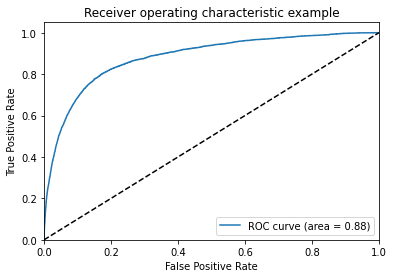

In [184]:
y_predict_prob = model.predict_proba(X_test)
# Отрисовка ROC-кривой
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predict_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],  'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [185]:
y_pred = np.where(y_predict_prob[:, 1] > 0.1, 1, 0)

In [186]:
confusion_matrix(y_test, y_pred)

array([[183251,   6769],
       [  2138,   1759]], dtype=int64)

Analyzing the results of the models, we can say that the results are more or less similar, one XGBoost shows slightly better results than Random Forest and CatBoost.
When analyzing, we focus on the recall.